## **1. Data Preparation**

In [2]:
from clearml import Task
import numpy as np
import random
import os
import optuna

import joblib
import pandas as pd
import optuna.visualization as vis
import matplotlib.pyplot as plt

from pathlib import Path
from clearml import Logger
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
# from xgboost import XGBRegressor

from src import data_preprocessing as dp
from src import pipeline as pl
from src import new_feature_engineering_daily as fe
from src import feature_selection as fs
from src.model_evaluation import evaluate, evaluate_multi_output
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

SEED = 42 # vẫn phải chọn random của model đấy

# Python, NumPy
random.seed(SEED)
np.random.seed(SEED) 

# Hash seed cho Python interpreter (ảnh hưởng tới dict order)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Giới hạn luồng tính toán song song (để tránh floating-point nondeterminism)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# tạo sampler của Optuna có seed cố định
sampler = optuna.samplers.TPESampler(seed=SEED)


c:\Users\Admin\Documents\ML\group1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 1. Load raw Data
df = dp.load_data(r"data\raw data\Hanoi Daily 10 years.csv")

# 2. basic preprocessing for all data set
df = dp.basic_preprocessing(df=df)

# 3. Chia train, test theo thời gian (80/20)
train_size = 0.8
n = len(df)

train_df = df.iloc[:int(train_size * n)]
test_df = df.iloc[int(train_size * n):]

# 4. Create multitarget y  ['temp_next_1','temp_next_2','temp_next_3','temp_next_4','temp_next_5']
train_df, target_col = fe.create_targets(train_df, forecast_horizon= 5)
test_df, _ = fe.create_targets(test_df, forecast_horizon= 5)

# 5. Split X,y 
X_train = train_df.drop(columns= target_col)
y_train = train_df[target_col]

X_test = test_df.drop(columns= target_col)
y_test = test_df[target_col]


Dropped column: 'description'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'


In [ ]:
# # 1. Không sử dụng các biến interaction: is_linear = False

# # Tạo feature engineering (drop NaN sau khi rolling/lag)
# train_feat, target_col = fe.feature_engineering(train_processed, is_drop_nan= True, is_linear= False) # không tạo biến interaction
# test_feat, _ = fe.feature_engineering(test_processed, is_drop_nan= True, is_linear= False)

# # Chia X, y riêng biệt
# X_train = train_feat.drop(columns= target_col)
# y_train = train_feat[target_col]

# X_test = test_feat.drop(columns= target_col)
# y_test = test_feat[target_col]

# # 2. Drop base - Chỉ sử dụng derive feature
# print('\nDrop Base')
# print('số lượng Trước Khi drop base', X_train.shape, X_test.shape)
# X_train = fe.drop_base_features(X_train)
# X_test = fe.drop_base_features(X_test)
# print('số lượng sau drop base', X_train.shape, X_test.shape)


Đã tạo tổng cộng 78 lag features.
Đã tạo 84 rolling features.
Đã tạo tổng cộng 78 lag features.
Đã tạo 84 rolling features.

Drop Base
số lượng Trước Khi drop base (2893, 261) (697, 261)
số lượng sau drop base (2893, 240) (697, 240)


In [ ]:
# # 3. Kiểm tra các biến Category
# encoder = pl.build_encoding_pipeline(is_category=True)
# encoder.fit(X_train, train_feat['temp'])

# X_train = encoder.transform(X_train)
# X_test = encoder.transform(X_test)

# # Kích thước dữ liệu
# print("=" * 60)
# print(f" Kích thước dữ liệu:")
# print(f"   - Train: {X_train.shape} | Target: {y_train.shape}")
# print(f"   - Test : {X_test.shape} | Target: {y_test.shape}")

# print("=" * 60)
# cat_features = X_train.select_dtypes(include=['category']).columns

# print("\nThông tin chi tiết các feature categorical:")
# for col in cat_features:
#     unique_vals = list(X_train[col].unique())
#     print(f"• {col} ({len(unique_vals)} lớp): {unique_vals}")


 Kích thước dữ liệu:
   - Train: (2893, 236) | Target: (2893, 5)
   - Test : (697, 236) | Target: (697, 5)

Thông tin chi tiết các feature categorical:
• conditions (6 lớp): ['Clear', 'Rain', 'Rain, Partially cloudy', 'Partially cloudy', 'Rain, Overcast', 'Overcast']
• wind_category (8 lớp): ['Đông_Bắc_NE', 'Đông_Nam_SE', 'Bắc_N', 'Nam_S', 'Bắc_Đông Bắc_N_NE', 'Tây_Bắc_NW', 'Tây_Nam_SW', 'Tây_W']
• season (5 lớp): [2, 1, 0, 3, 4]


## **2. Model Training**

In [ ]:
# Đổi tên task trong task_name
if Task.current_task():
    Task.current_task().close()

task_lgbm = Task.init(
    project_name="Temperature Forecasting",         # tên project trên ClearML (nếu chưa có sẽ tự tạo)
    task_name="LGB Optuna Tuning full pipeline 2",            # tên task mới
    task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
)

# print(" Task created successfully!")
print("Task ID:", task_lgbm.id)

ClearML Task: created new task id=5fb3c27ef86049c8ab1b7622679edd2d
======> WARNING! Git diff too large to store (5789kb), skipping uncommitted changes <======
ClearML results page: https://app.clear.ml/projects/01d8ce929f0243de9a9d3adf48970730/experiments/5fb3c27ef86049c8ab1b7622679edd2d/output/log
Task ID: 5fb3c27ef86049c8ab1b7622679edd2d


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
2025-11-13 14:03:10,074 - clearml.storage - INFO - Uploading: 4.86MB from C:/Users/Admin/AppData/Local/Temp/Final%20MultiOutput%20Model.ueveb1q0.pkl


█████████████████████████████████ 100% | 4.86/4.86 MB [00:21<00:00,  4.45s/MB]: 
Retrying (Retry(total=237, connect=238, read=239, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002C807817F20>: Failed to resolve 'api.clear.ml' ([Errno 11001] getaddrinfo failed)")': /v2.23/tasks.get_all
### TASK STOPPED - USER ABORTED - STATUS CHANGED ###


In [5]:
task_lgbm = Task.get_task(task_id="5fb3c27ef86049c8ab1b7622679edd2d")
logger_lgbm = task_lgbm.get_logger()

### **2.1. Baseline Model**

####   **Description:** 
`[A LightGBM model using the library's default hyperparameters combined with a target encoding strategy for categorical features.]`

**Default Model Configuration**
*   **LGBM Parameters:**
    *   `boosting_type`: 'gbdt'
    *   `objective`: 'regression'
    *   `n_estimators`: 100
    *   `learning_rate`: 0.1
    *   `max_depth`: -1
    *   `num_leaves`: 31
    *   `min_child_samples`: 20
    *   `subsample`: 1.0
    *   `colsample_bytree`: 1.0
    *   `reg_alpha`: 0.0
    *   `reg_lambda`: 0.0
    *   `random_state`: 42
*   **Encoding Parameters:**
    *   `is_category`: False
    *   `encoding_method_condition`: 'target'
    *   `n_seasons`: 5
    *   `n_quantiles`: 4

In [6]:
# === 1️. Cấu hình LGBM mặc định ===
default_lgbm_params = dict(
    boosting_type='gbdt',
    objective='regression',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,  # -1 means no limit
    num_leaves=31,
    min_child_samples=20,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# === 2. Time Series Cross Validation với Pipeline Tổng trong từng fold ===
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []
cv_artifacts = {}

print("=== Time Series Cross-Validation (COMPLETE PIPELINE + LGBM) ===")

fold_idx = 1
for train_idx, val_idx in tscv.split(X_train):
    # Lấy dữ liệu GỐC cho fold
    X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr_raw, y_val_raw = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Huấn luyện riêng cho từng target
    y_pred_val_all = pd.DataFrame(columns=y_train.columns)
    
    # Theo dõi số lượng features và thông tin pipeline
    pipeline_info = {}
    
    for target_idx, target_col in enumerate(y_train.columns):        
        # Tạo pipeline tổng MỚI cho mỗi target và mỗi fold
        complete_pipeline = pl.build_full_pipeline(
            is_linear=False,
            is_category_conditions=False, 
            is_category_season=False,
            is_category_wind=False,
            encoding_method_condition='target',
            n_seasons=5,
            n_quantiles=4,
            drop_nan=False,
            drop_base=True
        )
        
        # Lấy target thực cho fold này
        y_tr_target = y_tr_raw.iloc[:, target_idx] if len(y_tr_raw.shape) > 1 else y_tr_raw
        
        # FIT pipeline tổng với target thực (cho encoding)
        complete_pipeline.fit(X_tr_raw, y_tr_target)
        
        # TRANSFORM training data
        X_tr_processed = complete_pipeline.transform(X_tr_raw)
        
        # TRANSFORM validation data  
        X_val_processed = complete_pipeline.transform(X_val_raw)
        
        # CUTOFF 30 dòng đầu do rolling features
        X_tr_final = X_tr_processed.iloc[30:]
        X_val_final = X_val_processed.iloc[30:]
        y_tr_final = y_tr_target.iloc[30:]
        
        # Tạo và huấn luyện LGBM model trên data đã processed
        lgbm_model = LGBMRegressor(**default_lgbm_params)
        lgbm_model.fit(X_tr_final, y_tr_final)
        
        # Dự đoán trên validation data
        y_pred = lgbm_model.predict(X_val_final)
        
        # Lưu predictions
        if len(y_pred_val_all) == 0:
            y_pred_val_all = pd.DataFrame(index=range(len(y_pred)), columns=y_train.columns)
        y_pred_val_all[target_col] = y_pred
        
        # Lưu thông tin pipeline cho target đầu tiên
        if target_idx == 0:
            pipeline_info = {
                'original_features': X_tr_raw.shape[1],
                'features_after_pipeline': X_tr_final.shape[1],
                'train_samples_after_cutoff': len(X_tr_final),
                'val_samples_after_cutoff': len(X_val_final)
            }

    # CUTOFF y_val để khớp với predictions
    y_val_cutoff = y_val_raw.iloc[30:]
    
    # Đánh giá - sử dụng tất cả samples sau cutoff
    metrics_val = evaluate_multi_output(y_val_cutoff.values, y_pred_val_all.values)
    avg_val = metrics_val["average"]
    per_day_val = metrics_val["per_day"]
    cv_scores.append(avg_val)

    print(f"\nFold {fold_idx} - Samples: Train={pipeline_info['train_samples_after_cutoff']}, Val={len(y_val_cutoff)}")
    print("Average Metrics:")
    for metric, value in avg_val.items():
        print(f"  {metric}: {value:.4f}")

    # Log artifact
    cv_artifacts[f"Fold_{fold_idx}"] = {
        "average": avg_val,
        "per_day": per_day_val,
        "pipeline_info": pipeline_info,
        "samples_info": {
            "train_original": len(X_tr_raw),
            "train_after_cutoff": pipeline_info['train_samples_after_cutoff'],
            "val_original": len(X_val_raw), 
            "val_after_cutoff": len(y_val_cutoff)
        }
    }

    fold_idx += 1


=== Time Series Cross-Validation (COMPLETE PIPELINE + LGBM) ===

Fold 1 - Samples: Train=458, Val=457
Average Metrics:
  RMSE: 2.6563
  MAE: 2.0469
  R2: 0.6960

Fold 2 - Samples: Train=945, Val=457
Average Metrics:
  RMSE: 2.5638
  MAE: 2.0054
  R2: 0.7027

Fold 3 - Samples: Train=1432, Val=457
Average Metrics:
  RMSE: 2.4870
  MAE: 1.9646
  R2: 0.7729

Fold 4 - Samples: Train=1919, Val=457
Average Metrics:
  RMSE: 2.2888
  MAE: 1.8218
  R2: 0.8008

Fold 5 - Samples: Train=2406, Val=457
Average Metrics:
  RMSE: 2.1898
  MAE: 1.6854
  R2: 0.7881


In [7]:

# === 3. Tổng hợp kết quả cross-validation ===
if cv_scores:
    cv_df = pd.DataFrame(cv_scores)
    cv_mean = cv_df.mean()
    cv_std = cv_df.std()

    print("\n" + "="*50)
    print("=====> Cross-validation trung bình:")
    print(cv_mean)
    print("\n=====> Cross-validation độ lệch chuẩn:")
    print(cv_std)

    # Log artifact tổng hợp CV
    cv_artifacts["CV_Summary"] = {
        "mean": cv_mean.to_dict(),
        "std": cv_std.to_dict(),
        "model_params": default_lgbm_params,
        "pipeline_config": {
            "is_linear": False,
            "is_category_conditions": False,
            "is_category_season": False, 
            "is_category_wind": False,
            "encoding_method_condition": "target",
            "n_seasons": 5,
            "n_quantiles": 4,
            "drop_nan": False,
            "drop_base": True,
            "cutoff_after_pipeline": 30
        }
    }

    # Gửi toàn bộ artifact CV lên ClearML
    task_lgbm.upload_artifact("Complete_Pipeline_Default_LGBM_CV_Detail", cv_artifacts)

    print("\n=== COMPLETE PIPELINE LGBM CONFIGURATION ===")
    print(f"Boosting type: {default_lgbm_params['boosting_type']}")
    print(f"Learning rate: {default_lgbm_params['learning_rate']}")
    print(f"Number of estimators: {default_lgbm_params['n_estimators']}")
    print(f"Max depth: {default_lgbm_params['max_depth']}")
    print(f"Number of leaves: {default_lgbm_params['num_leaves']}")
    print(f"Pipeline: Complete preprocessing + feature engineering")
    print(f"Encoding method: target")
    print(f"Number of seasons: 5")
    print(f"Number of quantiles: 4")
    print(f"Cutoff: 30 rows")
    print(f"Drop base features: True")
else:
    print("No valid CV results to report!")



=====> Cross-validation trung bình:
RMSE    2.437155
MAE     1.904845
R2      0.752100
dtype: float64

=====> Cross-validation độ lệch chuẩn:
RMSE    0.193487
MAE     0.149098
R2      0.049180
dtype: float64

=== COMPLETE PIPELINE LGBM CONFIGURATION ===
Boosting type: gbdt
Learning rate: 0.1
Number of estimators: 100
Max depth: -1
Number of leaves: 31
Pipeline: Complete preprocessing + feature engineering
Encoding method: target
Number of seasons: 5
Number of quantiles: 4
Cutoff: 30 rows
Drop base features: True


####   **Baseline Performance:** 
**Cross-Validation Mean (5-fold TimeSeriesSplit):**
*   RMSE:&nbsp;&nbsp;&nbsp;   2.437155
*   MAE:&nbsp;&nbsp;&nbsp;    1.904845
*   R²:&nbsp;&nbsp;&nbsp;     0.752100

**Cross-Validation Standard Deviation:**
*   RMSE&nbsp;&nbsp;&nbsp;     0.193487
*   MAE&nbsp;&nbsp;&nbsp;      0.149098
*   R²:&nbsp;&nbsp;&nbsp;       0.049180

### **2.2. Hyperparameter Tuning Process**
This section details the methodology used to optimize the LightGBM model's performance. We tuned hyperparameters related to both the core LGBM algorithm and the feature encoding pipeline.


*   **Tuning Method:** Bayesian Optimization using Optuna's `TPESampler`. The objective is to minimize the mean Root Mean Squared Error (RMSE) across a 5-fold `TimeSeriesSplit` cross-validation. Each of the 5 target variables (`temp_next_1` to `temp_next_5`) is tuned independently to find the optimal configuration for each forecast horizon.

*   **Libraries / Tools Used:** `Optuna` for optimization, `LightGBM` for the model, `Scikit-learn` for pipelining and cross-validation, and `ClearML` for experiment tracking.

*   **Hyperparameters Tuned:**

    **LGBM Core Parameters**

    *   **`boosting_type`**: Defines the algorithm to use for boosting.
        *   **`gbdt` (Gradient Boosting Decision Tree)**: The traditional and most commonly used boosting algorithm.
        *   **`dart` (Dropouts meet Multiple Additive Regression Trees)**: A variant of `gbdt` that uses dropout to prevent over-fitting.
        *   **`goss` (Gradient-based One-Side Sampling)**: A faster method that focuses on data instances with larger gradients, potentially speeding up training without significant loss in accuracy.
        *   **Search Space**: `['gbdt', 'dart', 'goss']`

    *   **`n_estimators`**: The number of boosting rounds or trees to build. A higher number can lead to better performance but also increases training time and the risk of overfitting.
        *   **Search Space**: Integer between `[100, 1000]`

    *   **`learning_rate`**: The step size at each iteration. A smaller learning rate requires more estimators but often leads to better generalization.
        *   **Search Space**: Log-uniform float between `[0.001, 0.3]`

    *   **`num_leaves`**: The maximum number of leaves in one tree. This is a key parameter for controlling model complexity. A higher value can lead to a more complex model and potential overfitting.
        *   **Search Space**: Integer between `[15, 255]`

    *   **`max_depth`**: The maximum depth of a tree. It limits the complexity of the model to prevent overfitting. A value of -1 means no limit.
        *   **Search Space**: Integer between `[3, 12]`

    *   **`min_child_samples`**: The minimum number of data points needed in a leaf node. This helps control overfitting by avoiding the creation of leaves with very few samples.
        *   **Search Space**: Integer between `[5, 100]`

    *   **`subsample`**: The fraction of data to be randomly sampled for each tree. This is used to prevent overfitting. It is only active for `gbdt` and `dart` boosting types.
        *   **Search Space**: Float between `[0.6, 1.0]`

    *   **`colsample_bytree`**: The fraction of features to be randomly sampled for each tree.
        *   **Search Space**: Float between `[0.6, 1.0]`

    *   **`reg_alpha` (L1 regularization)** & **`reg_lambda` (L2 regularization)**: These parameters are used to combat overfitting by penalizing large weights.
        *   **Search Space**: Log-uniform float between `[1e-8, 10.0]` for both.

    *   **`min_split_gain`**: The minimum gain required to make a split. It helps control the growth of the tree.
        *   **Search Space**: Float between `[0.0, 1.0]`

    **Feature Encoding Parameters**

    *   **`encoding_method_condition`**: The strategy for encoding the `conditions` categorical feature.
        *   **`ordinal`**: Encodes categories into integer values.
        *   **`target`**: Encodes categories based on the mean of the target variable.
        *   **`quantile`**: Encodes categories based on quantile statistics of the target variable.
        *   **Search Space**: `['ordinal', 'target', 'quantile']`

    *   **`n_seasons`**: The number of seasonal components to generate using sine/cosine transformations for time-based features.
        *   **Search Space**: Integer between `[3, 8]`

    *   **`n_quantiles`**: The number of quantiles to use when `encoding_method_condition` is set to `quantile`.
        *   **Search Space**: Integer between `[2, 6]`

    *   **`is_category` Flags**: Boolean flags (`conditions_is_category`, `season_is_category`, `wind_is_category`) to determine whether the output of specific encoders should be treated as a categorical feature by the LGBM model.
        *   **Search Space**: `[True, False]`

#### **Tuning without Pruner**

In [8]:
def objective_complete_pipeline_per_target(trial, target_name, target_idx):
    # Hyperparameters cho COMPLETE pipeline
    is_linear = trial.suggest_categorical("is_linear", [False])
    encoding_method_condition = trial.suggest_categorical("encoding_method_condition", 
                                                         ["ordinal", "target", "quantile"])
    n_seasons = trial.suggest_int("n_seasons", 3, 8)
    n_quantiles = trial.suggest_int("n_quantiles", 2, 6)
    
    # Tune is_category cho từng encoder
    conditions_is_category = trial.suggest_categorical("conditions_is_category", [True, False])
    season_is_category = trial.suggest_categorical("season_is_category", [True, False])
    wind_is_category = trial.suggest_categorical("wind_is_category", [True, False])
    
    # Hyperparameters cho LGBM
    boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"])
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 12)
    num_leaves = trial.suggest_int("num_leaves", 15, 255)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
    min_split_gain = trial.suggest_float("min_split_gain", 0.0, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)
    
    # Conditional parameters
    if boosting_type in ['gbdt', 'dart']:
        subsample = trial.suggest_float("subsample", 0.6, 1.0)
    else:
        subsample = 1.0
        
    if boosting_type == 'dart':
        subsample_freq = trial.suggest_int("subsample_freq", 1, 10)
    else:
        subsample_freq = 0

    # TimeSeriesSplit
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X_train):
        # Lấy dữ liệu GỐC cho fold hiện tại
        X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr_raw, y_val_raw = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Lấy target thực sự cho fold này
        y_tr_target = y_tr_raw.iloc[:, target_idx] if len(y_tr_raw.shape) > 1 else y_tr_raw
        y_val_target = y_val_raw.iloc[:, target_idx] if len(y_val_raw.shape) > 1 else y_val_raw
        
        try:
            # Build COMPLETE pipeline với các parameters được tuning
            complete_pipeline = pl.build_full_pipeline(
                is_linear=is_linear,
                is_category_conditions=conditions_is_category,
                is_category_season=season_is_category,
                is_category_wind=wind_is_category,
                encoding_method_condition=encoding_method_condition,
                n_seasons=n_seasons,
                n_quantiles=n_quantiles,
                drop_nan=False,  # QUAN TRỌNG: không drop NaN trong pipeline
                drop_base=True
            )
            
            # FIT pipeline trên training fold - SỬA Ở ĐÂY: dùng y_tr_target thực sự
            # Encoding cần 'temp' column từ X_tr_raw, nhưng fit vẫn dùng y thực
            complete_pipeline.fit(X_tr_raw, y_tr_target)
            
            # TRANSFORM cả train và validation
            X_tr_processed = complete_pipeline.transform(X_tr_raw)
            X_val_processed = complete_pipeline.transform(X_val_raw)
            
            # CUTOFF 30 dòng đầu do rolling features
            X_tr_final = X_tr_processed.iloc[30:]
            X_val_final = X_val_processed.iloc[30:]
            
            # Lấy target tương ứng sau cutoff 
            y_tr_single = y_tr_target.iloc[30:]
            y_val_single = y_val_target.iloc[30:]
            
            # Đảm bảo indices khớp nhau
            X_tr_final = X_tr_final.loc[y_tr_single.index]
            X_val_final = X_val_final.loc[y_val_single.index]
            
            # LGBM model
            lgbm = LGBMRegressor(
                boosting_type=boosting_type,
                objective='regression',
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                max_depth=max_depth,
                num_leaves=num_leaves,
                min_child_samples=min_child_samples,
                min_split_gain=min_split_gain,
                colsample_bytree=colsample_bytree,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                subsample=subsample,
                subsample_freq=subsample_freq,
                random_state=42,
                n_jobs=1,
                verbosity=-1
            )
            
            # Fit model
            lgbm.fit(X_tr_final, y_tr_single)
            y_pred_val = lgbm.predict(X_val_final)
            
            # Tính RMSE
            result = evaluate(y_val_single, y_pred_val)
            rmse = result['RMSE']
            rmse_scores.append(rmse)
            
        except Exception as e:
            print(f"Error in trial {trial.number} for {target_name}: {e}")
            import traceback
            traceback.print_exc()
            return float('inf')

    mean_rmse = np.mean(rmse_scores)

    # Log lên ClearML
    logger_lgbm.report_scalar(
        title=f'Optuna Tuning - Complete Pipeline [{target_name}]',
        series='Trial RMSE',
        value=mean_rmse,
        iteration=trial.number
    )

    params_table = pd.DataFrame([{
        "target": target_name,
        "is_linear": is_linear,
        "boosting_type": boosting_type,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "num_leaves": num_leaves,
        "encoding_method": encoding_method_condition,
        "n_seasons": n_seasons,
        "n_quantiles": n_quantiles,
        "conditions_is_category": conditions_is_category,
        "season_is_category": season_is_category,
        "wind_is_category": wind_is_category
    }])
    
    logger_lgbm.report_table(
        title=f"Trial {trial.number} - {target_name}",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    return mean_rmse

In [9]:
# === 2. Hàm helper cho LGBM ===
def build_final_complete_pipeline(params):
    """Build complete pipeline với best parameters"""
    return pl.build_full_pipeline(
        is_linear=params['is_linear'],
        is_category_conditions=params['conditions_is_category'],
        is_category_season=params['season_is_category'],
        is_category_wind=params['wind_is_category'],
        encoding_method_condition=params['encoding_method_condition'],
        n_seasons=params['n_seasons'],
        n_quantiles=params['n_quantiles'],
        drop_nan=False,
        drop_base=True
    )

def extract_lgbm_params(params):
    lgbm_params = {
        'boosting_type': params['boosting_type'],
        'objective': 'regression',
        'learning_rate': params['learning_rate'],
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'num_leaves': params['num_leaves'],
        'min_child_samples': params['min_child_samples'],
        'min_split_gain': params['min_split_gain'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1 
    }
    
    # Conditional parameters
    if params['boosting_type'] in ['gbdt', 'dart']:
        lgbm_params['subsample'] = params['subsample']
    
    if params['boosting_type'] == 'dart':
        lgbm_params['subsample_freq'] = params['subsample_freq']
        
    return lgbm_params


In [10]:
studies_per_target = {}
# === Tune riêng cho từng target với COMPLETE PIPELINE ===
best_complete_models_per_target = {}
best_complete_params_per_target = {}
complete_pipelines_per_target = {}

# Tắt logging
# optuna.logging.set_verbosity(optuna.logging.WARNING)

for idx, target_name in enumerate(y_train.columns):
    print(f"Tuning COMPLETE PIPELINE for target: {target_name} ({idx + 1}/{len(y_train.columns)})")
    
    # Tạo study riêng cho mỗi target
    study = optuna.create_study(
        direction='minimize', 
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(
        lambda trial: objective_complete_pipeline_per_target(trial, target_name, idx), 
        n_trials=100,
        show_progress_bar=True,
        callbacks=[lambda study, trial: None]
    )
    
    studies_per_target[target_name] = study
    
    # Lưu best params
    best_complete_params_per_target[target_name] = study.best_trial.params
    best_complete_params_per_target[target_name]['target_idx'] = idx
    
    # Build final COMPLETE pipeline
    complete_pipeline = build_final_complete_pipeline(study.best_trial.params)
    
    # Fit pipeline trên toàn bộ training data - SỬA Ở ĐÂY: dùng y_target thực
    y_target_full = y_train.iloc[:, idx] if len(y_train.shape) > 1 else y_train
    complete_pipeline.fit(X_train, y_target_full)
    
    # Transform toàn bộ data
    X_train_processed = complete_pipeline.transform(X_train)
    
    # Cutoff 30 dòng đầu
    X_train_final = X_train_processed.iloc[30:]
    y_train_final = y_target_full.iloc[30:]
    
    # Đảm bảo indices khớp
    X_train_final = X_train_final.loc[y_train_final.index]
    
    # Train final LGBM model
    best_lgbm = LGBMRegressor(**extract_lgbm_params(study.best_trial.params))
    best_lgbm.fit(X_train_final, y_train_final)
    
    # Lưu model và pipeline
    best_complete_models_per_target[target_name] = {
        'model': best_lgbm,
        'complete_pipeline': complete_pipeline
    }
    
    complete_pipelines_per_target[target_name] = complete_pipeline
    
    # Log kết quả
    logger_lgbm.report_scalar(
        title='Best RMSE per Target - Complete Pipeline',
        series=target_name,
        value=study.best_value,
        iteration=idx
    )
    
    print(f" {target_name} - Best RMSE: {study.best_value:.4f}")
    print(f" {target_name} - Best encoding: {study.best_trial.params['encoding_method_condition']}")
    print(f" {target_name} - Features after pipeline: {X_train_final.shape[1]}")
    print("-" * 50)

# Khôi phục logging
# optuna.logging.set_verbosity(optuna.logging.INFO)

[I 2025-11-13 10:33:32,578] A new study created in memory with name: no-name-15a2a170-c017-4d32-bb1a-ea839cca6d8c


Tuning COMPLETE PIPELINE for target: temp_next_1 (1/5)


Best trial: 0. Best value: 2.864:   1%|          | 1/100 [00:31<52:35, 31.87s/it]

[I 2025-11-13 10:34:04,451] Trial 0 finished with value: 2.8640001886560773 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002820996133514492, 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 46, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'subsample': 0.7465447373174767}. Best is trial 0 with value: 2.8640001886560773.


Best trial: 1. Best value: 1.57646:   2%|▏         | 2/100 [00:54<42:47, 26.19s/it]

[I 2025-11-13 10:34:26,676] Trial 1 finished with value: 1.5764558540326798 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04953682563497157, 'n_estimators': 496, 'max_depth': 4, 'num_leaves': 134, 'min_child_samples': 8, 'min_split_gain': 0.9093204020787821, 'colsample_bytree': 0.7035119926400067, 'reg_alpha': 0.009176996354542699, 'reg_lambda': 6.388511557344611e-06, 'subsample': 0.8080272084711243}. Best is trial 1 with value: 1.5764558540326798.


Best trial: 1. Best value: 1.57646:   3%|▎         | 3/100 [01:09<34:18, 21.22s/it]

[I 2025-11-13 10:34:41,978] Trial 2 finished with value: 1.7475535086520744 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.11294923622078903, 'n_estimators': 421, 'max_depth': 5, 'num_leaves': 145, 'min_child_samples': 18, 'min_split_gain': 0.8021969807540397, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'subsample': 0.679486272613669, 'subsample_freq': 1}. Best is trial 1 with value: 1.5764558540326798.


Best trial: 1. Best value: 1.57646:   4%|▍         | 4/100 [01:35<37:21, 23.35s/it]

[I 2025-11-13 10:35:08,581] Trial 3 finished with value: 1.8056639008990998 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.037958335792652884, 'n_estimators': 899, 'max_depth': 7, 'num_leaves': 43, 'min_child_samples': 73, 'min_split_gain': 0.7607850486168974, 'colsample_bytree': 0.8245108790277985, 'reg_alpha': 0.08683696167603723, 'reg_lambda': 0.0002780739892288472}. Best is trial 1 with value: 1.5764558540326798.


Best trial: 1. Best value: 1.57646:   5%|▌         | 5/100 [01:58<36:39, 23.15s/it]

[I 2025-11-13 10:35:31,384] Trial 4 finished with value: 2.1805562970808987 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005220949381122231, 'n_estimators': 245, 'max_depth': 12, 'num_leaves': 209, 'min_child_samples': 65, 'min_split_gain': 0.8714605901877177, 'colsample_bytree': 0.9214688307596458, 'reg_alpha': 4.776728196949699e-07, 'reg_lambda': 1.0790237065789294, 'subsample': 0.8157368967662603}. Best is trial 1 with value: 1.5764558540326798.


Best trial: 1. Best value: 1.57646:   6%|▌         | 6/100 [02:15<33:05, 21.12s/it]

[I 2025-11-13 10:35:48,563] Trial 5 finished with value: 1.8556983535562506 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.21662155489352178, 'n_estimators': 391, 'max_depth': 8, 'num_leaves': 184, 'min_child_samples': 39, 'min_split_gain': 0.9717820827209607, 'colsample_bytree': 0.9849789179768444, 'reg_alpha': 1.845188173664121e-06, 'reg_lambda': 0.00029870091504560114}. Best is trial 1 with value: 1.5764558540326798.


Best trial: 1. Best value: 1.57646:   7%|▋         | 7/100 [02:33<30:45, 19.85s/it]

[I 2025-11-13 10:36:05,791] Trial 6 finished with value: 1.606340563868002 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.07702365744928269, 'n_estimators': 314, 'max_depth': 10, 'num_leaves': 103, 'min_child_samples': 65, 'min_split_gain': 0.6335297107608947, 'colsample_bytree': 0.8143098736299034, 'reg_alpha': 6.495430353937541e-08, 'reg_lambda': 0.3293991394919696, 'subsample': 0.7283120259886944}. Best is trial 1 with value: 1.5764558540326798.


Best trial: 1. Best value: 1.57646:   8%|▊         | 8/100 [03:47<57:07, 37.26s/it]

[I 2025-11-13 10:37:20,332] Trial 7 finished with value: 1.8626937618902333 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0019102388408183122, 'n_estimators': 933, 'max_depth': 11, 'num_leaves': 77, 'min_child_samples': 68, 'min_split_gain': 0.8172222002012158, 'colsample_bytree': 0.822080324639785, 'reg_alpha': 0.0005845951462609696, 'reg_lambda': 1.5020023705702004e-06, 'subsample': 0.6372411071223597}. Best is trial 1 with value: 1.5764558540326798.


Best trial: 1. Best value: 1.57646:   9%|▉         | 9/100 [04:15<51:58, 34.27s/it]

[I 2025-11-13 10:37:48,013] Trial 8 finished with value: 18.33568263222556 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.0010538582799512644, 'n_estimators': 191, 'max_depth': 9, 'num_leaves': 16, 'min_child_samples': 20, 'min_split_gain': 0.5487337893665861, 'colsample_bytree': 0.8767580790770773, 'reg_alpha': 0.007373120564908835, 'reg_lambda': 1.043335020558628e-06, 'subsample': 0.8848716885390143, 'subsample_freq': 3}. Best is trial 1 with value: 1.5764558540326798.


Best trial: 1. Best value: 1.57646:  10%|█         | 10/100 [05:22<1:06:33, 44.37s/it]

[I 2025-11-13 10:38:55,001] Trial 9 finished with value: 1.6958657792910672 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.09307734217255954, 'n_estimators': 552, 'max_depth': 8, 'num_leaves': 133, 'min_child_samples': 23, 'min_split_gain': 0.7224521152615053, 'colsample_bytree': 0.7123089449763423, 'reg_alpha': 1.6551741608613844e-08, 'reg_lambda': 0.006445411701103587, 'subsample': 0.6708442717628196, 'subsample_freq': 10}. Best is trial 1 with value: 1.5764558540326798.


Best trial: 1. Best value: 1.57646:  11%|█         | 11/100 [05:47<57:05, 38.48s/it]  

[I 2025-11-13 10:39:20,149] Trial 10 finished with value: 1.6139898242990551 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.009378932289269854, 'n_estimators': 664, 'max_depth': 3, 'num_leaves': 249, 'min_child_samples': 95, 'min_split_gain': 0.340900612142237, 'colsample_bytree': 0.7168953862007945, 'reg_alpha': 1.2096060313323957e-05, 'reg_lambda': 1.997938716689886e-08, 'subsample': 0.9934317343731491}. Best is trial 1 with value: 1.5764558540326798.


Best trial: 1. Best value: 1.57646:  12%|█▏        | 12/100 [06:11<49:45, 33.92s/it]

[I 2025-11-13 10:39:43,633] Trial 11 finished with value: 1.6007331790137482 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.024642917579120578, 'n_estimators': 720, 'max_depth': 3, 'num_leaves': 95, 'min_child_samples': 89, 'min_split_gain': 0.5365404316061166, 'colsample_bytree': 0.7319997333765746, 'reg_alpha': 8.270254947752953e-05, 'reg_lambda': 1.744116329304266, 'subsample': 0.7973759525999851}. Best is trial 1 with value: 1.5764558540326798.


Best trial: 1. Best value: 1.57646:  13%|█▎        | 13/100 [06:35<45:02, 31.06s/it]

[I 2025-11-13 10:40:08,111] Trial 12 finished with value: 1.6043088808364723 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02068514761435548, 'n_estimators': 725, 'max_depth': 3, 'num_leaves': 82, 'min_child_samples': 97, 'min_split_gain': 0.08419622745238281, 'colsample_bytree': 0.7163474096680438, 'reg_alpha': 5.821883258398503e-05, 'reg_lambda': 0.00642585385024294, 'subsample': 0.8226248753666485}. Best is trial 1 with value: 1.5764558540326798.


Best trial: 1. Best value: 1.57646:  14%|█▍        | 14/100 [07:14<48:02, 33.52s/it]

[I 2025-11-13 10:40:47,317] Trial 13 finished with value: 1.577875196801331 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0247407325302209, 'n_estimators': 732, 'max_depth': 4, 'num_leaves': 108, 'min_child_samples': 6, 'min_split_gain': 0.3603557832139395, 'colsample_bytree': 0.6318259455787174, 'reg_alpha': 0.004247249175708178, 'reg_lambda': 3.500925036903018e-05, 'subsample': 0.9112690903453975}. Best is trial 1 with value: 1.5764558540326798.


Best trial: 14. Best value: 1.5749:  15%|█▌        | 15/100 [08:02<53:33, 37.80s/it]

[I 2025-11-13 10:41:35,055] Trial 14 finished with value: 1.574898621027241 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.010544976978045052, 'n_estimators': 550, 'max_depth': 5, 'num_leaves': 172, 'min_child_samples': 8, 'min_split_gain': 0.33200558166167937, 'colsample_bytree': 0.6010491129864212, 'reg_alpha': 0.10347938067716836, 'reg_lambda': 1.6454555921013388e-05, 'subsample': 0.9229272562903895}. Best is trial 14 with value: 1.574898621027241.


Best trial: 14. Best value: 1.5749:  16%|█▌        | 16/100 [08:43<54:06, 38.65s/it]

[I 2025-11-13 10:42:15,653] Trial 15 finished with value: 1.5900931034238104 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.009534997710826243, 'n_estimators': 535, 'max_depth': 5, 'num_leaves': 180, 'min_child_samples': 6, 'min_split_gain': 0.1365787193088114, 'colsample_bytree': 0.6046080524595517, 'reg_alpha': 0.6624826635963764, 'reg_lambda': 2.635659234922028e-08}. Best is trial 14 with value: 1.574898621027241.


Best trial: 14. Best value: 1.5749:  17%|█▋        | 17/100 [09:13<50:09, 36.25s/it]

[I 2025-11-13 10:42:46,341] Trial 16 finished with value: 1.60045116999434 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04284519784129109, 'n_estimators': 535, 'max_depth': 6, 'num_leaves': 180, 'min_child_samples': 31, 'min_split_gain': 0.2214847230495629, 'colsample_bytree': 0.6701644557968636, 'reg_alpha': 0.0662804652174781, 'reg_lambda': 1.7611677214837293e-05, 'subsample': 0.9682611576320758}. Best is trial 14 with value: 1.574898621027241.


Best trial: 14. Best value: 1.5749:  18%|█▊        | 18/100 [09:27<40:15, 29.45s/it]

[I 2025-11-13 10:42:59,941] Trial 17 finished with value: 2.124539762731769 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.01108293182889463, 'n_estimators': 120, 'max_depth': 5, 'num_leaves': 214, 'min_child_samples': 11, 'min_split_gain': 0.43479556555728177, 'colsample_bytree': 0.7649011048051568, 'reg_alpha': 4.876240679352737, 'reg_lambda': 3.0226816030428617e-07, 'subsample': 0.8966110007026772}. Best is trial 14 with value: 1.574898621027241.


Best trial: 14. Best value: 1.5749:  19%|█▉        | 19/100 [10:01<41:36, 30.82s/it]

[I 2025-11-13 10:43:33,959] Trial 18 finished with value: 1.6609885643722855 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.22967297599750966, 'n_estimators': 449, 'max_depth': 4, 'num_leaves': 159, 'min_child_samples': 34, 'min_split_gain': 0.012147383414305157, 'colsample_bytree': 0.660532416632296, 'reg_alpha': 0.005614929394559598, 'reg_lambda': 0.005076889101126265, 'subsample': 0.9472394772122598, 'subsample_freq': 8}. Best is trial 14 with value: 1.574898621027241.


Best trial: 14. Best value: 1.5749:  20%|██        | 20/100 [10:27<39:02, 29.28s/it]

[I 2025-11-13 10:43:59,667] Trial 19 finished with value: 1.633617082485309 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.005896867721330875, 'n_estimators': 624, 'max_depth': 6, 'num_leaves': 247, 'min_child_samples': 52, 'min_split_gain': 0.6343235441142032, 'colsample_bytree': 0.6702866161900692, 'reg_alpha': 0.6398592728285519, 'reg_lambda': 3.859419489263158e-05}. Best is trial 14 with value: 1.574898621027241.


Best trial: 14. Best value: 1.5749:  21%|██        | 21/100 [10:49<36:00, 27.35s/it]

[I 2025-11-13 10:44:22,521] Trial 20 finished with value: 1.5930677654728502 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.05848208547864261, 'n_estimators': 796, 'max_depth': 4, 'num_leaves': 218, 'min_child_samples': 24, 'min_split_gain': 0.9892033936768403, 'colsample_bytree': 0.7684641739429321, 'reg_alpha': 0.0006717650006407481, 'reg_lambda': 1.4280316711169591e-07, 'subsample': 0.8432725317509646}. Best is trial 14 with value: 1.574898621027241.


Best trial: 14. Best value: 1.5749:  22%|██▏       | 22/100 [11:25<38:40, 29.75s/it]

[I 2025-11-13 10:44:57,861] Trial 21 finished with value: 1.5828504807150552 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02790976452855081, 'n_estimators': 802, 'max_depth': 4, 'num_leaves': 125, 'min_child_samples': 5, 'min_split_gain': 0.3542077697496285, 'colsample_bytree': 0.6051540574246893, 'reg_alpha': 0.00612299396530793, 'reg_lambda': 3.354452737220252e-05, 'subsample': 0.9148624034669816}. Best is trial 14 with value: 1.574898621027241.


Best trial: 14. Best value: 1.5749:  23%|██▎       | 23/100 [11:58<39:30, 30.79s/it]

[I 2025-11-13 10:45:31,084] Trial 22 finished with value: 1.578418049769435 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.016090708309085835, 'n_estimators': 603, 'max_depth': 4, 'num_leaves': 110, 'min_child_samples': 13, 'min_split_gain': 0.407420340083069, 'colsample_bytree': 0.6454522383683968, 'reg_alpha': 0.040544739008930276, 'reg_lambda': 9.864697661052245e-06, 'subsample': 0.8709269161227117}. Best is trial 14 with value: 1.574898621027241.


Best trial: 14. Best value: 1.5749:  24%|██▍       | 24/100 [13:08<54:05, 42.70s/it]

[I 2025-11-13 10:46:41,575] Trial 23 finished with value: 1.5957544929694665 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.014376774217689072, 'n_estimators': 449, 'max_depth': 7, 'num_leaves': 159, 'min_child_samples': 13, 'min_split_gain': 0.23040033441704955, 'colsample_bytree': 0.685236410291278, 'reg_alpha': 0.001948841994026208, 'reg_lambda': 0.00011372274647124454, 'subsample': 0.9426599798059467}. Best is trial 14 with value: 1.574898621027241.


Best trial: 24. Best value: 1.5748:  25%|██▌       | 25/100 [14:17<1:03:14, 50.59s/it]

[I 2025-11-13 10:47:50,571] Trial 24 finished with value: 1.5747977603964436 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005032928344530965, 'n_estimators': 994, 'max_depth': 5, 'num_leaves': 60, 'min_child_samples': 28, 'min_split_gain': 0.4691550321834365, 'colsample_bytree': 0.62116596505537, 'reg_alpha': 0.3047179521801738, 'reg_lambda': 0.002718951794969427, 'subsample': 0.7704553214461809}. Best is trial 24 with value: 1.5747977603964436.


Best trial: 24. Best value: 1.5748:  26%|██▌       | 26/100 [14:49<55:13, 44.78s/it]  

[I 2025-11-13 10:48:21,800] Trial 25 finished with value: 1.7109515170405498 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0061125091214509425, 'n_estimators': 355, 'max_depth': 5, 'num_leaves': 49, 'min_child_samples': 27, 'min_split_gain': 0.4839610671222171, 'colsample_bytree': 0.6188063828749175, 'reg_alpha': 0.5129843473882522, 'reg_lambda': 0.0010039793112901877, 'subsample': 0.7639695653207106}. Best is trial 24 with value: 1.5747977603964436.


Best trial: 24. Best value: 1.5748:  27%|██▋       | 27/100 [16:13<1:09:01, 56.74s/it]

[I 2025-11-13 10:49:46,428] Trial 26 finished with value: 1.70425414942978 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.002612410861878738, 'n_estimators': 864, 'max_depth': 6, 'num_leaves': 58, 'min_child_samples': 39, 'min_split_gain': 0.6300330502106299, 'colsample_bytree': 0.6917677643302633, 'reg_alpha': 0.1719170985034085, 'reg_lambda': 0.04466139179704626, 'subsample': 0.718773198019114}. Best is trial 24 with value: 1.5747977603964436.


Best trial: 24. Best value: 1.5748:  28%|██▊       | 28/100 [17:59<1:25:50, 71.53s/it]

[I 2025-11-13 10:51:32,478] Trial 27 finished with value: 1.585833134854247 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005050301000691107, 'n_estimators': 998, 'max_depth': 7, 'num_leaves': 164, 'min_child_samples': 15, 'min_split_gain': 0.4866005917734102, 'colsample_bytree': 0.7578869068699705, 'reg_alpha': 0.022043351637811893, 'reg_lambda': 8.886225713978979, 'subsample': 0.7968267357474451}. Best is trial 24 with value: 1.5747977603964436.


Best trial: 24. Best value: 1.5748:  29%|██▉       | 29/100 [18:24<1:08:03, 57.52s/it]

[I 2025-11-13 10:51:57,289] Trial 28 finished with value: 1.6529484776959193 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.1351811113129365, 'n_estimators': 497, 'max_depth': 5, 'num_leaves': 22, 'min_child_samples': 30, 'min_split_gain': 0.2683791600359044, 'colsample_bytree': 0.6413731907502924, 'reg_alpha': 1.8275365195246762, 'reg_lambda': 0.0014131825849333654, 'subsample': 0.7762286982552374, 'subsample_freq': 5}. Best is trial 24 with value: 1.5747977603964436.


Best trial: 24. Best value: 1.5748:  30%|███       | 30/100 [19:00<59:27, 50.97s/it]  

[I 2025-11-13 10:52:32,978] Trial 29 finished with value: 1.75475111755486 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.003358491648155874, 'n_estimators': 650, 'max_depth': 6, 'num_leaves': 194, 'min_child_samples': 46, 'min_split_gain': 0.16615177123087693, 'colsample_bytree': 0.6880035207527277, 'reg_alpha': 0.021172149882574483, 'reg_lambda': 3.79750481247123e-06}. Best is trial 24 with value: 1.5747977603964436.


Best trial: 24. Best value: 1.5748:  31%|███       | 31/100 [19:21<48:27, 42.13s/it]

[I 2025-11-13 10:52:54,502] Trial 30 finished with value: 2.626177387236757 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.001602394749101637, 'n_estimators': 584, 'max_depth': 3, 'num_leaves': 73, 'min_child_samples': 37, 'min_split_gain': 0.5764198961322399, 'colsample_bytree': 0.6036184962610165, 'reg_alpha': 0.20950138235720947, 'reg_lambda': 1.7350442344178111e-07, 'subsample': 0.8536628549277434}. Best is trial 24 with value: 1.5747977603964436.


Best trial: 24. Best value: 1.5748:  32%|███▏      | 32/100 [19:50<43:06, 38.04s/it]

[I 2025-11-13 10:53:22,975] Trial 31 finished with value: 1.5824107563240344 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.03491556052934007, 'n_estimators': 723, 'max_depth': 4, 'num_leaves': 116, 'min_child_samples': 6, 'min_split_gain': 0.32741928343534654, 'colsample_bytree': 0.6403318763986955, 'reg_alpha': 0.002583532872493135, 'reg_lambda': 7.640311486380608e-05, 'subsample': 0.9266600177699327}. Best is trial 24 with value: 1.5747977603964436.


Best trial: 24. Best value: 1.5748:  33%|███▎      | 33/100 [20:07<35:23, 31.70s/it]

[I 2025-11-13 10:53:39,893] Trial 32 finished with value: 1.6048182719205815 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.052302629615763235, 'n_estimators': 973, 'max_depth': 5, 'num_leaves': 143, 'min_child_samples': 19, 'min_split_gain': 0.41710881825114293, 'colsample_bytree': 0.6286630362517734, 'reg_alpha': 0.0001102804758682611, 'reg_lambda': 4.100258128146652e-06, 'subsample': 0.9913408902741219}. Best is trial 24 with value: 1.5747977603964436.


Best trial: 24. Best value: 1.5748:  34%|███▍      | 34/100 [20:36<34:08, 31.04s/it]

[I 2025-11-13 10:54:09,381] Trial 33 finished with value: 1.5750460669393482 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.013769979560004704, 'n_estimators': 865, 'max_depth': 4, 'num_leaves': 97, 'min_child_samples': 10, 'min_split_gain': 0.38252455883395065, 'colsample_bytree': 0.6546963297038112, 'reg_alpha': 0.016428394077686512, 'reg_lambda': 0.0006342117909079494, 'subsample': 0.847142208764229}. Best is trial 24 with value: 1.5747977603964436.


Best trial: 24. Best value: 1.5748:  35%|███▌      | 35/100 [21:17<36:54, 34.07s/it]

[I 2025-11-13 10:54:50,516] Trial 34 finished with value: 1.5960316873057079 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.008155772162071381, 'n_estimators': 835, 'max_depth': 6, 'num_leaves': 87, 'min_child_samples': 17, 'min_split_gain': 0.6903271016300253, 'colsample_bytree': 0.6708540441883138, 'reg_alpha': 1.8294492004829073, 'reg_lambda': 0.03271682938955929, 'subsample': 0.8549048921896893}. Best is trial 24 with value: 1.5747977603964436.


Best trial: 24. Best value: 1.5748:  36%|███▌      | 36/100 [22:32<49:10, 46.10s/it]

[I 2025-11-13 10:56:04,687] Trial 35 finished with value: 1.5862478341308184 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0036208086119678315, 'n_estimators': 923, 'max_depth': 5, 'num_leaves': 37, 'min_child_samples': 10, 'min_split_gain': 0.9214438604830841, 'colsample_bytree': 0.8629414956301655, 'reg_alpha': 0.12554140094996044, 'reg_lambda': 0.0004863381441873613, 'subsample': 0.7529788575144599}. Best is trial 24 with value: 1.5747977603964436.


Best trial: 24. Best value: 1.5748:  37%|███▋      | 37/100 [22:48<38:54, 37.06s/it]

[I 2025-11-13 10:56:20,657] Trial 36 finished with value: 1.5830084632715191 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.013338905816507865, 'n_estimators': 878, 'max_depth': 3, 'num_leaves': 128, 'min_child_samples': 23, 'min_split_gain': 0.277417344738808, 'colsample_bytree': 0.7422347987460356, 'reg_alpha': 0.017417475217309127, 'reg_lambda': 0.00013643529630060977}. Best is trial 24 with value: 1.5747977603964436.


Best trial: 37. Best value: 1.56888:  38%|███▊      | 38/100 [23:04<31:44, 30.72s/it]

[I 2025-11-13 10:56:36,593] Trial 37 finished with value: 1.5688785239252954 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.018818507565168303, 'n_estimators': 399, 'max_depth': 7, 'num_leaves': 62, 'min_child_samples': 48, 'min_split_gain': 0.4512807357988513, 'colsample_bytree': 0.7928029549030813, 'reg_alpha': 8.417532122217796, 'reg_lambda': 0.0010648200904892892, 'subsample': 0.8259624638744122}. Best is trial 37 with value: 1.5688785239252954.


Best trial: 37. Best value: 1.56888:  39%|███▉      | 39/100 [23:18<26:08, 25.72s/it]

[I 2025-11-13 10:56:50,644] Trial 38 finished with value: 1.8463625280458575 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.007162997032668067, 'n_estimators': 258, 'max_depth': 7, 'num_leaves': 64, 'min_child_samples': 58, 'min_split_gain': 0.4765988506040577, 'colsample_bytree': 0.9157460350249678, 'reg_alpha': 7.623295509457672, 'reg_lambda': 0.001802249409909148, 'subsample': 0.8357587823285952}. Best is trial 37 with value: 1.5688785239252954.


Best trial: 37. Best value: 1.56888:  40%|████      | 40/100 [23:36<23:36, 23.60s/it]

[I 2025-11-13 10:57:09,310] Trial 39 finished with value: 14.734168273196724 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.0043168944261012445, 'n_estimators': 358, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 45, 'min_split_gain': 0.399319073956043, 'colsample_bytree': 0.7920508413782317, 'reg_alpha': 1.2443606217554672, 'reg_lambda': 0.01824586868427594, 'subsample': 0.7767611628859337, 'subsample_freq': 7}. Best is trial 37 with value: 1.5688785239252954.


Best trial: 37. Best value: 1.56888:  41%|████      | 41/100 [24:08<25:44, 26.17s/it]

[I 2025-11-13 10:57:41,472] Trial 40 finished with value: 1.5977588443476236 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.01915879884277683, 'n_estimators': 953, 'max_depth': 8, 'num_leaves': 55, 'min_child_samples': 76, 'min_split_gain': 0.5922482433259472, 'colsample_bytree': 0.9834255267289653, 'reg_alpha': 3.2850213425064267, 'reg_lambda': 0.15903936028546686, 'subsample': 0.7285614123372959}. Best is trial 37 with value: 1.5688785239252954.


Best trial: 37. Best value: 1.56888:  42%|████▏     | 42/100 [24:30<23:54, 24.73s/it]

[I 2025-11-13 10:58:02,838] Trial 41 finished with value: 1.59643494358828 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.03152052538311158, 'n_estimators': 469, 'max_depth': 12, 'num_leaves': 69, 'min_child_samples': 53, 'min_split_gain': 0.4462798159786704, 'colsample_bytree': 0.6540231074807953, 'reg_alpha': 0.2994141452194783, 'reg_lambda': 0.0003918733295693268, 'subsample': 0.8110945784404172}. Best is trial 37 with value: 1.5688785239252954.


Best trial: 37. Best value: 1.56888:  43%|████▎     | 43/100 [24:38<18:51, 19.85s/it]

[I 2025-11-13 10:58:11,277] Trial 42 finished with value: 1.6110334242494162 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.15410411696774745, 'n_estimators': 399, 'max_depth': 4, 'num_leaves': 98, 'min_child_samples': 19, 'min_split_gain': 0.8247829570896111, 'colsample_bytree': 0.787405600471688, 'reg_alpha': 0.045293459294476514, 'reg_lambda': 9.697137097169997e-07, 'subsample': 0.8722705735379787}. Best is trial 37 with value: 1.5688785239252954.


Best trial: 37. Best value: 1.56888:  44%|████▍     | 44/100 [25:12<22:28, 24.08s/it]

[I 2025-11-13 10:58:45,265] Trial 43 finished with value: 1.5994292415400646 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.01265078595133586, 'n_estimators': 322, 'max_depth': 9, 'num_leaves': 87, 'min_child_samples': 27, 'min_split_gain': 0.30232083421225503, 'colsample_bytree': 0.7033037289751315, 'reg_alpha': 0.0010912452313407701, 'reg_lambda': 0.002861890655763143, 'subsample': 0.7894257422123842}. Best is trial 37 with value: 1.5688785239252954.


Best trial: 37. Best value: 1.56888:  45%|████▌     | 45/100 [25:22<18:13, 19.88s/it]

[I 2025-11-13 10:58:55,335] Trial 44 finished with value: 1.5920857969124098 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.06793583920118346, 'n_estimators': 512, 'max_depth': 5, 'num_leaves': 43, 'min_child_samples': 10, 'min_split_gain': 0.5196637230325075, 'colsample_bytree': 0.6217585230320547, 'reg_alpha': 0.014835981145586112, 'reg_lambda': 0.0005946360346835735, 'subsample': 0.824796535232798}. Best is trial 37 with value: 1.5688785239252954.


Best trial: 45. Best value: 1.56511:  46%|████▌     | 46/100 [25:35<15:53, 17.65s/it]

[I 2025-11-13 10:59:07,770] Trial 45 finished with value: 1.5651121473323086 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.019915059963387174, 'n_estimators': 567, 'max_depth': 3, 'num_leaves': 149, 'min_child_samples': 44, 'min_split_gain': 0.7440593930440449, 'colsample_bytree': 0.7386652909159572, 'reg_alpha': 0.00030746175406626166, 'reg_lambda': 0.012848588408372996, 'subsample': 0.698580868235504}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  47%|████▋     | 47/100 [25:42<12:56, 14.66s/it]

[I 2025-11-13 10:59:15,460] Trial 46 finished with value: 1.6086566903239041 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.01919558900142852, 'n_estimators': 196, 'max_depth': 3, 'num_leaves': 139, 'min_child_samples': 47, 'min_split_gain': 0.3616242802453885, 'colsample_bytree': 0.8293713144624989, 'reg_alpha': 1.1860773769503279e-05, 'reg_lambda': 0.011110285139814336, 'subsample': 0.6811799764074884}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  48%|████▊     | 48/100 [26:09<15:44, 18.16s/it]

[I 2025-11-13 10:59:41,717] Trial 47 finished with value: 4.88629380834072 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.010937496221287245, 'n_estimators': 761, 'max_depth': 3, 'num_leaves': 164, 'min_child_samples': 42, 'min_split_gain': 0.6974274871092032, 'colsample_bytree': 0.844654514025381, 'reg_alpha': 1.707075931099227e-05, 'reg_lambda': 0.09471944919960733, 'subsample': 0.6265560658498156, 'subsample_freq': 1}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  49%|████▉     | 49/100 [27:03<24:33, 28.88s/it]

[I 2025-11-13 11:00:35,685] Trial 48 finished with value: 1.578681417910849 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.008017483620807045, 'n_estimators': 916, 'max_depth': 10, 'num_leaves': 118, 'min_child_samples': 60, 'min_split_gain': 0.7760254107329789, 'colsample_bytree': 0.7314050342439079, 'reg_alpha': 0.00025134513201056935, 'reg_lambda': 0.583814885023939, 'subsample': 0.7105874633589189}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  50%|█████     | 50/100 [27:22<21:39, 26.00s/it]

[I 2025-11-13 11:00:54,952] Trial 49 finished with value: 1.6076440570104051 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.02228049189706188, 'n_estimators': 673, 'max_depth': 7, 'num_leaves': 196, 'min_child_samples': 52, 'min_split_gain': 0.389283686525992, 'colsample_bytree': 0.805740359549926, 'reg_alpha': 9.23085769979782, 'reg_lambda': 0.0002512057232108693}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  51%|█████     | 51/100 [27:36<18:20, 22.47s/it]

[I 2025-11-13 11:01:09,176] Trial 50 finished with value: 1.5728583825081865 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04124834587297834, 'n_estimators': 296, 'max_depth': 4, 'num_leaves': 151, 'min_child_samples': 33, 'min_split_gain': 0.5610516046775587, 'colsample_bytree': 0.7446511700763202, 'reg_alpha': 3.2297428911666887e-07, 'reg_lambda': 0.004024228468331734, 'subsample': 0.6808483519297852}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  52%|█████▏    | 52/100 [27:49<15:42, 19.64s/it]

[I 2025-11-13 11:01:22,212] Trial 51 finished with value: 1.5783975517507929 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04043483385409003, 'n_estimators': 211, 'max_depth': 4, 'num_leaves': 171, 'min_child_samples': 36, 'min_split_gain': 0.45031682348337865, 'colsample_bytree': 0.7740986738920924, 'reg_alpha': 4.008547850286782e-07, 'reg_lambda': 0.003671613606331469, 'subsample': 0.6626448614884286}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  53%|█████▎    | 53/100 [28:01<13:31, 17.27s/it]

[I 2025-11-13 11:01:33,967] Trial 52 finished with value: 1.5894121629794262 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.016212108786113514, 'n_estimators': 290, 'max_depth': 3, 'num_leaves': 149, 'min_child_samples': 31, 'min_split_gain': 0.543106024161149, 'colsample_bytree': 0.7419703145294423, 'reg_alpha': 4.764063592580901e-06, 'reg_lambda': 0.011830410788679666, 'subsample': 0.700440578867484}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  54%|█████▍    | 54/100 [28:14<12:19, 16.08s/it]

[I 2025-11-13 11:01:47,279] Trial 53 finished with value: 1.5760030671721421 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02504235100063946, 'n_estimators': 417, 'max_depth': 4, 'num_leaves': 151, 'min_child_samples': 42, 'min_split_gain': 0.6079484010346818, 'colsample_bytree': 0.619132220435822, 'reg_alpha': 3.8671167508305533e-07, 'reg_lambda': 0.0008331980794139609, 'subsample': 0.6099097633094616}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  55%|█████▌    | 55/100 [28:26<11:07, 14.84s/it]

[I 2025-11-13 11:01:59,209] Trial 54 finished with value: 2.1339123733778806 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.010190760943157825, 'n_estimators': 127, 'max_depth': 5, 'num_leaves': 134, 'min_child_samples': 41, 'min_split_gain': 0.6612842646958157, 'colsample_bytree': 0.7516384589187894, 'reg_alpha': 1.2273185080943029e-08, 'reg_lambda': 0.002438308094724058, 'subsample': 0.6559754873486544}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  56%|█████▌    | 56/100 [28:45<11:39, 15.90s/it]

[I 2025-11-13 11:02:17,603] Trial 55 finished with value: 1.5768787865602307 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02923596801488154, 'n_estimators': 346, 'max_depth': 6, 'num_leaves': 173, 'min_child_samples': 49, 'min_split_gain': 0.7425564785714591, 'colsample_bytree': 0.7170569770500778, 'reg_alpha': 9.43562006597751e-08, 'reg_lambda': 0.022549409198207585, 'subsample': 0.6878403430194603}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  57%|█████▋    | 57/100 [29:00<11:22, 15.88s/it]

[I 2025-11-13 11:02:33,432] Trial 56 finished with value: 1.5986824771127666 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0818348208870042, 'n_estimators': 566, 'max_depth': 4, 'num_leaves': 195, 'min_child_samples': 27, 'min_split_gain': 0.515077784624907, 'colsample_bytree': 0.7800966190036699, 'reg_alpha': 1.8157767609378419e-06, 'reg_lambda': 0.0001581329653220544, 'subsample': 0.7406846053153674}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  58%|█████▊    | 58/100 [29:26<13:08, 18.78s/it]

[I 2025-11-13 11:02:58,990] Trial 57 finished with value: 1.583391539225302 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04318366442923625, 'n_estimators': 309, 'max_depth': 8, 'num_leaves': 79, 'min_child_samples': 34, 'min_split_gain': 0.2153010245289248, 'colsample_bytree': 0.6578233006399168, 'reg_alpha': 0.056995785899134996, 'reg_lambda': 0.007174642793662288, 'subsample': 0.6461472961441919}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  59%|█████▉    | 59/100 [29:39<11:43, 17.15s/it]

[I 2025-11-13 11:03:12,329] Trial 58 finished with value: 10.301314672488038 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.01351179303489146, 'n_estimators': 231, 'max_depth': 3, 'num_leaves': 93, 'min_child_samples': 22, 'min_split_gain': 0.5590341218483531, 'colsample_bytree': 0.8127185197024034, 'reg_alpha': 0.42556361084615585, 'reg_lambda': 0.04834845325342066, 'subsample': 0.6968455354536001, 'subsample_freq': 10}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  60%|██████    | 60/100 [29:49<09:52, 14.81s/it]

[I 2025-11-13 11:03:21,664] Trial 59 finished with value: 1.6953662995473533 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.292067636066236, 'n_estimators': 380, 'max_depth': 5, 'num_leaves': 230, 'min_child_samples': 56, 'min_split_gain': 0.3229424890289152, 'colsample_bytree': 0.7007576554973703, 'reg_alpha': 0.10200413086076257, 'reg_lambda': 4.941863618368735e-05, 'subsample': 0.8891157746088182}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  61%|██████    | 61/100 [29:56<08:16, 12.73s/it]

[I 2025-11-13 11:03:29,559] Trial 60 finished with value: 1.6405422873606839 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.01602241930148719, 'n_estimators': 162, 'max_depth': 4, 'num_leaves': 154, 'min_child_samples': 16, 'min_split_gain': 0.8915707624743119, 'colsample_bytree': 0.6754339788391944, 'reg_alpha': 1.1220959878694328, 'reg_lambda': 0.001468341301376396}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  62%|██████▏   | 62/100 [30:12<08:32, 13.48s/it]

[I 2025-11-13 11:03:44,777] Trial 61 finished with value: 1.5784601655142025 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.022062032978657567, 'n_estimators': 434, 'max_depth': 4, 'num_leaves': 145, 'min_child_samples': 43, 'min_split_gain': 0.593218320021973, 'colsample_bytree': 0.6168503816888387, 'reg_alpha': 5.212188185268084e-08, 'reg_lambda': 0.0008556432008456189, 'subsample': 0.6005600431157819}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  63%|██████▎   | 63/100 [30:28<08:46, 14.23s/it]

[I 2025-11-13 11:04:00,763] Trial 62 finished with value: 1.582698843560622 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.025663690837808215, 'n_estimators': 403, 'max_depth': 5, 'num_leaves': 186, 'min_child_samples': 49, 'min_split_gain': 0.4595590300533606, 'colsample_bytree': 0.6013111642886384, 'reg_alpha': 1.35862851673316e-06, 'reg_lambda': 0.0002403573968486941, 'subsample': 0.6122070805866581}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  64%|██████▍   | 64/100 [30:39<07:55, 13.21s/it]

[I 2025-11-13 11:04:11,595] Trial 63 finished with value: 1.572133341949143 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.036547504733485905, 'n_estimators': 480, 'max_depth': 3, 'num_leaves': 122, 'min_child_samples': 33, 'min_split_gain': 0.6305224256303412, 'colsample_bytree': 0.6364641229534598, 'reg_alpha': 3.2848237071103986e-07, 'reg_lambda': 0.00480133586569435, 'subsample': 0.6318011110745877}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  65%|██████▌   | 65/100 [30:53<07:54, 13.55s/it]

[I 2025-11-13 11:04:25,930] Trial 64 finished with value: 1.5753390396345892 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.034030353959027496, 'n_estimators': 474, 'max_depth': 3, 'num_leaves': 105, 'min_child_samples': 37, 'min_split_gain': 0.656222208284879, 'colsample_bytree': 0.6373475345306089, 'reg_alpha': 8.679825850222605e-07, 'reg_lambda': 0.005582873544329677, 'subsample': 0.6357283425833533}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  66%|██████▌   | 66/100 [31:09<08:07, 14.34s/it]

[I 2025-11-13 11:04:42,120] Trial 65 finished with value: 1.5772716506036997 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.049793050462720104, 'n_estimators': 513, 'max_depth': 3, 'num_leaves': 124, 'min_child_samples': 34, 'min_split_gain': 0.3695448491102918, 'colsample_bytree': 0.7288239313737983, 'reg_alpha': 4.331555837410597e-08, 'reg_lambda': 0.010045895632790179, 'subsample': 0.673227444752678}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  67%|██████▋   | 67/100 [31:32<09:19, 16.96s/it]

[I 2025-11-13 11:05:05,182] Trial 66 finished with value: 1.5813305542251401 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.006968312214264949, 'n_estimators': 691, 'max_depth': 4, 'num_leaves': 117, 'min_child_samples': 29, 'min_split_gain': 0.5037593141101463, 'colsample_bytree': 0.6516127855414965, 'reg_alpha': 3.0079935306762122, 'reg_lambda': 0.00430250111295665, 'subsample': 0.865910761591198}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  68%|██████▊   | 68/100 [31:42<07:59, 14.97s/it]

[I 2025-11-13 11:05:15,521] Trial 67 finished with value: 1.6758520494758884 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.10273940100129221, 'n_estimators': 551, 'max_depth': 6, 'num_leaves': 63, 'min_child_samples': 14, 'min_split_gain': 0.42386540327595534, 'colsample_bytree': 0.6108858866173825, 'reg_alpha': 2.2959697698779734e-07, 'reg_lambda': 1.755073145666023e-05, 'subsample': 0.8315150381642288}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  69%|██████▉   | 69/100 [31:55<07:24, 14.33s/it]

[I 2025-11-13 11:05:28,353] Trial 68 finished with value: 1.6129866207792947 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.06117385406624922, 'n_estimators': 623, 'max_depth': 3, 'num_leaves': 134, 'min_child_samples': 63, 'min_split_gain': 0.8249463777842423, 'colsample_bytree': 0.6278403686396109, 'reg_alpha': 5.274861840991559e-06, 'reg_lambda': 0.08241485542039681, 'subsample': 0.7348929779558956}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  70%|███████   | 70/100 [32:25<09:29, 18.97s/it]

[I 2025-11-13 11:05:58,151] Trial 69 finished with value: 1.5841903575971634 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.012183919182274182, 'n_estimators': 829, 'max_depth': 4, 'num_leaves': 173, 'min_child_samples': 74, 'min_split_gain': 0.7165798704511016, 'colsample_bytree': 0.6801927531444831, 'reg_alpha': 4.6122099240356957e-05, 'reg_lambda': 0.0019108328932718338, 'subsample': 0.9033658268423315}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  71%|███████   | 71/100 [33:54<19:19, 39.98s/it]

[I 2025-11-13 11:07:27,157] Trial 70 finished with value: 4.4089575451685095 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.009320454625119741, 'n_estimators': 990, 'max_depth': 11, 'num_leaves': 49, 'min_child_samples': 39, 'min_split_gain': 0.5577039592376526, 'colsample_bytree': 0.660521770789775, 'reg_alpha': 0.0034925858330858623, 'reg_lambda': 0.021518141359995892, 'subsample': 0.7540649078826874, 'subsample_freq': 4}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  72%|███████▏  | 72/100 [34:10<15:14, 32.65s/it]

[I 2025-11-13 11:07:42,684] Trial 71 finished with value: 1.571382296522073 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.03294499767605162, 'n_estimators': 481, 'max_depth': 3, 'num_leaves': 102, 'min_child_samples': 35, 'min_split_gain': 0.6318983464374877, 'colsample_bytree': 0.6387899141522092, 'reg_alpha': 7.591781045200583e-07, 'reg_lambda': 0.0030010446556923333, 'subsample': 0.631495276037436}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 45. Best value: 1.56511:  73%|███████▎  | 73/100 [34:26<12:31, 27.85s/it]

[I 2025-11-13 11:07:59,333] Trial 72 finished with value: 1.592507908172063 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.03868647355600586, 'n_estimators': 583, 'max_depth': 3, 'num_leaves': 112, 'min_child_samples': 24, 'min_split_gain': 0.6233695300683821, 'colsample_bytree': 0.6379993184638666, 'reg_alpha': 2.675641547995119e-08, 'reg_lambda': 0.0008761559329983411, 'subsample': 0.9729204227493795}. Best is trial 45 with value: 1.5651121473323086.


Best trial: 73. Best value: 1.55869:  74%|███████▍  | 74/100 [34:44<10:41, 24.67s/it]

[I 2025-11-13 11:08:16,589] Trial 73 finished with value: 1.5586925398342837 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.017781371855479036, 'n_estimators': 486, 'max_depth': 3, 'num_leaves': 86, 'min_child_samples': 9, 'min_split_gain': 0.6655534529206146, 'colsample_bytree': 0.6462856444985087, 'reg_alpha': 2.3407413359339416e-07, 'reg_lambda': 0.00044332628263591843, 'subsample': 0.6273185050280524}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  75%|███████▌  | 75/100 [34:58<09:02, 21.72s/it]

[I 2025-11-13 11:08:31,417] Trial 74 finished with value: 1.5716360766040154 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.017993825235208902, 'n_estimators': 455, 'max_depth': 3, 'num_leaves': 84, 'min_child_samples': 32, 'min_split_gain': 0.6609719712125292, 'colsample_bytree': 0.6305039117031717, 'reg_alpha': 1.0369920890380728e-06, 'reg_lambda': 0.0030163413433700794, 'subsample': 0.6315373807930852}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  76%|███████▌  | 76/100 [35:15<08:06, 20.27s/it]

[I 2025-11-13 11:08:48,325] Trial 75 finished with value: 1.5675028489904403 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.017913628830729805, 'n_estimators': 465, 'max_depth': 3, 'num_leaves': 83, 'min_child_samples': 35, 'min_split_gain': 0.6763479681615188, 'colsample_bytree': 0.6954614675583345, 'reg_alpha': 2.4334419848734204e-07, 'reg_lambda': 0.0033164496245504196, 'subsample': 0.6256194407934711}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  77%|███████▋  | 77/100 [35:35<07:41, 20.05s/it]

[I 2025-11-13 11:09:07,845] Trial 76 finished with value: 1.5707342677173122 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.017845731610942973, 'n_estimators': 468, 'max_depth': 3, 'num_leaves': 87, 'min_child_samples': 33, 'min_split_gain': 0.6636794653716085, 'colsample_bytree': 0.7071189320806317, 'reg_alpha': 1.2385470349891524e-07, 'reg_lambda': 0.007164558067492168, 'subsample': 0.6256433712096462}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  78%|███████▊  | 78/100 [35:55<07:22, 20.10s/it]

[I 2025-11-13 11:09:28,055] Trial 77 finished with value: 1.5715555387417992 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.018394575884588395, 'n_estimators': 459, 'max_depth': 3, 'num_leaves': 87, 'min_child_samples': 37, 'min_split_gain': 0.7877332856992517, 'colsample_bytree': 0.6914387266424387, 'reg_alpha': 9.595130153234991e-08, 'reg_lambda': 0.014525448893905136, 'subsample': 0.6205303325786126}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  79%|███████▉  | 79/100 [36:10<06:31, 18.66s/it]

[I 2025-11-13 11:09:43,366] Trial 78 finished with value: 1.5815203472264283 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.018581479476657344, 'n_estimators': 525, 'max_depth': 3, 'num_leaves': 86, 'min_child_samples': 39, 'min_split_gain': 0.7891822125907411, 'colsample_bytree': 0.6971049351845787, 'reg_alpha': 1.0267913788867593e-07, 'reg_lambda': 0.01478326894755782}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  80%|████████  | 80/100 [36:27<06:03, 18.16s/it]

[I 2025-11-13 11:10:00,351] Trial 79 finished with value: 1.577526413729262 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.017043892704444775, 'n_estimators': 453, 'max_depth': 3, 'num_leaves': 71, 'min_child_samples': 45, 'min_split_gain': 0.8593783132531548, 'colsample_bytree': 0.710815830186055, 'reg_alpha': 8.750020452790232e-07, 'reg_lambda': 0.03245263388149481, 'subsample': 0.6221035858814999}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  81%|████████  | 81/100 [36:43<05:33, 17.54s/it]

[I 2025-11-13 11:10:16,445] Trial 80 finished with value: 1.5619987312875252 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.021676459979910325, 'n_estimators': 490, 'max_depth': 3, 'num_leaves': 77, 'min_child_samples': 36, 'min_split_gain': 0.7450748326031172, 'colsample_bytree': 0.7199663268003177, 'reg_alpha': 1.8476356555517193e-07, 'reg_lambda': 0.13672001145063248, 'subsample': 0.6479740971992398}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  82%|████████▏ | 82/100 [36:59<05:03, 16.86s/it]

[I 2025-11-13 11:10:31,728] Trial 81 finished with value: 1.5687346180186723 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.022696764371299645, 'n_estimators': 494, 'max_depth': 3, 'num_leaves': 76, 'min_child_samples': 37, 'min_split_gain': 0.7487184340005224, 'colsample_bytree': 0.7202301314595022, 'reg_alpha': 1.2150080615964375e-07, 'reg_lambda': 0.18661959935812247, 'subsample': 0.6537348784515308}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  83%|████████▎ | 83/100 [37:14<04:37, 16.33s/it]

[I 2025-11-13 11:10:46,805] Trial 82 finished with value: 1.5678745599630024 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02084158375998966, 'n_estimators': 490, 'max_depth': 3, 'num_leaves': 76, 'min_child_samples': 37, 'min_split_gain': 0.7495964101269835, 'colsample_bytree': 0.7222011405029792, 'reg_alpha': 1.6652054686829523e-07, 'reg_lambda': 2.490514760845031, 'subsample': 0.6442652564197077}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  84%|████████▍ | 84/100 [37:25<03:57, 14.86s/it]

[I 2025-11-13 11:10:58,235] Trial 83 finished with value: 1.5665088197821588 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02779279136971047, 'n_estimators': 429, 'max_depth': 3, 'num_leaves': 76, 'min_child_samples': 40, 'min_split_gain': 0.7638303897825751, 'colsample_bytree': 0.7281358390028718, 'reg_alpha': 1.6517294078331978e-07, 'reg_lambda': 1.4402925343052102, 'subsample': 0.6489462419165388}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  85%|████████▌ | 85/100 [37:37<03:30, 14.02s/it]

[I 2025-11-13 11:11:10,294] Trial 84 finished with value: 1.569647938321623 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02214025983731948, 'n_estimators': 495, 'max_depth': 3, 'num_leaves': 77, 'min_child_samples': 50, 'min_split_gain': 0.7361877424559844, 'colsample_bytree': 0.7267105939221499, 'reg_alpha': 1.7235390594145114e-07, 'reg_lambda': 1.8118063303056189, 'subsample': 0.6473059868925788}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  86%|████████▌ | 86/100 [37:54<03:26, 14.74s/it]

[I 2025-11-13 11:11:26,720] Trial 85 finished with value: 1.5674054442039906 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02227013189591146, 'n_estimators': 432, 'max_depth': 3, 'num_leaves': 76, 'min_child_samples': 50, 'min_split_gain': 0.7273828743083283, 'colsample_bytree': 0.7218936776428085, 'reg_alpha': 2.7479760264443436e-08, 'reg_lambda': 3.027097809978592, 'subsample': 0.6508381169849965}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  87%|████████▋ | 87/100 [38:07<03:07, 14.43s/it]

[I 2025-11-13 11:11:40,428] Trial 86 finished with value: 1.5734787792028926 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.027926705562467135, 'n_estimators': 437, 'max_depth': 3, 'num_leaves': 56, 'min_child_samples': 55, 'min_split_gain': 0.7584342100306246, 'colsample_bytree': 0.7186130610296403, 'reg_alpha': 2.186410535653869e-08, 'reg_lambda': 2.680771959049148, 'subsample': 0.6612450952397019}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  88%|████████▊ | 88/100 [38:24<03:02, 15.23s/it]

[I 2025-11-13 11:11:57,531] Trial 87 finished with value: 1.572566971765464 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.014822895176411043, 'n_estimators': 386, 'max_depth': 4, 'num_leaves': 67, 'min_child_samples': 44, 'min_split_gain': 0.7110706453912843, 'colsample_bytree': 0.752335601305965, 'reg_alpha': 3.1802698669965884e-08, 'reg_lambda': 5.106239278934419, 'subsample': 0.6457154255938311}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  89%|████████▉ | 89/100 [38:38<02:41, 14.70s/it]

[I 2025-11-13 11:12:11,001] Trial 88 finished with value: 1.5674598676296343 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.023914400768544872, 'n_estimators': 415, 'max_depth': 3, 'num_leaves': 75, 'min_child_samples': 47, 'min_split_gain': 0.9357390826860659, 'colsample_bytree': 0.7608824673979221, 'reg_alpha': 3.1881358186042696e-06, 'reg_lambda': 0.4574712245862197, 'subsample': 0.6540269138493404}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  90%|█████████ | 90/100 [38:56<02:38, 15.84s/it]

[I 2025-11-13 11:12:29,483] Trial 89 finished with value: 1.5671137862995805 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.024063541965484624, 'n_estimators': 539, 'max_depth': 3, 'num_leaves': 94, 'min_child_samples': 40, 'min_split_gain': 0.817922564444641, 'colsample_bytree': 0.7615501041506865, 'reg_alpha': 3.572214575652637e-06, 'reg_lambda': 0.4111002028180139, 'subsample': 0.6539208947559203}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  91%|█████████ | 91/100 [39:11<02:20, 15.61s/it]

[I 2025-11-13 11:12:44,559] Trial 90 finished with value: 1.6039729223670693 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.030355731091521967, 'n_estimators': 529, 'max_depth': 3, 'num_leaves': 92, 'min_child_samples': 82, 'min_split_gain': 0.8505497944169711, 'colsample_bytree': 0.767226672372696, 'reg_alpha': 3.5289549477319023e-06, 'reg_lambda': 0.7516479838821251, 'subsample': 0.6683073458041854}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  92%|█████████▏| 92/100 [39:25<02:00, 15.11s/it]

[I 2025-11-13 11:12:58,514] Trial 91 finished with value: 1.5609164890280172 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.023678133399630055, 'n_estimators': 423, 'max_depth': 3, 'num_leaves': 74, 'min_child_samples': 46, 'min_split_gain': 0.9708425243575898, 'colsample_bytree': 0.7363698584534134, 'reg_alpha': 1.9782017907758803e-07, 'reg_lambda': 0.3715022407345259, 'subsample': 0.6535238364626794}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  93%|█████████▎| 93/100 [39:44<01:52, 16.04s/it]

[I 2025-11-13 11:13:16,695] Trial 92 finished with value: 1.5669495153590602 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02303810017217771, 'n_estimators': 568, 'max_depth': 3, 'num_leaves': 72, 'min_child_samples': 40, 'min_split_gain': 0.9630776326352521, 'colsample_bytree': 0.7576217521198759, 'reg_alpha': 1.914149208526026e-07, 'reg_lambda': 0.4217326602221943, 'subsample': 0.65138498035589}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  94%|█████████▍| 94/100 [40:00<01:36, 16.14s/it]

[I 2025-11-13 11:13:33,087] Trial 93 finished with value: 1.582348019216782 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02616813963392444, 'n_estimators': 589, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 51, 'min_split_gain': 0.9214461261533295, 'colsample_bytree': 0.737332431633995, 'reg_alpha': 6.094141868072718e-07, 'reg_lambda': 0.36138010092952194, 'subsample': 0.6120326773498729}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  95%|█████████▌| 95/100 [40:15<01:19, 15.82s/it]

[I 2025-11-13 11:13:48,161] Trial 94 finished with value: 1.566422242950021 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02509502585415694, 'n_estimators': 417, 'max_depth': 4, 'num_leaves': 70, 'min_child_samples': 47, 'min_split_gain': 0.959445297123847, 'colsample_bytree': 0.7592449037264842, 'reg_alpha': 1.0172610397436567e-08, 'reg_lambda': 0.9268974260050223, 'subsample': 0.667151674817223}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  96%|█████████▌| 96/100 [40:30<01:01, 15.43s/it]

[I 2025-11-13 11:14:02,663] Trial 95 finished with value: 1.5709161146449575 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.028241824096626338, 'n_estimators': 430, 'max_depth': 4, 'num_leaves': 68, 'min_child_samples': 47, 'min_split_gain': 0.9540227023307242, 'colsample_bytree': 0.7594627798353569, 'reg_alpha': 1.1229952174819808e-08, 'reg_lambda': 1.0855294602805614, 'subsample': 0.6911013177821258}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  97%|█████████▋| 97/100 [40:43<00:44, 14.83s/it]

[I 2025-11-13 11:14:16,112] Trial 96 finished with value: 5.511937964734248 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.023782790985891204, 'n_estimators': 367, 'max_depth': 4, 'num_leaves': 93, 'min_child_samples': 53, 'min_split_gain': 0.9889302708648828, 'colsample_bytree': 0.7814966288762183, 'reg_alpha': 6.318563402689428e-08, 'reg_lambda': 0.3343088237096686, 'subsample': 0.6729115258747053, 'subsample_freq': 7}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  98%|█████████▊| 98/100 [40:55<00:27, 13.84s/it]

[I 2025-11-13 11:14:27,622] Trial 97 finished with value: 1.5985669910519131 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.04636688386579519, 'n_estimators': 412, 'max_depth': 3, 'num_leaves': 72, 'min_child_samples': 41, 'min_split_gain': 0.9482614179412259, 'colsample_bytree': 0.7485042282043638, 'reg_alpha': 2.514662855572207e-06, 'reg_lambda': 0.5596848521795971}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869:  99%|█████████▉| 99/100 [41:16<00:16, 16.24s/it]

[I 2025-11-13 11:14:49,485] Trial 98 finished with value: 1.5661004744045959 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 8, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.014898240121006615, 'n_estimators': 518, 'max_depth': 4, 'num_leaves': 81, 'min_child_samples': 46, 'min_split_gain': 0.8788206661745686, 'colsample_bytree': 0.7573810417080546, 'reg_alpha': 3.668291877195557e-08, 'reg_lambda': 4.740685967666991, 'subsample': 0.7096386523399235}. Best is trial 73 with value: 1.5586925398342837.


Best trial: 73. Best value: 1.55869: 100%|██████████| 100/100 [41:44<00:00, 25.05s/it]


[I 2025-11-13 11:15:17,250] Trial 99 finished with value: 1.573195649308972 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0152509247236451, 'n_estimators': 623, 'max_depth': 4, 'num_leaves': 99, 'min_child_samples': 56, 'min_split_gain': 0.8929903923600668, 'colsample_bytree': 0.7368426358460519, 'reg_alpha': 1.872566072731256e-08, 'reg_lambda': 6.356220433138002, 'subsample': 0.7029793112396967}. Best is trial 73 with value: 1.5586925398342837.


[I 2025-11-13 11:15:20,083] A new study created in memory with name: no-name-9447ec19-379c-460e-83c8-ab1e57a31a8b


 temp_next_1 - Best RMSE: 1.5587
 temp_next_1 - Best encoding: quantile
 temp_next_1 - Features after pipeline: 236
--------------------------------------------------
Tuning COMPLETE PIPELINE for target: temp_next_2 (2/5)


Best trial: 0. Best value: 3.17289:   1%|          | 1/100 [00:24<39:38, 24.03s/it]

[I 2025-11-13 11:15:44,123] Trial 0 finished with value: 3.1728911322026865 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002820996133514492, 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 46, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'subsample': 0.7465447373174767}. Best is trial 0 with value: 3.1728911322026865.


Best trial: 1. Best value: 2.35711:   2%|▏         | 2/100 [00:44<36:12, 22.17s/it]

[I 2025-11-13 11:16:04,986] Trial 1 finished with value: 2.357109233040437 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04953682563497157, 'n_estimators': 496, 'max_depth': 4, 'num_leaves': 134, 'min_child_samples': 8, 'min_split_gain': 0.9093204020787821, 'colsample_bytree': 0.7035119926400067, 'reg_alpha': 0.009176996354542699, 'reg_lambda': 6.388511557344611e-06, 'subsample': 0.8080272084711243}. Best is trial 1 with value: 2.357109233040437.


Best trial: 1. Best value: 2.35711:   3%|▎         | 3/100 [00:55<27:15, 16.86s/it]

[I 2025-11-13 11:16:15,521] Trial 2 finished with value: 2.3709537479453586 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.11294923622078903, 'n_estimators': 421, 'max_depth': 5, 'num_leaves': 145, 'min_child_samples': 18, 'min_split_gain': 0.8021969807540397, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'subsample': 0.679486272613669, 'subsample_freq': 1}. Best is trial 1 with value: 2.357109233040437.


Best trial: 1. Best value: 2.35711:   4%|▍         | 4/100 [01:09<24:56, 15.59s/it]

[I 2025-11-13 11:16:29,181] Trial 3 finished with value: 2.4292284411911327 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.037958335792652884, 'n_estimators': 899, 'max_depth': 7, 'num_leaves': 43, 'min_child_samples': 73, 'min_split_gain': 0.7607850486168974, 'colsample_bytree': 0.8245108790277985, 'reg_alpha': 0.08683696167603723, 'reg_lambda': 0.0002780739892288472}. Best is trial 1 with value: 2.357109233040437.


Best trial: 1. Best value: 2.35711:   5%|▌         | 5/100 [01:23<24:13, 15.30s/it]

[I 2025-11-13 11:16:43,964] Trial 4 finished with value: 2.653689623401991 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005220949381122231, 'n_estimators': 245, 'max_depth': 12, 'num_leaves': 209, 'min_child_samples': 65, 'min_split_gain': 0.8714605901877177, 'colsample_bytree': 0.9214688307596458, 'reg_alpha': 4.776728196949699e-07, 'reg_lambda': 1.0790237065789294, 'subsample': 0.8157368967662603}. Best is trial 1 with value: 2.357109233040437.


Best trial: 1. Best value: 2.35711:   6%|▌         | 6/100 [01:39<24:00, 15.33s/it]

[I 2025-11-13 11:16:59,338] Trial 5 finished with value: 2.589895693073979 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.21662155489352178, 'n_estimators': 391, 'max_depth': 8, 'num_leaves': 184, 'min_child_samples': 39, 'min_split_gain': 0.9717820827209607, 'colsample_bytree': 0.9849789179768444, 'reg_alpha': 1.845188173664121e-06, 'reg_lambda': 0.00029870091504560114}. Best is trial 1 with value: 2.357109233040437.


Best trial: 1. Best value: 2.35711:   7%|▋         | 7/100 [01:55<24:11, 15.60s/it]

[I 2025-11-13 11:17:15,515] Trial 6 finished with value: 2.370175500992251 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.07702365744928269, 'n_estimators': 314, 'max_depth': 10, 'num_leaves': 103, 'min_child_samples': 65, 'min_split_gain': 0.6335297107608947, 'colsample_bytree': 0.8143098736299034, 'reg_alpha': 6.495430353937541e-08, 'reg_lambda': 0.3293991394919696, 'subsample': 0.7283120259886944}. Best is trial 1 with value: 2.357109233040437.


Best trial: 1. Best value: 2.35711:   8%|▊         | 8/100 [02:47<41:45, 27.23s/it]

[I 2025-11-13 11:18:07,640] Trial 7 finished with value: 2.4185981934859266 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0019102388408183122, 'n_estimators': 933, 'max_depth': 11, 'num_leaves': 77, 'min_child_samples': 68, 'min_split_gain': 0.8172222002012158, 'colsample_bytree': 0.822080324639785, 'reg_alpha': 0.0005845951462609696, 'reg_lambda': 1.5020023705702004e-06, 'subsample': 0.6372411071223597}. Best is trial 1 with value: 2.357109233040437.


Best trial: 1. Best value: 2.35711:   9%|▉         | 9/100 [03:05<37:06, 24.46s/it]

[I 2025-11-13 11:18:26,017] Trial 8 finished with value: 18.33958072642009 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.0010538582799512644, 'n_estimators': 191, 'max_depth': 9, 'num_leaves': 16, 'min_child_samples': 20, 'min_split_gain': 0.5487337893665861, 'colsample_bytree': 0.8767580790770773, 'reg_alpha': 0.007373120564908835, 'reg_lambda': 1.043335020558628e-06, 'subsample': 0.8848716885390143, 'subsample_freq': 3}. Best is trial 1 with value: 2.357109233040437.


Best trial: 1. Best value: 2.35711:  10%|█         | 10/100 [03:48<45:03, 30.03s/it]

[I 2025-11-13 11:19:08,525] Trial 9 finished with value: 2.3862019245682418 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.09307734217255954, 'n_estimators': 552, 'max_depth': 8, 'num_leaves': 133, 'min_child_samples': 23, 'min_split_gain': 0.7224521152615053, 'colsample_bytree': 0.7123089449763423, 'reg_alpha': 1.6551741608613844e-08, 'reg_lambda': 0.006445411701103587, 'subsample': 0.6708442717628196, 'subsample_freq': 10}. Best is trial 1 with value: 2.357109233040437.


Best trial: 10. Best value: 2.26503:  11%|█         | 11/100 [04:02<37:09, 25.05s/it]

[I 2025-11-13 11:19:22,277] Trial 10 finished with value: 2.2650325798780124 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.009378932289269854, 'n_estimators': 664, 'max_depth': 3, 'num_leaves': 249, 'min_child_samples': 95, 'min_split_gain': 0.340900612142237, 'colsample_bytree': 0.7168953862007945, 'reg_alpha': 1.2096060313323957e-05, 'reg_lambda': 1.997938716689886e-08, 'subsample': 0.9934317343731491}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  12%|█▏        | 12/100 [04:16<31:55, 21.77s/it]

[I 2025-11-13 11:19:36,522] Trial 11 finished with value: 2.2802020561659715 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.013565228657352815, 'n_estimators': 720, 'max_depth': 3, 'num_leaves': 255, 'min_child_samples': 99, 'min_split_gain': 0.26050134126999797, 'colsample_bytree': 0.7113411923530987, 'reg_alpha': 3.2731091941637804e-05, 'reg_lambda': 1.6980303691194483e-08, 'subsample': 0.9966842065613537}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  13%|█▎        | 13/100 [04:30<27:58, 19.29s/it]

[I 2025-11-13 11:19:50,111] Trial 12 finished with value: 2.2706619734890707 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.01182190445404165, 'n_estimators': 713, 'max_depth': 3, 'num_leaves': 242, 'min_child_samples': 99, 'min_split_gain': 0.044484882765798095, 'colsample_bytree': 0.7306028830290099, 'reg_alpha': 2.3216639169521766e-05, 'reg_lambda': 1.196409926556595e-08, 'subsample': 0.9930744627111218}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  14%|█▍        | 14/100 [04:44<25:30, 17.80s/it]

[I 2025-11-13 11:20:04,475] Trial 13 finished with value: 2.2763270177804054 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.012425613877507864, 'n_estimators': 694, 'max_depth': 3, 'num_leaves': 254, 'min_child_samples': 92, 'min_split_gain': 0.018107326091163445, 'colsample_bytree': 0.6332013063783791, 'reg_alpha': 1.9943575652237363e-05, 'reg_lambda': 2.9283168014772237e-08, 'subsample': 0.9862301801713017}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  15%|█▌        | 15/100 [05:22<33:55, 23.94s/it]

[I 2025-11-13 11:20:42,656] Trial 14 finished with value: 2.2726039307463144 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.00600902293123279, 'n_estimators': 719, 'max_depth': 5, 'num_leaves': 212, 'min_child_samples': 83, 'min_split_gain': 0.01753884834303271, 'colsample_bytree': 0.7616287146723624, 'reg_alpha': 2.6010281931010283e-05, 'reg_lambda': 1.5063196221152497e-07, 'subsample': 0.9204329368026746}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  16%|█▌        | 16/100 [05:35<28:51, 20.61s/it]

[I 2025-11-13 11:20:55,516] Trial 15 finished with value: 2.3901142513702913 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.024645607336422057, 'n_estimators': 608, 'max_depth': 3, 'num_leaves': 220, 'min_child_samples': 86, 'min_split_gain': 0.3051456727420172, 'colsample_bytree': 0.7597266377845102, 'reg_alpha': 3.267665320403853e-06, 'reg_lambda': 1.774307748920864e-07}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  17%|█▋        | 17/100 [06:10<34:21, 24.84s/it]

[I 2025-11-13 11:21:30,208] Trial 16 finished with value: 2.2665296714660075 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.007343928062513995, 'n_estimators': 832, 'max_depth': 5, 'num_leaves': 187, 'min_child_samples': 100, 'min_split_gain': 0.13132872278430205, 'colsample_bytree': 0.6587660228045042, 'reg_alpha': 0.0002987770231357501, 'reg_lambda': 1.938418664214207e-05, 'subsample': 0.9207895879494299}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  18%|█▊        | 18/100 [06:52<41:14, 30.18s/it]

[I 2025-11-13 11:22:12,804] Trial 17 finished with value: 2.274021235189795 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.006318163087804315, 'n_estimators': 882, 'max_depth': 5, 'num_leaves': 178, 'min_child_samples': 79, 'min_split_gain': 0.4232598067719129, 'colsample_bytree': 0.6519241760561743, 'reg_alpha': 0.00047141691271499066, 'reg_lambda': 3.230953776777884e-05, 'subsample': 0.885999243213331}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  19%|█▉        | 19/100 [08:15<1:02:13, 46.10s/it]

[I 2025-11-13 11:23:35,982] Trial 18 finished with value: 11.410944872574529 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.0029093384771677914, 'n_estimators': 988, 'max_depth': 6, 'num_leaves': 173, 'min_child_samples': 55, 'min_split_gain': 0.16237177164939298, 'colsample_bytree': 0.6834345622045149, 'reg_alpha': 0.2544423418173048, 'reg_lambda': 0.010797893510379195, 'subsample': 0.9307088692098651, 'subsample_freq': 8}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  20%|██        | 20/100 [08:33<49:52, 37.41s/it]  

[I 2025-11-13 11:23:53,141] Trial 19 finished with value: 2.4056475806547413 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.021852287508852482, 'n_estimators': 838, 'max_depth': 4, 'num_leaves': 202, 'min_child_samples': 89, 'min_split_gain': 0.4273818938985925, 'colsample_bytree': 0.6658447084750001, 'reg_alpha': 0.005001334887556702, 'reg_lambda': 2.1644025910556762e-05}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  21%|██        | 21/100 [09:19<52:55, 40.20s/it]

[I 2025-11-13 11:24:39,844] Trial 20 finished with value: 2.303413913572455 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.008504851763034258, 'n_estimators': 806, 'max_depth': 6, 'num_leaves': 226, 'min_child_samples': 57, 'min_split_gain': 0.1764907426697978, 'colsample_bytree': 0.6041637687348731, 'reg_alpha': 0.0002943762900609785, 'reg_lambda': 0.0013878454151833267, 'subsample': 0.9411044116441032}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  22%|██▏       | 22/100 [09:48<47:53, 36.84s/it]

[I 2025-11-13 11:25:08,854] Trial 21 finished with value: 2.2693802069101014 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.010798506019234069, 'n_estimators': 640, 'max_depth': 4, 'num_leaves': 236, 'min_child_samples': 98, 'min_split_gain': 0.12231542722209138, 'colsample_bytree': 0.7603462978067851, 'reg_alpha': 9.16556892039963e-05, 'reg_lambda': 1.6435383028662722e-07, 'subsample': 0.996380231265402}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  23%|██▎       | 23/100 [10:19<44:45, 34.88s/it]

[I 2025-11-13 11:25:39,155] Trial 22 finished with value: 2.318590576308263 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.003845745013724916, 'n_estimators': 621, 'max_depth': 4, 'num_leaves': 231, 'min_child_samples': 100, 'min_split_gain': 0.14120417788519007, 'colsample_bytree': 0.7713809544034272, 'reg_alpha': 0.00012584461254578047, 'reg_lambda': 2.3545771649746408e-07, 'subsample': 0.9539405671760566}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  24%|██▍       | 24/100 [11:00<46:41, 36.87s/it]

[I 2025-11-13 11:26:20,658] Trial 23 finished with value: 2.2671912062395045 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.008837242024792798, 'n_estimators': 768, 'max_depth': 4, 'num_leaves': 198, 'min_child_samples': 92, 'min_split_gain': 0.38278705419671644, 'colsample_bytree': 0.7450735103761182, 'reg_alpha': 2.804735470403203e-06, 'reg_lambda': 8.590824665127251e-08, 'subsample': 0.862444950942423}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  25%|██▌       | 25/100 [11:36<45:48, 36.64s/it]

[I 2025-11-13 11:26:56,777] Trial 24 finished with value: 2.2992432664531437 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02062995772882747, 'n_estimators': 804, 'max_depth': 5, 'num_leaves': 190, 'min_child_samples': 79, 'min_split_gain': 0.39588706317174743, 'colsample_bytree': 0.6826772806463085, 'reg_alpha': 1.863322190925038e-06, 'reg_lambda': 7.822854656361587, 'subsample': 0.8552789137470661}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  26%|██▌       | 26/100 [12:21<48:14, 39.12s/it]

[I 2025-11-13 11:27:41,671] Trial 25 finished with value: 2.2694646802204956 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0070362341576068735, 'n_estimators': 781, 'max_depth': 7, 'num_leaves': 192, 'min_child_samples': 91, 'min_split_gain': 0.5172757234966251, 'colsample_bytree': 0.7360896410886081, 'reg_alpha': 0.0016174621109906675, 'reg_lambda': 4.5301561784710005e-05, 'subsample': 0.8617403011180363}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  27%|██▋       | 27/100 [12:52<44:39, 36.71s/it]

[I 2025-11-13 11:28:12,769] Trial 26 finished with value: 2.8238621350799895 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0019894474147993846, 'n_estimators': 534, 'max_depth': 4, 'num_leaves': 159, 'min_child_samples': 74, 'min_split_gain': 0.3489796297042833, 'colsample_bytree': 0.7866049682384952, 'reg_alpha': 8.275447499938758e-06, 'reg_lambda': 5.411916919121785e-08, 'subsample': 0.9160939258841968}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  28%|██▊       | 28/100 [13:18<40:05, 33.41s/it]

[I 2025-11-13 11:28:38,471] Trial 27 finished with value: 2.335891097465514 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.035931305080368445, 'n_estimators': 996, 'max_depth': 3, 'num_leaves': 105, 'min_child_samples': 92, 'min_split_gain': 0.6347087902626893, 'colsample_bytree': 0.611911408075823, 'reg_alpha': 5.284030574460995e-07, 'reg_lambda': 8.422753598758762e-07, 'subsample': 0.8404747880055498}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  29%|██▉       | 29/100 [14:04<44:13, 37.37s/it]

[I 2025-11-13 11:29:25,093] Trial 28 finished with value: 10.320547633596542 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.004545266503607224, 'n_estimators': 763, 'max_depth': 6, 'num_leaves': 165, 'min_child_samples': 82, 'min_split_gain': 0.23343112928986823, 'colsample_bytree': 0.6653366745085566, 'reg_alpha': 1.0830143692191403e-08, 'reg_lambda': 7.2316190914696055e-06, 'subsample': 0.7696044520780208, 'subsample_freq': 5}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  30%|███       | 30/100 [14:53<47:32, 40.74s/it]

[I 2025-11-13 11:30:13,703] Trial 29 finished with value: 2.3002930702721374 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0029659132692336576, 'n_estimators': 859, 'max_depth': 6, 'num_leaves': 152, 'min_child_samples': 44, 'min_split_gain': 0.339488615177999, 'colsample_bytree': 0.7235910323333077, 'reg_alpha': 1.7502851502562083e-07, 'reg_lambda': 1.5614900384274802e-06}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  31%|███       | 31/100 [15:32<46:05, 40.07s/it]

[I 2025-11-13 11:30:52,208] Trial 30 finished with value: 2.2980164686870617 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.016696094427429933, 'n_estimators': 653, 'max_depth': 5, 'num_leaves': 202, 'min_child_samples': 92, 'min_split_gain': 0.22754800400044534, 'colsample_bytree': 0.8878606168396257, 'reg_alpha': 5.195835177139495e-06, 'reg_lambda': 9.019275475278395e-05, 'subsample': 0.8971930085059002}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 10. Best value: 2.26503:  32%|███▏      | 32/100 [15:58<40:50, 36.03s/it]

[I 2025-11-13 11:31:18,813] Trial 31 finished with value: 2.2650753324522 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.010002747015631766, 'n_estimators': 589, 'max_depth': 4, 'num_leaves': 236, 'min_child_samples': 100, 'min_split_gain': 0.10060951290559719, 'colsample_bytree': 0.7498617727134627, 'reg_alpha': 8.415144890355665e-05, 'reg_lambda': 6.100304192795393e-08, 'subsample': 0.9663849513424979}. Best is trial 10 with value: 2.2650325798780124.


Best trial: 32. Best value: 2.26067:  33%|███▎      | 33/100 [16:21<35:44, 32.01s/it]

[I 2025-11-13 11:31:41,427] Trial 32 finished with value: 2.260672550352017 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.008477333798004492, 'n_estimators': 482, 'max_depth': 4, 'num_leaves': 240, 'min_child_samples': 96, 'min_split_gain': 0.07580462135210364, 'colsample_bytree': 0.6876662065272433, 'reg_alpha': 6.274669534549741e-05, 'reg_lambda': 5.495765435991524e-08, 'subsample': 0.9588357488060579}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  34%|███▍      | 34/100 [16:42<31:44, 28.86s/it]

[I 2025-11-13 11:32:02,934] Trial 33 finished with value: 2.266538576886878 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.008731835342104383, 'n_estimators': 444, 'max_depth': 4, 'num_leaves': 240, 'min_child_samples': 86, 'min_split_gain': 0.09276750382110084, 'colsample_bytree': 0.6872118880568572, 'reg_alpha': 8.965539928799416e-05, 'reg_lambda': 4.0780755299020964e-07, 'subsample': 0.9580100657145265}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  35%|███▌      | 35/100 [17:05<29:16, 27.03s/it]

[I 2025-11-13 11:32:25,697] Trial 34 finished with value: 2.297162515172937 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.029181317526713994, 'n_estimators': 491, 'max_depth': 5, 'num_leaves': 221, 'min_child_samples': 96, 'min_split_gain': 0.07801143550228129, 'colsample_bytree': 0.6451832647293434, 'reg_alpha': 0.0014223387211603387, 'reg_lambda': 4.760159933745739e-06, 'subsample': 0.9714738959033727}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  36%|███▌      | 36/100 [17:28<27:22, 25.67s/it]

[I 2025-11-13 11:32:48,185] Trial 35 finished with value: 2.3728728972264137 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.003927454606213497, 'n_estimators': 542, 'max_depth': 3, 'num_leaves': 252, 'min_child_samples': 34, 'min_split_gain': 0.2041733207983489, 'colsample_bytree': 0.7011069669499956, 'reg_alpha': 0.12107470498307088, 'reg_lambda': 1.0442765950992774e-08, 'subsample': 0.9608697227751934}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  37%|███▋      | 37/100 [17:52<26:38, 25.37s/it]

[I 2025-11-13 11:33:12,879] Trial 36 finished with value: 2.2878017653342964 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.015910713940320752, 'n_estimators': 349, 'max_depth': 7, 'num_leaves': 215, 'min_child_samples': 74, 'min_split_gain': 0.07793217778467815, 'colsample_bytree': 0.7952963260683428, 'reg_alpha': 0.02920043934656284, 'reg_lambda': 5.713969553192179e-08, 'subsample': 0.9299774976682292}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  38%|███▊      | 38/100 [18:03<21:49, 21.13s/it]

[I 2025-11-13 11:33:24,087] Trial 37 finished with value: 2.2974009646304987 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.06507150286409796, 'n_estimators': 109, 'max_depth': 5, 'num_leaves': 239, 'min_child_samples': 6, 'min_split_gain': 0.2695283900140794, 'colsample_bytree': 0.6981211319260029, 'reg_alpha': 9.389927204586474, 'reg_lambda': 1.040171252227036e-05}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  39%|███▉      | 39/100 [18:35<24:36, 24.20s/it]

[I 2025-11-13 11:33:55,447] Trial 38 finished with value: 2.274219781570533 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.005249598311707528, 'n_estimators': 579, 'max_depth': 4, 'num_leaves': 227, 'min_child_samples': 95, 'min_split_gain': 0.0006015152624662123, 'colsample_bytree': 0.9821624364028583, 'reg_alpha': 0.7938358444688948, 'reg_lambda': 3.7716625677247234e-08, 'subsample': 0.9124514376075751}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  40%|████      | 40/100 [19:02<24:56, 24.95s/it]

[I 2025-11-13 11:34:22,157] Trial 39 finished with value: 17.215388348711734 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.0017901875807066335, 'n_estimators': 494, 'max_depth': 3, 'num_leaves': 210, 'min_child_samples': 60, 'min_split_gain': 0.1113259590895469, 'colsample_bytree': 0.8491161030203622, 'reg_alpha': 0.0026952734288314705, 'reg_lambda': 5.171862194641229e-07, 'subsample': 0.967284325172559, 'subsample_freq': 7}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  41%|████      | 41/100 [19:35<27:08, 27.60s/it]

[I 2025-11-13 11:34:55,956] Trial 40 finished with value: 2.3497584190974576 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.04217938054693975, 'n_estimators': 478, 'max_depth': 9, 'num_leaves': 248, 'min_child_samples': 69, 'min_split_gain': 0.17763339377275933, 'colsample_bytree': 0.6686713382096477, 'reg_alpha': 0.00020583377299664433, 'reg_lambda': 2.5543732806692036e-06, 'subsample': 0.9443376896918414}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  42%|████▏     | 42/100 [19:56<24:36, 25.45s/it]

[I 2025-11-13 11:35:16,383] Trial 41 finished with value: 2.2698803980785547 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.008695478149543731, 'n_estimators': 386, 'max_depth': 4, 'num_leaves': 238, 'min_child_samples': 86, 'min_split_gain': 0.07840685310443755, 'colsample_bytree': 0.6871016368754075, 'reg_alpha': 7.045058735779415e-05, 'reg_lambda': 3.1880974634704794e-07, 'subsample': 0.9724015296307132}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  43%|████▎     | 43/100 [20:20<23:41, 24.93s/it]

[I 2025-11-13 11:35:40,094] Trial 42 finished with value: 2.2710717154283087 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.007810389100926284, 'n_estimators': 443, 'max_depth': 4, 'num_leaves': 231, 'min_child_samples': 85, 'min_split_gain': 0.10076880976526524, 'colsample_bytree': 0.7171117849522157, 'reg_alpha': 0.0005002689110780076, 'reg_lambda': 4.924451474445063e-07, 'subsample': 0.95315726867426}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  44%|████▍     | 44/100 [20:37<21:09, 22.66s/it]

[I 2025-11-13 11:35:57,477] Trial 43 finished with value: 2.4509790443951305 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.2408239515138183, 'n_estimators': 434, 'max_depth': 4, 'num_leaves': 121, 'min_child_samples': 100, 'min_split_gain': 0.06176371101263857, 'colsample_bytree': 0.6457589298200337, 'reg_alpha': 1.6096591254461264e-05, 'reg_lambda': 2.3057069790608617e-08, 'subsample': 0.9782178888209556}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  45%|████▌     | 45/100 [20:58<20:24, 22.27s/it]

[I 2025-11-13 11:36:18,815] Trial 44 finished with value: 2.2908308918734823 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.01052265393695147, 'n_estimators': 270, 'max_depth': 12, 'num_leaves': 67, 'min_child_samples': 88, 'min_split_gain': 0.14463499319475154, 'colsample_bytree': 0.7406345797540113, 'reg_alpha': 7.030823103030343e-05, 'reg_lambda': 7.89089034012947e-08, 'subsample': 0.9041229111860074}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  46%|████▌     | 46/100 [21:21<20:05, 22.33s/it]

[I 2025-11-13 11:36:41,283] Trial 45 finished with value: 2.277559574217345 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.015122046752472236, 'n_estimators': 675, 'max_depth': 3, 'num_leaves': 245, 'min_child_samples': 96, 'min_split_gain': 0.30006416906001354, 'colsample_bytree': 0.6242433717173479, 'reg_alpha': 6.030508685230157e-07, 'reg_lambda': 2.699193237501616e-06, 'subsample': 0.9425799720976975}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  47%|████▋     | 47/100 [22:14<28:03, 31.77s/it]

[I 2025-11-13 11:37:35,070] Trial 46 finished with value: 2.281248805254599 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005213546145713964, 'n_estimators': 929, 'max_depth': 6, 'num_leaves': 216, 'min_child_samples': 80, 'min_split_gain': 0.4670878546483922, 'colsample_bytree': 0.7040829519521477, 'reg_alpha': 9.628461588300146e-06, 'reg_lambda': 0.00013491023192161884, 'subsample': 0.7898853433328421}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  48%|████▊     | 48/100 [22:42<26:24, 30.47s/it]

[I 2025-11-13 11:38:02,520] Trial 47 finished with value: 7.7417463346594335 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.010831830546878508, 'n_estimators': 583, 'max_depth': 3, 'num_leaves': 183, 'min_child_samples': 96, 'min_split_gain': 0.2053745906150859, 'colsample_bytree': 0.6746251356143069, 'reg_alpha': 0.017126646133480927, 'reg_lambda': 0.0011764632027297683, 'subsample': 0.9741621374017986, 'subsample_freq': 1}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  49%|████▉     | 49/100 [23:10<25:23, 29.87s/it]

[I 2025-11-13 11:38:30,972] Trial 48 finished with value: 2.5596627548291067 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0036240616848828614, 'n_estimators': 396, 'max_depth': 5, 'num_leaves': 244, 'min_child_samples': 77, 'min_split_gain': 0.0015924869740369108, 'colsample_bytree': 0.7768276350972084, 'reg_alpha': 4.1735691941240775e-05, 'reg_lambda': 1.0672171576012842e-08, 'subsample': 0.7308126393740517}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  50%|█████     | 50/100 [23:31<22:31, 27.04s/it]

[I 2025-11-13 11:38:51,414] Trial 49 finished with value: 2.340070488417001 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0068120988910436095, 'n_estimators': 324, 'max_depth': 5, 'num_leaves': 142, 'min_child_samples': 49, 'min_split_gain': 0.050313563462112014, 'colsample_bytree': 0.8056786213144079, 'reg_alpha': 0.0006898477104372596, 'reg_lambda': 2.593717533965763e-08}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  51%|█████     | 51/100 [23:49<19:51, 24.31s/it]

[I 2025-11-13 11:39:09,351] Trial 50 finished with value: 2.2783715030025817 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.020138745217238782, 'n_estimators': 524, 'max_depth': 3, 'num_leaves': 255, 'min_child_samples': 88, 'min_split_gain': 0.9908412605276454, 'colsample_bytree': 0.6290898447026738, 'reg_alpha': 0.00022865805364625147, 'reg_lambda': 8.343335219200158e-07, 'subsample': 0.823621997413236}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  52%|█████▏    | 52/100 [24:20<21:07, 26.40s/it]

[I 2025-11-13 11:39:40,624] Trial 51 finished with value: 2.2693455584865605 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.009133921660565428, 'n_estimators': 689, 'max_depth': 4, 'num_leaves': 197, 'min_child_samples': 93, 'min_split_gain': 0.5716113016309139, 'colsample_bytree': 0.7498904383291038, 'reg_alpha': 2.484929390576974e-06, 'reg_lambda': 1.1084798816340188e-07, 'subsample': 0.887731665542088}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  53%|█████▎    | 53/100 [24:39<18:49, 24.04s/it]

[I 2025-11-13 11:39:59,159] Trial 52 finished with value: 2.3988647736623276 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.14369729158111672, 'n_estimators': 592, 'max_depth': 4, 'num_leaves': 208, 'min_child_samples': 12, 'min_split_gain': 0.35543984076814905, 'colsample_bytree': 0.7293614997753533, 'reg_alpha': 4.165147175532881e-05, 'reg_lambda': 7.565060655054546e-08, 'subsample': 0.8708620636467794}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  54%|█████▍    | 54/100 [25:10<20:13, 26.38s/it]

[I 2025-11-13 11:40:30,999] Trial 53 finished with value: 2.2804653088663427 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.014357337914206382, 'n_estimators': 733, 'max_depth': 4, 'num_leaves': 224, 'min_child_samples': 90, 'min_split_gain': 0.27018143811549733, 'colsample_bytree': 0.7470913893147724, 'reg_alpha': 1.037823221853859e-06, 'reg_lambda': 2.099903649017855e-07, 'subsample': 0.998986739951556}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  55%|█████▌    | 55/100 [25:37<19:54, 26.54s/it]

[I 2025-11-13 11:40:57,901] Trial 54 finished with value: 2.2648505351811723 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005948391095658535, 'n_estimators': 839, 'max_depth': 3, 'num_leaves': 233, 'min_child_samples': 100, 'min_split_gain': 0.383342762262848, 'colsample_bytree': 0.6896815865284597, 'reg_alpha': 1.1969527859383231e-05, 'reg_lambda': 3.369402058844376e-08, 'subsample': 0.9359548651337393}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  56%|█████▌    | 56/100 [26:06<19:54, 27.15s/it]

[I 2025-11-13 11:41:26,500] Trial 55 finished with value: 2.2670610500200246 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.007104262047715762, 'n_estimators': 947, 'max_depth': 3, 'num_leaves': 234, 'min_child_samples': 100, 'min_split_gain': 0.1643911319169032, 'colsample_bytree': 0.6552393418138441, 'reg_alpha': 1.3604031030045118e-05, 'reg_lambda': 2.0831933589050037e-08, 'subsample': 0.9322330770819414}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  57%|█████▋    | 57/100 [26:25<17:48, 24.86s/it]

[I 2025-11-13 11:41:45,998] Trial 56 finished with value: 2.3131581298593042 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.00540495878454896, 'n_estimators': 462, 'max_depth': 3, 'num_leaves': 242, 'min_child_samples': 96, 'min_split_gain': 0.11692629214140918, 'colsample_bytree': 0.6941966039636017, 'reg_alpha': 5.8810172384953205e-06, 'reg_lambda': 1.3381405559514976e-05, 'subsample': 0.9584451795556369}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  58%|█████▊    | 58/100 [26:53<17:59, 25.69s/it]

[I 2025-11-13 11:42:13,647] Trial 57 finished with value: 2.283123240755828 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.013178755539972557, 'n_estimators': 845, 'max_depth': 3, 'num_leaves': 224, 'min_child_samples': 100, 'min_split_gain': 0.4415750525907487, 'colsample_bytree': 0.7107025901549451, 'reg_alpha': 0.00010855222794405316, 'reg_lambda': 0.04685944802968863, 'subsample': 0.6288470396835601}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  59%|█████▉    | 59/100 [27:14<16:37, 24.33s/it]

[I 2025-11-13 11:42:34,797] Trial 58 finished with value: 16.55540397663425 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.002144588849110299, 'n_estimators': 562, 'max_depth': 4, 'num_leaves': 234, 'min_child_samples': 84, 'min_split_gain': 0.0431326243088287, 'colsample_bytree': 0.6810013577536679, 'reg_alpha': 0.0008891189804716175, 'reg_lambda': 4.185925440973057e-07, 'subsample': 0.6034412644877599, 'subsample_freq': 10}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  60%|██████    | 60/100 [27:50<18:36, 27.92s/it]

[I 2025-11-13 11:43:11,078] Trial 59 finished with value: 2.3099580666838184 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.01015778882792751, 'n_estimators': 899, 'max_depth': 5, 'num_leaves': 28, 'min_child_samples': 30, 'min_split_gain': 0.3229424890289152, 'colsample_bytree': 0.7193037679370214, 'reg_alpha': 0.0002318409102715938, 'reg_lambda': 4.1292818316983994e-08, 'subsample': 0.983157197557813}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  61%|██████    | 61/100 [28:00<14:38, 22.52s/it]

[I 2025-11-13 11:43:21,006] Trial 60 finished with value: 2.3909225097181404 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.005886563692321125, 'n_estimators': 628, 'max_depth': 11, 'num_leaves': 171, 'min_child_samples': 95, 'min_split_gain': 0.8915707624743119, 'colsample_bytree': 0.6601672611731874, 'reg_alpha': 3.5611910495776296e-05, 'reg_lambda': 1.5305362104619542e-07}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  62%|██████▏   | 62/100 [28:14<12:37, 19.93s/it]

[I 2025-11-13 11:43:34,889] Trial 61 finished with value: 2.2674408774059325 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.006826353084439158, 'n_estimators': 956, 'max_depth': 3, 'num_leaves': 233, 'min_child_samples': 100, 'min_split_gain': 0.16040598200605793, 'colsample_bytree': 0.6501839555912776, 'reg_alpha': 1.0117846902890346e-05, 'reg_lambda': 2.1162810090780837e-08, 'subsample': 0.9306120800840739}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  63%|██████▎   | 63/100 [28:29<11:15, 18.25s/it]

[I 2025-11-13 11:43:49,209] Trial 62 finished with value: 2.26452831450297 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004534397879002703, 'n_estimators': 897, 'max_depth': 3, 'num_leaves': 246, 'min_child_samples': 89, 'min_split_gain': 0.23616144998605937, 'colsample_bytree': 0.6320144508121841, 'reg_alpha': 1.2761722669513512e-05, 'reg_lambda': 1.892261472048238e-08, 'subsample': 0.9282552319664598}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  64%|██████▍   | 64/100 [28:48<11:14, 18.73s/it]

[I 2025-11-13 11:44:09,053] Trial 63 finished with value: 2.264908550053066 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004511700526893222, 'n_estimators': 894, 'max_depth': 4, 'num_leaves': 255, 'min_child_samples': 89, 'min_split_gain': 0.2252557237316709, 'colsample_bytree': 0.6186895617545732, 'reg_alpha': 2.085164195581371e-05, 'reg_lambda': 3.916954861078411e-08, 'subsample': 0.9497001101928466}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  65%|██████▌   | 65/100 [29:04<10:18, 17.68s/it]

[I 2025-11-13 11:44:24,302] Trial 64 finished with value: 2.353567657771827 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.002449984370001938, 'n_estimators': 890, 'max_depth': 3, 'num_leaves': 244, 'min_child_samples': 93, 'min_split_gain': 0.24375256517254373, 'colsample_bytree': 0.6145645211525659, 'reg_alpha': 2.0187035330693248e-07, 'reg_lambda': 4.514839652335976e-08, 'subsample': 0.911686600536198}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  66%|██████▌   | 66/100 [29:22<10:10, 17.97s/it]

[I 2025-11-13 11:44:42,937] Trial 65 finished with value: 2.2667919452408567 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004378969686998968, 'n_estimators': 815, 'max_depth': 4, 'num_leaves': 254, 'min_child_samples': 89, 'min_split_gain': 0.20115085894852258, 'colsample_bytree': 0.6168363201789148, 'reg_alpha': 2.2908585754205633e-05, 'reg_lambda': 1.4072882821242053e-08, 'subsample': 0.9457572836396082}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  67%|██████▋   | 67/100 [29:37<09:20, 17.00s/it]

[I 2025-11-13 11:44:57,678] Trial 66 finished with value: 2.683468992686632 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0014745474344422527, 'n_estimators': 860, 'max_depth': 3, 'num_leaves': 249, 'min_child_samples': 97, 'min_split_gain': 0.38026698134433223, 'colsample_bytree': 0.6021114204749577, 'reg_alpha': 0.0001332169483914319, 'reg_lambda': 1.1537378020792304e-07, 'subsample': 0.9872967822121304}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  68%|██████▊   | 68/100 [30:01<10:11, 19.10s/it]

[I 2025-11-13 11:45:21,671] Trial 67 finished with value: 2.304598976753816 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.003529762185717145, 'n_estimators': 741, 'max_depth': 8, 'num_leaves': 219, 'min_child_samples': 82, 'min_split_gain': 0.28058814208534666, 'colsample_bytree': 0.6371511150422927, 'reg_alpha': 3.66333155141586e-06, 'reg_lambda': 1.0087647420446544e-08, 'subsample': 0.9243484708840083}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  69%|██████▉   | 69/100 [30:21<09:56, 19.23s/it]

[I 2025-11-13 11:45:41,212] Trial 68 finished with value: 2.3088927316765084 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0030917084958414004, 'n_estimators': 821, 'max_depth': 4, 'num_leaves': 203, 'min_child_samples': 93, 'min_split_gain': 0.3055209606539977, 'colsample_bytree': 0.6387498444517153, 'reg_alpha': 1.2465990499973717e-06, 'reg_lambda': 0.0007301466888882525, 'subsample': 0.8995883248166617}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  70%|███████   | 70/100 [30:36<08:58, 17.95s/it]

[I 2025-11-13 11:45:56,175] Trial 69 finished with value: 2.2845257130591676 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.01239599589225548, 'n_estimators': 930, 'max_depth': 3, 'num_leaves': 131, 'min_child_samples': 87, 'min_split_gain': 0.22226013514940773, 'colsample_bytree': 0.6720700972484637, 'reg_alpha': 5.220649122157452e-05, 'reg_lambda': 4.612549259632711e-08, 'subsample': 0.6926700987538772}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  71%|███████   | 71/100 [31:07<10:41, 22.12s/it]

[I 2025-11-13 11:46:28,039] Trial 70 finished with value: 8.958013810947982 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.004380439343680882, 'n_estimators': 972, 'max_depth': 5, 'num_leaves': 228, 'min_child_samples': 90, 'min_split_gain': 0.14221545365226262, 'colsample_bytree': 0.6580205502889607, 'reg_alpha': 6.0450813125584386e-06, 'reg_lambda': 2.2319899184500007e-07, 'subsample': 0.8780131278070151, 'subsample_freq': 4}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  72%|███████▏  | 72/100 [31:20<09:01, 19.32s/it]

[I 2025-11-13 11:46:40,831] Trial 71 finished with value: 2.2647967673898934 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.007635914305032325, 'n_estimators': 512, 'max_depth': 4, 'num_leaves': 239, 'min_child_samples': 98, 'min_split_gain': 0.035896213018203685, 'colsample_bytree': 0.6946880814081192, 'reg_alpha': 1.892248847124471e-05, 'reg_lambda': 2.975562823443986e-08, 'subsample': 0.950542590027889}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  73%|███████▎  | 73/100 [31:39<08:39, 19.25s/it]

[I 2025-11-13 11:46:59,897] Trial 72 finished with value: 2.273398624616434 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.007477044906280461, 'n_estimators': 870, 'max_depth': 4, 'num_leaves': 248, 'min_child_samples': 97, 'min_split_gain': 0.03986595351948938, 'colsample_bytree': 0.6945709766466185, 'reg_alpha': 1.615317679331519e-05, 'reg_lambda': 2.776661051731126e-08, 'subsample': 0.9399378084835035}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  74%|███████▍  | 74/100 [31:53<07:39, 17.69s/it]

[I 2025-11-13 11:47:13,943] Trial 73 finished with value: 2.314598097151464 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0048593819348201304, 'n_estimators': 517, 'max_depth': 5, 'num_leaves': 238, 'min_child_samples': 94, 'min_split_gain': 0.1274552754336628, 'colsample_bytree': 0.6242805752265301, 'reg_alpha': 2.6294708798711496e-05, 'reg_lambda': 0.005072591921772104, 'subsample': 0.9643446614410541}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  75%|███████▌  | 75/100 [32:11<07:19, 17.57s/it]

[I 2025-11-13 11:47:31,244] Trial 74 finished with value: 2.303137268411588 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.018383270532081716, 'n_estimators': 784, 'max_depth': 4, 'num_leaves': 211, 'min_child_samples': 98, 'min_split_gain': 0.250987722631863, 'colsample_bytree': 0.7246804835273393, 'reg_alpha': 3.9623845313276114e-06, 'reg_lambda': 7.195647066752632e-08, 'subsample': 0.9901643608023836}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  76%|███████▌  | 76/100 [32:22<06:15, 15.64s/it]

[I 2025-11-13 11:47:42,361] Trial 75 finished with value: 2.2684915507333487 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.006029502004643107, 'n_estimators': 610, 'max_depth': 3, 'num_leaves': 249, 'min_child_samples': 91, 'min_split_gain': 0.09392718891893116, 'colsample_bytree': 0.6749700522706137, 'reg_alpha': 0.0004210122641434045, 'reg_lambda': 0.8315763793039409, 'subsample': 0.9159968255237062}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  77%|███████▋  | 77/100 [32:43<06:37, 17.29s/it]

[I 2025-11-13 11:48:03,517] Trial 76 finished with value: 2.2812170727314176 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.009615019938672895, 'n_estimators': 913, 'max_depth': 4, 'num_leaves': 229, 'min_child_samples': 94, 'min_split_gain': 0.17341347380669184, 'colsample_bytree': 0.7034339190084411, 'reg_alpha': 0.00014402642049585526, 'reg_lambda': 1.8676923781760288e-08, 'subsample': 0.9531786909333465}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  78%|███████▊  | 78/100 [32:53<05:31, 15.06s/it]

[I 2025-11-13 11:48:13,387] Trial 77 finished with value: 2.379125772618935 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.006219309790930476, 'n_estimators': 673, 'max_depth': 9, 'num_leaves': 220, 'min_child_samples': 97, 'min_split_gain': 0.023091383500690954, 'colsample_bytree': 0.6357983282141848, 'reg_alpha': 6.395246944492373e-05, 'reg_lambda': 1.1461380004820902e-07}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  79%|███████▉  | 79/100 [33:11<05:37, 16.05s/it]

[I 2025-11-13 11:48:31,747] Trial 78 finished with value: 2.271837199182237 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.008087980765696457, 'n_estimators': 836, 'max_depth': 3, 'num_leaves': 254, 'min_child_samples': 77, 'min_split_gain': 0.20537900048836888, 'colsample_bytree': 0.8349411215634593, 'reg_alpha': 1.1104118144097294e-05, 'reg_lambda': 3.175798675239119e-08, 'subsample': 0.9735354439599957}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  80%|████████  | 80/100 [33:29<05:33, 16.68s/it]

[I 2025-11-13 11:48:49,876] Trial 79 finished with value: 2.2792233876471397 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.011945173021647888, 'n_estimators': 793, 'max_depth': 4, 'num_leaves': 241, 'min_child_samples': 90, 'min_split_gain': 0.3669522614748334, 'colsample_bytree': 0.7113872354254044, 'reg_alpha': 2.4276797198219167e-05, 'reg_lambda': 9.58146967896319e-07, 'subsample': 0.93729607771399}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  81%|████████  | 81/100 [33:49<05:31, 17.46s/it]

[I 2025-11-13 11:49:09,164] Trial 80 finished with value: 2.3286730867149825 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.026075438119418197, 'n_estimators': 753, 'max_depth': 5, 'num_leaves': 188, 'min_child_samples': 84, 'min_split_gain': 0.39614263647559705, 'colsample_bytree': 0.6636227866123146, 'reg_alpha': 1.730092835308516e-06, 'reg_lambda': 5.9187230604792827e-08, 'subsample': 0.9501537900914991}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  82%|████████▏ | 82/100 [33:58<04:32, 15.15s/it]

[I 2025-11-13 11:49:18,920] Trial 81 finished with value: 2.2733518474778918 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.00836998776589379, 'n_estimators': 405, 'max_depth': 3, 'num_leaves': 237, 'min_child_samples': 87, 'min_split_gain': 0.06957867920204838, 'colsample_bytree': 0.6901963853556677, 'reg_alpha': 0.0003051831548807201, 'reg_lambda': 3.0703421204894013e-07, 'subsample': 0.9604751610420618}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  83%|████████▎ | 83/100 [34:09<03:55, 13.88s/it]

[I 2025-11-13 11:49:29,827] Trial 82 finished with value: 2.55803744559906 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.003937122814433197, 'n_estimators': 367, 'max_depth': 4, 'num_leaves': 245, 'min_child_samples': 98, 'min_split_gain': 0.10235280384159384, 'colsample_bytree': 0.6836159078224311, 'reg_alpha': 7.413888851684743e-05, 'reg_lambda': 3.802491428173898e-08, 'subsample': 0.9825768884887986}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  84%|████████▍ | 84/100 [34:23<03:39, 13.75s/it]

[I 2025-11-13 11:49:43,271] Trial 83 finished with value: 2.311842717475995 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005416967963509012, 'n_estimators': 451, 'max_depth': 4, 'num_leaves': 228, 'min_child_samples': 94, 'min_split_gain': 0.32800664019004816, 'colsample_bytree': 0.7313582170861652, 'reg_alpha': 7.565793058472613e-06, 'reg_lambda': 1.695860286417237e-08, 'subsample': 0.9256709487659167}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  85%|████████▌ | 85/100 [34:39<03:38, 14.57s/it]

[I 2025-11-13 11:49:59,752] Trial 84 finished with value: 2.2870658177006975 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.010527981531267407, 'n_estimators': 554, 'max_depth': 5, 'num_leaves': 255, 'min_child_samples': 71, 'min_split_gain': 0.18621594444735967, 'colsample_bytree': 0.6475166113148897, 'reg_alpha': 0.00015034822087504286, 'reg_lambda': 1.5535744594396417e-06, 'subsample': 0.9993249938259303}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  86%|████████▌ | 86/100 [34:53<03:20, 14.33s/it]

[I 2025-11-13 11:50:13,515] Trial 85 finished with value: 2.5381885279608896 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.003188866139187975, 'n_estimators': 464, 'max_depth': 4, 'num_leaves': 233, 'min_child_samples': 82, 'min_split_gain': 0.1396787972493063, 'colsample_bytree': 0.708108105796357, 'reg_alpha': 3.2970559272148224e-05, 'reg_lambda': 1.516399917813623e-07, 'subsample': 0.9594022223873476}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  87%|████████▋ | 87/100 [35:12<03:22, 15.60s/it]

[I 2025-11-13 11:50:32,101] Trial 86 finished with value: 2.2655299914705074 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.007465459019214102, 'n_estimators': 528, 'max_depth': 7, 'num_leaves': 239, 'min_child_samples': 91, 'min_split_gain': 0.08404512459079988, 'colsample_bytree': 0.7561272280050462, 'reg_alpha': 0.002217588413903061, 'reg_lambda': 8.352828055654305e-08, 'subsample': 0.966022110490051}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  88%|████████▊ | 88/100 [35:30<03:15, 16.33s/it]

[I 2025-11-13 11:50:50,133] Trial 87 finished with value: 2.307687266885096 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004693453728896893, 'n_estimators': 519, 'max_depth': 7, 'num_leaves': 206, 'min_child_samples': 91, 'min_split_gain': 0.05431986650217116, 'colsample_bytree': 0.7677340176056429, 'reg_alpha': 0.0029699159659229805, 'reg_lambda': 7.200553223054678e-08, 'subsample': 0.9696244865829695}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  89%|████████▉ | 89/100 [35:55<03:29, 19.06s/it]

[I 2025-11-13 11:51:15,557] Trial 88 finished with value: 2.268310749643304 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.007380592085731997, 'n_estimators': 653, 'max_depth': 8, 'num_leaves': 218, 'min_child_samples': 98, 'min_split_gain': 0.027314923732615744, 'colsample_bytree': 0.9506114086880071, 'reg_alpha': 0.001311222462511116, 'reg_lambda': 6.172226332618476e-07, 'subsample': 0.9055211553856966}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  90%|█████████ | 90/100 [36:22<03:34, 21.42s/it]

[I 2025-11-13 11:51:42,492] Trial 89 finished with value: 11.08945336397819 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.006376530790696689, 'n_estimators': 508, 'max_depth': 10, 'num_leaves': 247, 'min_child_samples': 63, 'min_split_gain': 0.7850723533076743, 'colsample_bytree': 0.7568850748186018, 'reg_alpha': 1.735429905385303e-05, 'reg_lambda': 1.4916093071858377e-08, 'subsample': 0.9459590735764909, 'subsample_freq': 7}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  91%|█████████ | 91/100 [36:34<02:48, 18.76s/it]

[I 2025-11-13 11:51:55,025] Trial 90 finished with value: 2.5208535987081575 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002700249186782712, 'n_estimators': 574, 'max_depth': 3, 'num_leaves': 239, 'min_child_samples': 100, 'min_split_gain': 0.4728587522773166, 'colsample_bytree': 0.7383639046160428, 'reg_alpha': 0.004380564398154774, 'reg_lambda': 3.146357620056932e-08, 'subsample': 0.9824925366800048}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  92%|█████████▏| 92/100 [36:58<02:41, 20.20s/it]

[I 2025-11-13 11:52:18,603] Trial 91 finished with value: 2.2924569607705614 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.009717984799359895, 'n_estimators': 876, 'max_depth': 6, 'num_leaves': 241, 'min_child_samples': 86, 'min_split_gain': 0.07942144840495426, 'colsample_bytree': 0.7843006329550042, 'reg_alpha': 8.423903608776253e-05, 'reg_lambda': 1.003180116536922e-07, 'subsample': 0.9657564542890054}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  93%|█████████▎| 93/100 [37:10<02:04, 17.75s/it]

[I 2025-11-13 11:52:30,629] Trial 92 finished with value: 2.267118751931712 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.00859214686292932, 'n_estimators': 483, 'max_depth': 5, 'num_leaves': 223, 'min_child_samples': 95, 'min_split_gain': 0.09893317205904323, 'colsample_bytree': 0.6765330155437846, 'reg_alpha': 0.0004426580122279887, 'reg_lambda': 3.0051301646282644e-07, 'subsample': 0.9197133195809981}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  94%|█████████▍| 94/100 [37:21<01:34, 15.74s/it]

[I 2025-11-13 11:52:41,687] Trial 93 finished with value: 2.2710684936524297 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.011451379976811829, 'n_estimators': 413, 'max_depth': 6, 'num_leaves': 235, 'min_child_samples': 88, 'min_split_gain': 0.11715166462628038, 'colsample_bytree': 0.690468848413337, 'reg_alpha': 0.011773915264109683, 'reg_lambda': 4.945929974511489e-08, 'subsample': 0.9378987536650206}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  95%|█████████▌| 95/100 [37:31<01:10, 14.08s/it]

[I 2025-11-13 11:52:51,883] Trial 94 finished with value: 2.2703451789775086 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.014277456833869336, 'n_estimators': 497, 'max_depth': 4, 'num_leaves': 248, 'min_child_samples': 92, 'min_split_gain': 0.012039301790107912, 'colsample_bytree': 0.7218396483156685, 'reg_alpha': 0.00019785833538156708, 'reg_lambda': 1.5841524417728044e-07, 'subsample': 0.8919482946371275}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  96%|█████████▌| 96/100 [37:37<00:46, 11.50s/it]

[I 2025-11-13 11:52:57,379] Trial 95 finished with value: 2.384296594371647 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.007541627007328267, 'n_estimators': 545, 'max_depth': 3, 'num_leaves': 73, 'min_child_samples': 95, 'min_split_gain': 0.14376513794559792, 'colsample_bytree': 0.666575785336503, 'reg_alpha': 0.0008740012324763416, 'reg_lambda': 1.0131286513812954e-08}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  97%|█████████▋| 97/100 [37:44<00:31, 10.34s/it]

[I 2025-11-13 11:53:05,001] Trial 96 finished with value: 2.311025921774988 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005715717203237451, 'n_estimators': 434, 'max_depth': 3, 'num_leaves': 230, 'min_child_samples': 98, 'min_split_gain': 0.7152407181730325, 'colsample_bytree': 0.7539835831261797, 'reg_alpha': 4.8682759862661575e-05, 'reg_lambda': 1.862538487709664e-08, 'subsample': 0.9525567402719576}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  98%|█████████▊| 98/100 [38:01<00:24, 12.36s/it]

[I 2025-11-13 11:53:22,078] Trial 97 finished with value: 2.268860460306333 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0040319254392330054, 'n_estimators': 914, 'max_depth': 4, 'num_leaves': 151, 'min_child_samples': 89, 'min_split_gain': 0.08717854800299168, 'colsample_bytree': 0.7010482904460956, 'reg_alpha': 1.1798859050035618e-05, 'reg_lambda': 2.5949191900002586e-06, 'subsample': 0.9759605705178873}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067:  99%|█████████▉| 99/100 [38:12<00:11, 11.73s/it]

[I 2025-11-13 11:53:32,346] Trial 98 finished with value: 2.2878596048826605 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.017068183749636562, 'n_estimators': 468, 'max_depth': 5, 'num_leaves': 215, 'min_child_samples': 79, 'min_split_gain': 0.22525716000698853, 'colsample_bytree': 0.6088672671459474, 'reg_alpha': 0.00010191379568593962, 'reg_lambda': 9.332916549033257e-05, 'subsample': 0.962067595825081}. Best is trial 32 with value: 2.260672550352017.


Best trial: 32. Best value: 2.26067: 100%|██████████| 100/100 [38:20<00:00, 23.00s/it]


[I 2025-11-13 11:53:40,490] Trial 99 finished with value: 2.2987337368349854 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005108123311536136, 'n_estimators': 537, 'max_depth': 3, 'num_leaves': 99, 'min_child_samples': 92, 'min_split_gain': 0.05873918893240038, 'colsample_bytree': 0.7157736980261384, 'reg_alpha': 4.115879047564575, 'reg_lambda': 9.02670697981716e-08, 'subsample': 0.992146008831197}. Best is trial 32 with value: 2.260672550352017.


[I 2025-11-13 11:53:42,165] A new study created in memory with name: no-name-13253cab-9f25-4642-a0d8-ce09aed0a52e


 temp_next_2 - Best RMSE: 2.2607
 temp_next_2 - Best encoding: target
 temp_next_2 - Features after pipeline: 236
--------------------------------------------------
Tuning COMPLETE PIPELINE for target: temp_next_3 (3/5)


Best trial: 0. Best value: 3.27594:   1%|          | 1/100 [00:13<22:45, 13.79s/it]

[I 2025-11-13 11:53:55,959] Trial 0 finished with value: 3.2759361988170554 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002820996133514492, 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 46, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'subsample': 0.7465447373174767}. Best is trial 0 with value: 3.2759361988170554.


Best trial: 1. Best value: 2.64191:   2%|▏         | 2/100 [00:23<18:59, 11.63s/it]

[I 2025-11-13 11:54:06,079] Trial 1 finished with value: 2.641908251499353 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04953682563497157, 'n_estimators': 496, 'max_depth': 4, 'num_leaves': 134, 'min_child_samples': 8, 'min_split_gain': 0.9093204020787821, 'colsample_bytree': 0.7035119926400067, 'reg_alpha': 0.009176996354542699, 'reg_lambda': 6.388511557344611e-06, 'subsample': 0.8080272084711243}. Best is trial 1 with value: 2.641908251499353.


Best trial: 2. Best value: 2.59874:   3%|▎         | 3/100 [00:30<15:14,  9.42s/it]

[I 2025-11-13 11:54:12,878] Trial 2 finished with value: 2.5987436748596604 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.11294923622078903, 'n_estimators': 421, 'max_depth': 5, 'num_leaves': 145, 'min_child_samples': 18, 'min_split_gain': 0.8021969807540397, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'subsample': 0.679486272613669, 'subsample_freq': 1}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:   4%|▍         | 4/100 [00:40<15:28,  9.67s/it]

[I 2025-11-13 11:54:22,913] Trial 3 finished with value: 2.6782449831023873 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.037958335792652884, 'n_estimators': 899, 'max_depth': 7, 'num_leaves': 43, 'min_child_samples': 73, 'min_split_gain': 0.7607850486168974, 'colsample_bytree': 0.8245108790277985, 'reg_alpha': 0.08683696167603723, 'reg_lambda': 0.0002780739892288472}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:   5%|▌         | 5/100 [00:51<16:08, 10.19s/it]

[I 2025-11-13 11:54:34,038] Trial 4 finished with value: 2.8052051894440817 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005220949381122231, 'n_estimators': 245, 'max_depth': 12, 'num_leaves': 209, 'min_child_samples': 65, 'min_split_gain': 0.8714605901877177, 'colsample_bytree': 0.9214688307596458, 'reg_alpha': 4.776728196949699e-07, 'reg_lambda': 1.0790237065789294, 'subsample': 0.8157368967662603}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:   6%|▌         | 6/100 [00:59<14:51,  9.48s/it]

[I 2025-11-13 11:54:42,131] Trial 5 finished with value: 2.938502286837772 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.21662155489352178, 'n_estimators': 391, 'max_depth': 8, 'num_leaves': 184, 'min_child_samples': 39, 'min_split_gain': 0.9717820827209607, 'colsample_bytree': 0.9849789179768444, 'reg_alpha': 1.845188173664121e-06, 'reg_lambda': 0.00029870091504560114}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:   7%|▋         | 7/100 [01:08<14:14,  9.19s/it]

[I 2025-11-13 11:54:50,729] Trial 6 finished with value: 2.6400830412687033 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.07702365744928269, 'n_estimators': 314, 'max_depth': 10, 'num_leaves': 103, 'min_child_samples': 65, 'min_split_gain': 0.6335297107608947, 'colsample_bytree': 0.8143098736299034, 'reg_alpha': 6.495430353937541e-08, 'reg_lambda': 0.3293991394919696, 'subsample': 0.7283120259886944}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:   8%|▊         | 8/100 [01:41<25:26, 16.60s/it]

[I 2025-11-13 11:55:23,182] Trial 7 finished with value: 2.6180412800897366 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0019102388408183122, 'n_estimators': 933, 'max_depth': 11, 'num_leaves': 77, 'min_child_samples': 68, 'min_split_gain': 0.8172222002012158, 'colsample_bytree': 0.822080324639785, 'reg_alpha': 0.0005845951462609696, 'reg_lambda': 1.5020023705702004e-06, 'subsample': 0.6372411071223597}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:   9%|▉         | 9/100 [01:52<22:56, 15.13s/it]

[I 2025-11-13 11:55:35,093] Trial 8 finished with value: 18.342383592767717 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.0010538582799512644, 'n_estimators': 191, 'max_depth': 9, 'num_leaves': 16, 'min_child_samples': 20, 'min_split_gain': 0.5487337893665861, 'colsample_bytree': 0.8767580790770773, 'reg_alpha': 0.007373120564908835, 'reg_lambda': 1.043335020558628e-06, 'subsample': 0.8848716885390143, 'subsample_freq': 3}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:  10%|█         | 10/100 [02:23<29:39, 19.77s/it]

[I 2025-11-13 11:56:05,252] Trial 9 finished with value: 2.6502095563344086 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.09307734217255954, 'n_estimators': 552, 'max_depth': 8, 'num_leaves': 133, 'min_child_samples': 23, 'min_split_gain': 0.7224521152615053, 'colsample_bytree': 0.7123089449763423, 'reg_alpha': 1.6551741608613844e-08, 'reg_lambda': 0.006445411701103587, 'subsample': 0.6708442717628196, 'subsample_freq': 10}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:  11%|█         | 11/100 [02:32<24:44, 16.68s/it]

[I 2025-11-13 11:56:14,909] Trial 10 finished with value: 4.776787207214431 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.014671601244927026, 'n_estimators': 672, 'max_depth': 3, 'num_leaves': 250, 'min_child_samples': 95, 'min_split_gain': 0.3140025786741025, 'colsample_bytree': 0.6207164595967407, 'reg_alpha': 8.831156817858348, 'reg_lambda': 0.027998782366321986, 'subsample': 0.9934317343731491, 'subsample_freq': 1}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:  12%|█▏        | 12/100 [02:40<20:39, 14.08s/it]

[I 2025-11-13 11:56:23,064] Trial 11 finished with value: 6.9680363767864275 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.011156032326330684, 'n_estimators': 897, 'max_depth': 5, 'num_leaves': 76, 'min_child_samples': 88, 'min_split_gain': 0.4381301674911343, 'colsample_bytree': 0.7119963901081218, 'reg_alpha': 6.244058198879588e-05, 'reg_lambda': 9.11184469832199, 'subsample': 0.6213483074128108, 'subsample_freq': 7}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:  13%|█▎        | 13/100 [02:47<17:03, 11.76s/it]

[I 2025-11-13 11:56:29,498] Trial 12 finished with value: 2.688028826679614 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.26336671734106404, 'n_estimators': 735, 'max_depth': 12, 'num_leaves': 91, 'min_child_samples': 32, 'min_split_gain': 0.010989189243771236, 'colsample_bytree': 0.7634080352654895, 'reg_alpha': 6.985144762358496, 'reg_lambda': 6.361315595251615e-08, 'subsample': 0.6024507846326767}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:  14%|█▍        | 14/100 [03:18<25:19, 17.67s/it]

[I 2025-11-13 11:57:00,818] Trial 13 finished with value: 18.282611073803245 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.001005152197439666, 'n_estimators': 737, 'max_depth': 10, 'num_leaves': 176, 'min_child_samples': 51, 'min_split_gain': 0.7794432417755716, 'colsample_bytree': 0.6244227749308645, 'reg_alpha': 4.192349385639033e-05, 'reg_lambda': 2.8639781219242117e-08, 'subsample': 0.689140498436157, 'subsample_freq': 4}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:  15%|█▌        | 15/100 [03:33<24:02, 16.97s/it]

[I 2025-11-13 11:57:16,150] Trial 14 finished with value: 2.716280281917383 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0031994357265968647, 'n_estimators': 515, 'max_depth': 6, 'num_leaves': 68, 'min_child_samples': 79, 'min_split_gain': 0.6313477816156625, 'colsample_bytree': 0.7623318389635594, 'reg_alpha': 0.26552765524551897, 'reg_lambda': 0.005596665817697871}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:  16%|█▌        | 16/100 [03:43<20:28, 14.63s/it]

[I 2025-11-13 11:57:25,349] Trial 15 finished with value: 2.6131779146140977 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.02421999570280772, 'n_estimators': 387, 'max_depth': 3, 'num_leaves': 105, 'min_child_samples': 8, 'min_split_gain': 0.8690193908638018, 'colsample_bytree': 0.8927667771131522, 'reg_alpha': 0.0015892243002374278, 'reg_lambda': 6.932465996789307e-05, 'subsample': 0.6788324490659241}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:  17%|█▋        | 17/100 [03:55<19:09, 13.85s/it]

[I 2025-11-13 11:57:37,389] Trial 16 finished with value: 4.792155767671579 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.026124535540161576, 'n_estimators': 412, 'max_depth': 3, 'num_leaves': 159, 'min_child_samples': 5, 'min_split_gain': 0.9703798049018046, 'colsample_bytree': 0.9278026435825957, 'reg_alpha': 0.3112124397841594, 'reg_lambda': 4.237272044143619e-05, 'subsample': 0.7593207416001448, 'subsample_freq': 1}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:  18%|█▊        | 18/100 [04:01<15:48, 11.57s/it]

[I 2025-11-13 11:57:43,643] Trial 17 finished with value: 2.6744426939800214 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.1337852669787885, 'n_estimators': 163, 'max_depth': 4, 'num_leaves': 114, 'min_child_samples': 18, 'min_split_gain': 0.6521937986217915, 'colsample_bytree': 0.9964533591425632, 'reg_alpha': 5.474210052250776e-06, 'reg_lambda': 0.06457220379558991, 'subsample': 0.6943618136930545}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:  19%|█▉        | 19/100 [04:06<13:08,  9.74s/it]

[I 2025-11-13 11:57:49,115] Trial 18 finished with value: 13.205075136698833 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.00911857736393717, 'n_estimators': 110, 'max_depth': 5, 'num_leaves': 223, 'min_child_samples': 32, 'min_split_gain': 0.46905997638970115, 'colsample_bytree': 0.6585006948036993, 'reg_alpha': 0.0011538119157917647, 'reg_lambda': 0.0006893536898606162, 'subsample': 0.8655883510106696, 'subsample_freq': 7}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:  20%|██        | 20/100 [04:20<14:35, 10.95s/it]

[I 2025-11-13 11:58:02,893] Trial 19 finished with value: 2.6351159619782303 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0300472332534532, 'n_estimators': 617, 'max_depth': 4, 'num_leaves': 47, 'min_child_samples': 13, 'min_split_gain': 0.10936900035649155, 'colsample_bytree': 0.891784965619306, 'reg_alpha': 1.1750800110071278, 'reg_lambda': 0.002785340672066842}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 2. Best value: 2.59874:  21%|██        | 21/100 [04:28<13:07,  9.97s/it]

[I 2025-11-13 11:58:10,592] Trial 20 finished with value: 2.6620158375590974 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.07669636633080734, 'n_estimators': 388, 'max_depth': 6, 'num_leaves': 114, 'min_child_samples': 28, 'min_split_gain': 0.8304778876521274, 'colsample_bytree': 0.766001101444375, 'reg_alpha': 0.013768367791243609, 'reg_lambda': 8.103740562324684e-05, 'subsample': 0.6641930386605669}. Best is trial 2 with value: 2.5987436748596604.


Best trial: 21. Best value: 2.55738:  22%|██▏       | 22/100 [05:08<24:45, 19.04s/it]

[I 2025-11-13 11:58:50,789] Trial 21 finished with value: 2.5573827447273865 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0069584111726832525, 'n_estimators': 994, 'max_depth': 11, 'num_leaves': 81, 'min_child_samples': 61, 'min_split_gain': 0.8733990052650541, 'colsample_bytree': 0.8849488647587505, 'reg_alpha': 0.0003786326670939289, 'reg_lambda': 7.809572221737933e-07, 'subsample': 0.6426455953110399}. Best is trial 21 with value: 2.5573827447273865.


Best trial: 22. Best value: 2.5312:  23%|██▎       | 23/100 [05:21<22:14, 17.33s/it] 

[I 2025-11-13 11:59:04,098] Trial 22 finished with value: 2.531195682186004 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.007689457080579084, 'n_estimators': 438, 'max_depth': 3, 'num_leaves': 156, 'min_child_samples': 57, 'min_split_gain': 0.9870094595174965, 'colsample_bytree': 0.9517838061554927, 'reg_alpha': 9.053614218349466e-05, 'reg_lambda': 1.8638195388548837e-07, 'subsample': 0.7140378279468792}. Best is trial 22 with value: 2.531195682186004.


Best trial: 22. Best value: 2.5312:  24%|██▍       | 24/100 [05:58<29:16, 23.11s/it]

[I 2025-11-13 11:59:40,720] Trial 23 finished with value: 2.567684420972936 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.006744057559914292, 'n_estimators': 988, 'max_depth': 5, 'num_leaves': 159, 'min_child_samples': 55, 'min_split_gain': 0.9798452713993615, 'colsample_bytree': 0.9465736858318521, 'reg_alpha': 5.8171883261867125e-05, 'reg_lambda': 2.1637609671018843e-07, 'subsample': 0.7142842559059046}. Best is trial 22 with value: 2.531195682186004.


Best trial: 22. Best value: 2.5312:  25%|██▌       | 25/100 [06:41<36:08, 28.92s/it]

[I 2025-11-13 12:00:23,186] Trial 24 finished with value: 2.5623652748818277 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0065698803137502655, 'n_estimators': 995, 'max_depth': 7, 'num_leaves': 177, 'min_child_samples': 59, 'min_split_gain': 0.9968265081319031, 'colsample_bytree': 0.9568227264602195, 'reg_alpha': 6.160999623645325e-05, 'reg_lambda': 2.0164204834071105e-07, 'subsample': 0.7277920384427395}. Best is trial 22 with value: 2.531195682186004.


Best trial: 22. Best value: 2.5312:  26%|██▌       | 26/100 [07:38<46:24, 37.63s/it]

[I 2025-11-13 12:01:21,134] Trial 25 finished with value: 2.544003039007079 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.004955284980092647, 'n_estimators': 836, 'max_depth': 9, 'num_leaves': 196, 'min_child_samples': 58, 'min_split_gain': 0.9191903008758252, 'colsample_bytree': 0.9518738392181211, 'reg_alpha': 1.0531640828257009e-05, 'reg_lambda': 1.0441475524980716e-08, 'subsample': 0.7777859860321199}. Best is trial 22 with value: 2.531195682186004.


Best trial: 22. Best value: 2.5312:  27%|██▋       | 27/100 [08:33<52:04, 42.81s/it]

[I 2025-11-13 12:02:16,017] Trial 26 finished with value: 2.570824420658217 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0033529256586121827, 'n_estimators': 820, 'max_depth': 10, 'num_leaves': 195, 'min_child_samples': 47, 'min_split_gain': 0.8877102909385889, 'colsample_bytree': 0.8677726075569057, 'reg_alpha': 7.903473599819727e-06, 'reg_lambda': 2.184221810462071e-08, 'subsample': 0.7638258018341916}. Best is trial 22 with value: 2.531195682186004.


Best trial: 22. Best value: 2.5312:  28%|██▊       | 28/100 [09:08<48:21, 40.29s/it]

[I 2025-11-13 12:02:50,448] Trial 27 finished with value: 2.6060392254832005 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.01466783534085443, 'n_estimators': 816, 'max_depth': 9, 'num_leaves': 225, 'min_child_samples': 77, 'min_split_gain': 0.6894179213143641, 'colsample_bytree': 0.9670063085189406, 'reg_alpha': 1.0435813784951893e-05, 'reg_lambda': 1.092517691920919e-08, 'subsample': 0.8463037182291933}. Best is trial 22 with value: 2.531195682186004.


Best trial: 28. Best value: 2.52143:  29%|██▉       | 29/100 [09:43<45:51, 38.76s/it]

[I 2025-11-13 12:03:25,614] Trial 28 finished with value: 2.521430708069211 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.00467246507598913, 'n_estimators': 820, 'max_depth': 11, 'num_leaves': 241, 'min_child_samples': 84, 'min_split_gain': 0.9174199993317839, 'colsample_bytree': 0.9197527410869468, 'reg_alpha': 0.0002651233345617919, 'reg_lambda': 1.6943427454842778e-07, 'subsample': 0.9205313404969617}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  30%|███       | 30/100 [10:07<40:11, 34.46s/it]

[I 2025-11-13 12:03:50,039] Trial 29 finished with value: 2.7713202360408884 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0017088379522445637, 'n_estimators': 794, 'max_depth': 11, 'num_leaves': 255, 'min_child_samples': 100, 'min_split_gain': 0.24372657977559847, 'colsample_bytree': 0.9241723343754871, 'reg_alpha': 9.483516230041699e-07, 'reg_lambda': 1.4910439189918934e-05, 'subsample': 0.9215618325928806}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  31%|███       | 31/100 [10:33<36:30, 31.74s/it]

[I 2025-11-13 12:04:15,442] Trial 30 finished with value: 2.9013568343983946 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0019057693475461256, 'n_estimators': 601, 'max_depth': 9, 'num_leaves': 231, 'min_child_samples': 86, 'min_split_gain': 0.5522050516965881, 'colsample_bytree': 0.8571237437126629, 'reg_alpha': 0.00017995450344455706, 'reg_lambda': 2.2960527270745312e-07, 'subsample': 0.9396013141948815}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  32%|███▏      | 32/100 [11:26<43:24, 38.30s/it]

[I 2025-11-13 12:05:09,058] Trial 31 finished with value: 2.5936865043639687 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.005512946038249963, 'n_estimators': 880, 'max_depth': 11, 'num_leaves': 204, 'min_child_samples': 44, 'min_split_gain': 0.9311286759071784, 'colsample_bytree': 0.9173921024031059, 'reg_alpha': 0.00031614667829446693, 'reg_lambda': 1.3856019682712717e-06, 'subsample': 0.781025139026497}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  33%|███▎      | 33/100 [12:07<43:25, 38.89s/it]

[I 2025-11-13 12:05:49,330] Trial 32 finished with value: 2.5402809448353327 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.003966054576252976, 'n_estimators': 702, 'max_depth': 12, 'num_leaves': 155, 'min_child_samples': 60, 'min_split_gain': 0.9141073519991209, 'colsample_bytree': 0.96915412081123, 'reg_alpha': 0.0023437155172311114, 'reg_lambda': 3.329660832944347e-07, 'subsample': 0.6414021537937827}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  34%|███▍      | 34/100 [12:51<44:26, 40.40s/it]

[I 2025-11-13 12:06:33,252] Trial 33 finished with value: 2.551620939081765 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.004041817479181952, 'n_estimators': 714, 'max_depth': 10, 'num_leaves': 159, 'min_child_samples': 55, 'min_split_gain': 0.9253755532934391, 'colsample_bytree': 0.9718202307742747, 'reg_alpha': 0.004722470710249853, 'reg_lambda': 8.657080838028213e-08, 'subsample': 0.8383057194400103}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  35%|███▌      | 35/100 [13:17<39:10, 36.16s/it]

[I 2025-11-13 12:06:59,509] Trial 34 finished with value: 2.6772578431788467 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002352594384186879, 'n_estimators': 667, 'max_depth': 11, 'num_leaves': 140, 'min_child_samples': 72, 'min_split_gain': 0.7463763972066104, 'colsample_bytree': 0.9426347361921055, 'reg_alpha': 1.8162978704091647e-05, 'reg_lambda': 8.392091627181456e-06, 'subsample': 0.9960108948275619}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  36%|███▌      | 36/100 [14:14<45:26, 42.61s/it]

[I 2025-11-13 12:07:57,163] Trial 35 finished with value: 2.5991340012121222 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004012128344395827, 'n_estimators': 772, 'max_depth': 12, 'num_leaves': 192, 'min_child_samples': 40, 'min_split_gain': 0.8216645838552614, 'colsample_bytree': 0.9805767003792544, 'reg_alpha': 0.002494958658606164, 'reg_lambda': 4.768288072460908e-08, 'subsample': 0.7924578936243164}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  37%|███▋      | 37/100 [14:24<34:21, 32.72s/it]

[I 2025-11-13 12:08:06,827] Trial 36 finished with value: 2.584646972944529 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.01146944864162763, 'n_estimators': 480, 'max_depth': 12, 'num_leaves': 169, 'min_child_samples': 82, 'min_split_gain': 0.9285516469160505, 'colsample_bytree': 0.9132588758654273, 'reg_alpha': 0.03491973630236258, 'reg_lambda': 1.2255056631345139e-08}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  38%|███▊      | 38/100 [14:53<32:31, 31.47s/it]

[I 2025-11-13 12:08:35,387] Trial 37 finished with value: 2.537904821892827 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.00438013122080864, 'n_estimators': 848, 'max_depth': 8, 'num_leaves': 214, 'min_child_samples': 71, 'min_split_gain': 0.8425120067076296, 'colsample_bytree': 0.8373539157296895, 'reg_alpha': 2.680517182002115e-06, 'reg_lambda': 3.502157385975068e-06, 'subsample': 0.7393502386371956}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  39%|███▉      | 39/100 [15:05<26:16, 25.84s/it]

[I 2025-11-13 12:08:48,069] Trial 38 finished with value: 3.173835953233042 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0025969492055296123, 'n_estimators': 320, 'max_depth': 7, 'num_leaves': 210, 'min_child_samples': 70, 'min_split_gain': 0.8461610852540675, 'colsample_bytree': 0.7874819110184996, 'reg_alpha': 2.221284792070141e-06, 'reg_lambda': 3.1519077592501442e-06, 'subsample': 0.7422991896735843}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  40%|████      | 40/100 [15:26<24:19, 24.32s/it]

[I 2025-11-13 12:09:08,848] Trial 39 finished with value: 2.5520879467027826 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.008280326695310833, 'n_estimators': 601, 'max_depth': 8, 'num_leaves': 239, 'min_child_samples': 66, 'min_split_gain': 0.7873605956791733, 'colsample_bytree': 0.8405462390247105, 'reg_alpha': 1.0067541749845915e-07, 'reg_lambda': 3.954219722520974e-07, 'subsample': 0.7092140121738426}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  41%|████      | 41/100 [15:42<21:16, 21.63s/it]

[I 2025-11-13 12:09:24,211] Trial 40 finished with value: 3.4371139813471254 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.001424326014691877, 'n_estimators': 465, 'max_depth': 12, 'num_leaves': 219, 'min_child_samples': 88, 'min_split_gain': 0.7163999566894325, 'colsample_bytree': 0.9969393007483831, 'reg_alpha': 4.098434878874873e-07, 'reg_lambda': 3.4682654592030334e-06}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  42%|████▏     | 42/100 [16:23<26:38, 27.55s/it]

[I 2025-11-13 12:10:05,575] Trial 41 finished with value: 2.53586234102964 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.004308330488000091, 'n_estimators': 860, 'max_depth': 9, 'num_leaves': 243, 'min_child_samples': 63, 'min_split_gain': 0.9305311995167698, 'colsample_bytree': 0.9437407789710824, 'reg_alpha': 0.00015946455474608945, 'reg_lambda': 8.632625943881795e-08, 'subsample': 0.8180189200918807}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  43%|████▎     | 43/100 [16:59<28:28, 29.97s/it]

[I 2025-11-13 12:10:41,169] Trial 42 finished with value: 2.539067168181027 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.004529523091454428, 'n_estimators': 926, 'max_depth': 7, 'num_leaves': 242, 'min_child_samples': 75, 'min_split_gain': 0.9624036625079956, 'colsample_bytree': 0.9039218955801505, 'reg_alpha': 0.0008296797879963321, 'reg_lambda': 1.1314219931303626e-07, 'subsample': 0.8169820398030885}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  44%|████▍     | 44/100 [17:33<29:06, 31.19s/it]

[I 2025-11-13 12:11:15,217] Trial 43 finished with value: 2.5446711768028294 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.005086238236519656, 'n_estimators': 936, 'max_depth': 8, 'num_leaves': 243, 'min_child_samples': 77, 'min_split_gain': 0.9985125943108093, 'colsample_bytree': 0.9029712480807971, 'reg_alpha': 0.0001916218145681317, 'reg_lambda': 1.1503703608870588e-07, 'subsample': 0.8164751137658359}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  45%|████▌     | 45/100 [17:57<26:51, 29.31s/it]

[I 2025-11-13 12:11:40,138] Trial 44 finished with value: 2.5755326260700486 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.009512668515438708, 'n_estimators': 865, 'max_depth': 7, 'num_leaves': 237, 'min_child_samples': 75, 'min_split_gain': 0.9475248826593777, 'colsample_bytree': 0.843453953629757, 'reg_alpha': 0.0006116590107936688, 'reg_lambda': 6.660108636953485e-07, 'subsample': 0.9219859194733908}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  46%|████▌     | 46/100 [18:26<26:02, 28.93s/it]

[I 2025-11-13 12:12:08,188] Trial 45 finished with value: 2.618340818069016 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.01759908448360879, 'n_estimators': 943, 'max_depth': 6, 'num_leaves': 216, 'min_child_samples': 65, 'min_split_gain': 0.8760804093900717, 'colsample_bytree': 0.9365463819931523, 'reg_alpha': 0.00016905099476830656, 'reg_lambda': 4.468240281027257e-08, 'subsample': 0.8141929955864114}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  47%|████▋     | 47/100 [18:51<24:39, 27.92s/it]

[I 2025-11-13 12:12:33,755] Trial 46 finished with value: 2.5525783342865713 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.002474422613057222, 'n_estimators': 940, 'max_depth': 8, 'num_leaves': 247, 'min_child_samples': 94, 'min_split_gain': 0.7846714584361346, 'colsample_bytree': 0.8645423616942878, 'reg_alpha': 2.261161658129763e-06, 'reg_lambda': 2.0474255060192253e-05, 'subsample': 0.877274392242847}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  48%|████▊     | 48/100 [19:25<25:45, 29.73s/it]

[I 2025-11-13 12:13:07,688] Trial 47 finished with value: 2.539202298411685 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.003244723281796178, 'n_estimators': 765, 'max_depth': 10, 'num_leaves': 231, 'min_child_samples': 82, 'min_split_gain': 0.9466822956040831, 'colsample_bytree': 0.8219902394222757, 'reg_alpha': 3.008662910750925e-05, 'reg_lambda': 2.1127378962542415e-06, 'subsample': 0.9516384103520013}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  49%|████▉     | 49/100 [19:56<25:42, 30.25s/it]

[I 2025-11-13 12:13:39,145] Trial 48 finished with value: 2.875437492347923 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0013624788019467443, 'n_estimators': 853, 'max_depth': 9, 'num_leaves': 209, 'min_child_samples': 70, 'min_split_gain': 0.34894965105862935, 'colsample_bytree': 0.7992168341920003, 'reg_alpha': 1.8029935739768443e-08, 'reg_lambda': 1.2118224991361152e-07, 'subsample': 0.9026686930277175}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  50%|█████     | 50/100 [20:10<21:03, 25.27s/it]

[I 2025-11-13 12:13:52,819] Trial 49 finished with value: 2.5993327619803814 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0055427548473610515, 'n_estimators': 341, 'max_depth': 7, 'num_leaves': 254, 'min_child_samples': 50, 'min_split_gain': 0.8409713337225706, 'colsample_bytree': 0.9031146866872002, 'reg_alpha': 0.009966003231886917, 'reg_lambda': 6.46886391132224e-07}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  51%|█████     | 51/100 [20:37<21:01, 25.73s/it]

[I 2025-11-13 12:14:19,633] Trial 50 finished with value: 2.578972170959112 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.013470747686855637, 'n_estimators': 906, 'max_depth': 9, 'num_leaves': 128, 'min_child_samples': 92, 'min_split_gain': 0.8881771087259621, 'colsample_bytree': 0.732036929080945, 'reg_alpha': 0.0006934075265373416, 'reg_lambda': 7.1537162046845844e-06, 'subsample': 0.7420236033870712}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  52%|█████▏    | 52/100 [21:06<21:20, 26.68s/it]

[I 2025-11-13 12:14:48,524] Trial 51 finished with value: 2.558059440193571 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0029007840810493526, 'n_estimators': 759, 'max_depth': 10, 'num_leaves': 232, 'min_child_samples': 82, 'min_split_gain': 0.9495971340340232, 'colsample_bytree': 0.8280823488299126, 'reg_alpha': 2.8668295922864813e-05, 'reg_lambda': 2.1563034298700964e-06, 'subsample': 0.948303941841024}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  53%|█████▎    | 53/100 [21:32<20:40, 26.39s/it]

[I 2025-11-13 12:15:14,234] Trial 52 finished with value: 2.5240288583521293 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0035967316497805993, 'n_estimators': 789, 'max_depth': 10, 'num_leaves': 230, 'min_child_samples': 82, 'min_split_gain': 0.9632424618019253, 'colsample_bytree': 0.7974238837174784, 'reg_alpha': 0.00011199975275831237, 'reg_lambda': 3.555025597684471e-08, 'subsample': 0.956950869503289}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  54%|█████▍    | 54/100 [22:04<21:34, 28.15s/it]

[I 2025-11-13 12:15:46,476] Trial 53 finished with value: 2.532544173216811 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.004518071997061323, 'n_estimators': 798, 'max_depth': 10, 'num_leaves': 243, 'min_child_samples': 63, 'min_split_gain': 0.9906624694511453, 'colsample_bytree': 0.7821661994175106, 'reg_alpha': 0.00010435352515493472, 'reg_lambda': 5.746423319764192e-08, 'subsample': 0.9702771677570753}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  55%|█████▌    | 55/100 [22:37<22:09, 29.54s/it]

[I 2025-11-13 12:16:19,274] Trial 54 finished with value: 9.834815023619461 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.007967010444410158, 'n_estimators': 539, 'max_depth': 10, 'num_leaves': 222, 'min_child_samples': 63, 'min_split_gain': 0.9980258125385658, 'colsample_bytree': 0.7779775062505655, 'reg_alpha': 7.623434687842274e-05, 'reg_lambda': 3.771091022269589e-08, 'subsample': 0.9713305796410754, 'subsample_freq': 10}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  56%|█████▌    | 56/100 [23:05<21:30, 29.34s/it]

[I 2025-11-13 12:16:48,136] Trial 55 finished with value: 2.717106850690186 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0022247912230505184, 'n_estimators': 657, 'max_depth': 11, 'num_leaves': 247, 'min_child_samples': 68, 'min_split_gain': 0.8965946054929741, 'colsample_bytree': 0.8049152472249868, 'reg_alpha': 0.00012751893988367295, 'reg_lambda': 2.8689765152973696e-08, 'subsample': 0.9729487543749574}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  57%|█████▋    | 57/100 [23:37<21:26, 29.92s/it]

[I 2025-11-13 12:17:19,426] Trial 56 finished with value: 2.5894226902809727 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.011171636241220705, 'n_estimators': 811, 'max_depth': 8, 'num_leaves': 202, 'min_child_samples': 55, 'min_split_gain': 0.8425174267643571, 'colsample_bytree': 0.7458530312830316, 'reg_alpha': 3.1345268972380593e-06, 'reg_lambda': 6.923944194598512e-08, 'subsample': 0.9794883488829791}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  58%|█████▊    | 58/100 [24:01<19:46, 28.25s/it]

[I 2025-11-13 12:17:43,758] Trial 57 finished with value: 2.526910426518929 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.006189194489229492, 'n_estimators': 791, 'max_depth': 10, 'num_leaves': 185, 'min_child_samples': 88, 'min_split_gain': 0.5856688169388478, 'colsample_bytree': 0.6539684900811946, 'reg_alpha': 1.8491569059134487e-05, 'reg_lambda': 4.1695346119255006e-07, 'subsample': 0.926752171348978}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  59%|█████▉    | 59/100 [24:14<16:08, 23.61s/it]

[I 2025-11-13 12:17:56,560] Trial 58 finished with value: 12.48528066895195 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.006410116178292127, 'n_estimators': 451, 'max_depth': 10, 'num_leaves': 183, 'min_child_samples': 86, 'min_split_gain': 0.3933199522736536, 'colsample_bytree': 0.6011555202339063, 'reg_alpha': 1.931733116563208e-05, 'reg_lambda': 2.4602169197020064e-08, 'subsample': 0.8986149888633121, 'subsample_freq': 7}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  60%|██████    | 60/100 [24:31<14:30, 21.76s/it]

[I 2025-11-13 12:18:13,990] Trial 59 finished with value: 2.525268340229345 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0035714451807097565, 'n_estimators': 721, 'max_depth': 11, 'num_leaves': 149, 'min_child_samples': 92, 'min_split_gain': 0.5953795288968955, 'colsample_bytree': 0.688390043561822, 'reg_alpha': 9.509713708542494e-05, 'reg_lambda': 4.422055238495903e-07, 'subsample': 0.9245900756005405}. Best is trial 28 with value: 2.521430708069211.


Best trial: 28. Best value: 2.52143:  61%|██████    | 61/100 [24:42<11:58, 18.42s/it]

[I 2025-11-13 12:18:24,635] Trial 60 finished with value: 2.6100242027824136 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0036226694134120713, 'n_estimators': 710, 'max_depth': 11, 'num_leaves': 147, 'min_child_samples': 99, 'min_split_gain': 0.5616675078288431, 'colsample_bytree': 0.6685933397368056, 'reg_alpha': 0.00034372817788845805, 'reg_lambda': 8.990528044364326e-07}. Best is trial 28 with value: 2.521430708069211.


Best trial: 61. Best value: 2.51848:  62%|██████▏   | 62/100 [25:11<13:41, 21.62s/it]

[I 2025-11-13 12:18:53,704] Trial 61 finished with value: 2.5184763103818026 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.00641623774374054, 'n_estimators': 791, 'max_depth': 11, 'num_leaves': 128, 'min_child_samples': 97, 'min_split_gain': 0.5773922365476004, 'colsample_bytree': 0.682998880829787, 'reg_alpha': 7.514912806666267e-05, 'reg_lambda': 3.755555939439111e-07, 'subsample': 0.9303687398613331}. Best is trial 61 with value: 2.5184763103818026.


Best trial: 61. Best value: 2.51848:  63%|██████▎   | 63/100 [25:33<13:22, 21.68s/it]

[I 2025-11-13 12:19:15,536] Trial 62 finished with value: 2.5190247605148413 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.005809944430373646, 'n_estimators': 793, 'max_depth': 11, 'num_leaves': 122, 'min_child_samples': 97, 'min_split_gain': 0.6160920856360117, 'colsample_bytree': 0.6913593678687808, 'reg_alpha': 9.121667749720431e-05, 'reg_lambda': 4.994208147433675e-07, 'subsample': 0.9314336130277386}. Best is trial 61 with value: 2.5184763103818026.


Best trial: 61. Best value: 2.51848:  64%|██████▍   | 64/100 [25:54<12:53, 21.48s/it]

[I 2025-11-13 12:19:36,541] Trial 63 finished with value: 2.588081700131487 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.018017339503316736, 'n_estimators': 754, 'max_depth': 11, 'num_leaves': 125, 'min_child_samples': 92, 'min_split_gain': 0.6040438856682196, 'colsample_bytree': 0.6867087141111369, 'reg_alpha': 4.230172422443282e-05, 'reg_lambda': 4.2772924043731885e-07, 'subsample': 0.9209495694220164}. Best is trial 61 with value: 2.5184763103818026.


Best trial: 64. Best value: 2.51598:  65%|██████▌   | 65/100 [26:17<12:49, 21.98s/it]

[I 2025-11-13 12:19:59,686] Trial 64 finished with value: 2.515978175817054 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.005906398076426068, 'n_estimators': 783, 'max_depth': 11, 'num_leaves': 119, 'min_child_samples': 97, 'min_split_gain': 0.4906866168620972, 'colsample_bytree': 0.6514675270687412, 'reg_alpha': 5.309502909100607e-06, 'reg_lambda': 1.5792753676424836e-07, 'subsample': 0.9318000143025266}. Best is trial 64 with value: 2.515978175817054.


Best trial: 65. Best value: 2.5088:  66%|██████▌   | 66/100 [26:32<11:20, 20.01s/it] 

[I 2025-11-13 12:20:15,106] Trial 65 finished with value: 2.508798512704833 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0061680519789858584, 'n_estimators': 643, 'max_depth': 11, 'num_leaves': 114, 'min_child_samples': 97, 'min_split_gain': 0.456340052789002, 'colsample_bytree': 0.6472199771317465, 'reg_alpha': 5.499071413546674e-06, 'reg_lambda': 2.938979103460555e-07, 'subsample': 0.9371502728837239}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  67%|██████▋   | 67/100 [26:56<11:39, 21.19s/it]

[I 2025-11-13 12:20:39,056] Trial 66 finished with value: 2.5992488805379717 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002936892077810029, 'n_estimators': 634, 'max_depth': 11, 'num_leaves': 101, 'min_child_samples': 97, 'min_split_gain': 0.51388546470981, 'colsample_bytree': 0.6935235797253014, 'reg_alpha': 4.216732323263184e-06, 'reg_lambda': 2.1400303430667e-07, 'subsample': 0.8951041851339899}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  68%|██████▊   | 68/100 [27:15<10:48, 20.28s/it]

[I 2025-11-13 12:20:57,201] Trial 67 finished with value: 2.5284582960378743 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.009721194313825617, 'n_estimators': 682, 'max_depth': 12, 'num_leaves': 117, 'min_child_samples': 92, 'min_split_gain': 0.4964519553283815, 'colsample_bytree': 0.639544167533811, 'reg_alpha': 8.087082829109728e-07, 'reg_lambda': 0.4427472557355198, 'subsample': 0.9571646096099441}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  69%|██████▉   | 69/100 [27:32<10:04, 19.51s/it]

[I 2025-11-13 12:21:14,925] Trial 68 finished with value: 2.5108579528439927 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.005609897901920271, 'n_estimators': 726, 'max_depth': 11, 'num_leaves': 99, 'min_child_samples': 96, 'min_split_gain': 0.43600728680876655, 'colsample_bytree': 0.6819511357664132, 'reg_alpha': 7.02149725984491e-06, 'reg_lambda': 1.161260883232586e-06, 'subsample': 0.9327989750021931}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  70%|███████   | 70/100 [27:55<10:18, 20.62s/it]

[I 2025-11-13 12:21:38,138] Trial 69 finished with value: 10.036075924005038 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.005707261500935684, 'n_estimators': 686, 'max_depth': 12, 'num_leaves': 88, 'min_child_samples': 96, 'min_split_gain': 0.443959589642143, 'colsample_bytree': 0.6742469086168889, 'reg_alpha': 7.185718485017344e-06, 'reg_lambda': 0.00014778250008749808, 'subsample': 0.9423704260070878, 'subsample_freq': 5}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  71%|███████   | 71/100 [28:18<10:12, 21.11s/it]

[I 2025-11-13 12:22:00,395] Trial 70 finished with value: 2.5211546815616916 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.007418762697780365, 'n_estimators': 743, 'max_depth': 11, 'num_leaves': 66, 'min_child_samples': 100, 'min_split_gain': 0.2355714860337248, 'colsample_bytree': 0.7164873720574839, 'reg_alpha': 1.0409280383594987e-06, 'reg_lambda': 0.0008525285444419968, 'subsample': 0.9087067947122458}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  72%|███████▏  | 72/100 [28:34<09:14, 19.80s/it]

[I 2025-11-13 12:22:17,116] Trial 71 finished with value: 2.520907359878376 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0071185623920640125, 'n_estimators': 740, 'max_depth': 11, 'num_leaves': 66, 'min_child_samples': 100, 'min_split_gain': 0.2177232216876055, 'colsample_bytree': 0.728587301314128, 'reg_alpha': 2.6700589815384517e-07, 'reg_lambda': 0.0011758181360392215, 'subsample': 0.9121101543294258}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  73%|███████▎  | 73/100 [28:52<08:39, 19.25s/it]

[I 2025-11-13 12:22:35,083] Trial 72 finished with value: 2.5178801687519705 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.00753765222915898, 'n_estimators': 738, 'max_depth': 11, 'num_leaves': 61, 'min_child_samples': 100, 'min_split_gain': 0.24295129863846995, 'colsample_bytree': 0.709994003468825, 'reg_alpha': 1.3078990125741605e-07, 'reg_lambda': 0.00047075519558769323, 'subsample': 0.9046869512698563}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  74%|███████▍  | 74/100 [29:12<08:19, 19.21s/it]

[I 2025-11-13 12:22:54,206] Trial 73 finished with value: 2.5234666522967224 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.007383624347993984, 'n_estimators': 736, 'max_depth': 12, 'num_leaves': 57, 'min_child_samples': 100, 'min_split_gain': 0.2440360136805817, 'colsample_bytree': 0.7217042641353807, 'reg_alpha': 2.746894721473858e-07, 'reg_lambda': 0.0006813257664716849, 'subsample': 0.9072436309391387}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  75%|███████▌  | 75/100 [29:31<07:58, 19.15s/it]

[I 2025-11-13 12:23:13,214] Trial 74 finished with value: 2.557365978996107 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.013040688838597894, 'n_estimators': 645, 'max_depth': 11, 'num_leaves': 36, 'min_child_samples': 97, 'min_split_gain': 0.18819899297987625, 'colsample_bytree': 0.705957326689408, 'reg_alpha': 1.0862524936287265e-06, 'reg_lambda': 0.0023113163027833165, 'subsample': 0.8779788491561789}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  76%|███████▌  | 76/100 [29:47<07:22, 18.42s/it]

[I 2025-11-13 12:23:29,926] Trial 75 finished with value: 2.527681875956021 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.009480761246513345, 'n_estimators': 580, 'max_depth': 11, 'num_leaves': 69, 'min_child_samples': 94, 'min_split_gain': 0.13302665792575707, 'colsample_bytree': 0.6419456225867026, 'reg_alpha': 7.343261217130765e-08, 'reg_lambda': 0.0008913116532034928, 'subsample': 0.864760722412789}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  77%|███████▋  | 77/100 [30:13<07:51, 20.52s/it]

[I 2025-11-13 12:23:55,342] Trial 76 finished with value: 2.5347837145962315 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.008407220073923128, 'n_estimators': 743, 'max_depth': 12, 'num_leaves': 99, 'min_child_samples': 90, 'min_split_gain': 0.30067802417917255, 'colsample_bytree': 0.7416676273415498, 'reg_alpha': 1.6950682458250136e-07, 'reg_lambda': 0.01408716263493761, 'subsample': 0.9376768869341674}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  78%|███████▊  | 78/100 [30:38<08:01, 21.89s/it]

[I 2025-11-13 12:24:20,443] Trial 77 finished with value: 2.6067253909236894 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02038589154023153, 'n_estimators': 775, 'max_depth': 11, 'num_leaves': 57, 'min_child_samples': 98, 'min_split_gain': 0.3923383401607814, 'colsample_bytree': 0.7205506260904021, 'reg_alpha': 2.993103976749201e-08, 'reg_lambda': 0.00034503141147454946, 'subsample': 0.9102133487634692}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  79%|███████▉  | 79/100 [31:00<07:43, 22.05s/it]

[I 2025-11-13 12:24:42,877] Trial 78 finished with value: 2.521267273204891 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.006602550875153721, 'n_estimators': 729, 'max_depth': 11, 'num_leaves': 109, 'min_child_samples': 95, 'min_split_gain': 0.06109804685394346, 'colsample_bytree': 0.6775242532246302, 'reg_alpha': 6.024324878665576e-07, 'reg_lambda': 0.002142640128835596, 'subsample': 0.89058864704286}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  80%|████████  | 80/100 [31:10<06:04, 18.23s/it]

[I 2025-11-13 12:24:52,185] Trial 79 finished with value: 2.683629453395991 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.04686327365043855, 'n_estimators': 831, 'max_depth': 12, 'num_leaves': 94, 'min_child_samples': 100, 'min_split_gain': 0.25407236832531077, 'colsample_bytree': 0.7000428663945278, 'reg_alpha': 1.768587833360818e-07, 'reg_lambda': 0.005219628877546377}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  81%|████████  | 81/100 [31:33<06:18, 19.90s/it]

[I 2025-11-13 12:25:15,971] Trial 80 finished with value: 2.54425892548877 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.010695677986164649, 'n_estimators': 700, 'max_depth': 11, 'num_leaves': 83, 'min_child_samples': 90, 'min_split_gain': 0.6659106372638557, 'colsample_bytree': 0.6572587167079021, 'reg_alpha': 3.5095037738225903e-07, 'reg_lambda': 0.0001256481240713319, 'subsample': 0.9356768853546471}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  82%|████████▏ | 82/100 [31:57<06:19, 21.07s/it]

[I 2025-11-13 12:25:39,794] Trial 81 finished with value: 2.5224743003654657 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.007273646728273969, 'n_estimators': 734, 'max_depth': 11, 'num_leaves': 118, 'min_child_samples': 96, 'min_split_gain': 0.014212614548060061, 'colsample_bytree': 0.6752345652116913, 'reg_alpha': 7.090963308120374e-07, 'reg_lambda': 0.0017596347271951432, 'subsample': 0.886076779997653}. Best is trial 65 with value: 2.508798512704833.


Best trial: 65. Best value: 2.5088:  83%|████████▎ | 83/100 [32:15<05:43, 20.22s/it]

[I 2025-11-13 12:25:58,032] Trial 82 finished with value: 2.5102080000202434 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005844595504708051, 'n_estimators': 669, 'max_depth': 11, 'num_leaves': 110, 'min_child_samples': 95, 'min_split_gain': 0.049743271726386235, 'colsample_bytree': 0.6138117369773153, 'reg_alpha': 1.656149031688339e-06, 'reg_lambda': 0.00033759780346120965, 'subsample': 0.8865323543477988}. Best is trial 65 with value: 2.508798512704833.


Best trial: 83. Best value: 2.50447:  84%|████████▍ | 84/100 [32:32<05:05, 19.07s/it]

[I 2025-11-13 12:26:14,410] Trial 83 finished with value: 2.504467168760737 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0053711646868893955, 'n_estimators': 615, 'max_depth': 12, 'num_leaves': 131, 'min_child_samples': 98, 'min_split_gain': 0.3393579147139953, 'colsample_bytree': 0.6061360104551891, 'reg_alpha': 1.570650791390301e-06, 'reg_lambda': 0.0003042767251667543, 'subsample': 0.8619086336431708}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447:  85%|████████▌ | 85/100 [32:52<04:49, 19.30s/it]

[I 2025-11-13 12:26:34,258] Trial 84 finished with value: 2.508505898950832 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005948698088790829, 'n_estimators': 623, 'max_depth': 12, 'num_leaves': 135, 'min_child_samples': 94, 'min_split_gain': 0.3313578436904071, 'colsample_bytree': 0.6313032112212188, 'reg_alpha': 1.3609467561088225e-06, 'reg_lambda': 3.860538503522956e-05, 'subsample': 0.9332208373578121}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447:  86%|████████▌ | 86/100 [33:11<04:31, 19.37s/it]

[I 2025-11-13 12:26:53,777] Trial 85 finished with value: 2.511019700998908 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0054797445836740925, 'n_estimators': 565, 'max_depth': 12, 'num_leaves': 133, 'min_child_samples': 90, 'min_split_gain': 0.345329849555011, 'colsample_bytree': 0.6140934408652959, 'reg_alpha': 1.6042377589093307e-06, 'reg_lambda': 4.541528656083564e-05, 'subsample': 0.8638369767534052}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447:  87%|████████▋ | 87/100 [33:28<04:03, 18.74s/it]

[I 2025-11-13 12:27:11,055] Trial 86 finished with value: 2.5249938140541834 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004955109628148804, 'n_estimators': 510, 'max_depth': 12, 'num_leaves': 131, 'min_child_samples': 90, 'min_split_gain': 0.3756621561760733, 'colsample_bytree': 0.6152040742226389, 'reg_alpha': 4.5318996830304665e-06, 'reg_lambda': 3.128346457871039e-05, 'subsample': 0.8467656388261455}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447:  88%|████████▊ | 88/100 [33:46<03:40, 18.36s/it]

[I 2025-11-13 12:27:28,534] Trial 87 finished with value: 2.509308302852877 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005225617713387987, 'n_estimators': 614, 'max_depth': 12, 'num_leaves': 139, 'min_child_samples': 86, 'min_split_gain': 0.32789201038060856, 'colsample_bytree': 0.6111174313486228, 'reg_alpha': 1.4952837866116285e-06, 'reg_lambda': 0.0004081357039353992, 'subsample': 0.8608937038839864}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447:  89%|████████▉ | 89/100 [34:03<03:18, 18.01s/it]

[I 2025-11-13 12:27:45,723] Trial 88 finished with value: 2.519003067609602 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004894435651641533, 'n_estimators': 571, 'max_depth': 12, 'num_leaves': 109, 'min_child_samples': 86, 'min_split_gain': 0.34102768871778566, 'colsample_bytree': 0.6135166832565104, 'reg_alpha': 1.627666978261878e-06, 'reg_lambda': 0.0004332045611218252, 'subsample': 0.8626578626201002}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447:  90%|█████████ | 90/100 [34:22<03:04, 18.42s/it]

[I 2025-11-13 12:28:05,094] Trial 89 finished with value: 2.525338368543742 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.008602078250840738, 'n_estimators': 624, 'max_depth': 12, 'num_leaves': 139, 'min_child_samples': 94, 'min_split_gain': 0.4271432418630559, 'colsample_bytree': 0.6330709813385959, 'reg_alpha': 1.5626984758013226e-06, 'reg_lambda': 0.00019018105016569786, 'subsample': 0.8401206572128157}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447:  91%|█████████ | 91/100 [34:39<02:39, 17.72s/it]

[I 2025-11-13 12:28:21,186] Trial 90 finished with value: 14.041645918917032 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.004012798014880944, 'n_estimators': 535, 'max_depth': 12, 'num_leaves': 138, 'min_child_samples': 88, 'min_split_gain': 0.2766639262057756, 'colsample_bytree': 0.6058647973720679, 'reg_alpha': 1.1037946357273665e-05, 'reg_lambda': 5.897286267789434e-05, 'subsample': 0.8542266503884974, 'subsample_freq': 9}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447:  92%|█████████▏| 92/100 [34:57<02:22, 17.84s/it]

[I 2025-11-13 12:28:39,297] Trial 91 finished with value: 2.5073036821744235 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005874436429140627, 'n_estimators': 599, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 94, 'min_split_gain': 0.3293865789465594, 'colsample_bytree': 0.6267420517519255, 'reg_alpha': 6.0542490300691515e-06, 'reg_lambda': 1.5575661115601915e-05, 'subsample': 0.880307299021133}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447:  93%|█████████▎| 93/100 [35:13<02:01, 17.32s/it]

[I 2025-11-13 12:28:55,410] Trial 92 finished with value: 2.5090330258509455 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005321175439074583, 'n_estimators': 598, 'max_depth': 12, 'num_leaves': 151, 'min_child_samples': 93, 'min_split_gain': 0.32005291716858175, 'colsample_bytree': 0.621548338981286, 'reg_alpha': 6.775766194262207e-06, 'reg_lambda': 9.187852986478278e-05, 'subsample': 0.8747851319594848}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447:  94%|█████████▍| 94/100 [35:29<01:42, 17.08s/it]

[I 2025-11-13 12:29:11,945] Trial 93 finished with value: 2.509104894056532 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005415379172194145, 'n_estimators': 597, 'max_depth': 12, 'num_leaves': 167, 'min_child_samples': 93, 'min_split_gain': 0.3310583495264032, 'colsample_bytree': 0.6254882147541379, 'reg_alpha': 7.282437954690797e-06, 'reg_lambda': 1.3656060781800712e-05, 'subsample': 0.8324323653682798}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447:  95%|█████████▌| 95/100 [35:52<01:33, 18.67s/it]

[I 2025-11-13 12:29:34,328] Trial 94 finished with value: 2.509841979870062 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005257620328760993, 'n_estimators': 602, 'max_depth': 12, 'num_leaves': 168, 'min_child_samples': 93, 'min_split_gain': 0.3299150136354484, 'colsample_bytree': 0.626832599368545, 'reg_alpha': 3.126881083417157e-06, 'reg_lambda': 1.2911256459053957e-05, 'subsample': 0.8783982480161914}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447:  96%|█████████▌| 96/100 [36:10<01:14, 18.58s/it]

[I 2025-11-13 12:29:52,694] Trial 95 finished with value: 2.5164630785219826 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004988913472220952, 'n_estimators': 598, 'max_depth': 12, 'num_leaves': 167, 'min_child_samples': 85, 'min_split_gain': 0.3216678569499771, 'colsample_bytree': 0.6244069223555632, 'reg_alpha': 1.129645981384009e-05, 'reg_lambda': 1.9287144194585624e-05, 'subsample': 0.8266192063877335}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447:  97%|█████████▋| 97/100 [36:28<00:54, 18.30s/it]

[I 2025-11-13 12:30:10,322] Trial 96 finished with value: 2.6042402683574 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.003022326803236024, 'n_estimators': 607, 'max_depth': 12, 'num_leaves': 165, 'min_child_samples': 93, 'min_split_gain': 0.28614751224480406, 'colsample_bytree': 0.6361238106257604, 'reg_alpha': 3.6331581811091127e-06, 'reg_lambda': 1.3842703851870537e-05, 'subsample': 0.8722236363945515}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447:  98%|█████████▊| 98/100 [36:47<00:37, 18.74s/it]

[I 2025-11-13 12:30:30,114] Trial 97 finished with value: 2.5330855995512627 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0038914267865298273, 'n_estimators': 656, 'max_depth': 12, 'num_leaves': 145, 'min_child_samples': 79, 'min_split_gain': 0.4259675658696703, 'colsample_bytree': 0.6442091239269898, 'reg_alpha': 7.4368212041442285e-06, 'reg_lambda': 8.037526060677167e-05, 'subsample': 0.8814485681617159}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447:  99%|█████████▉| 99/100 [37:06<00:18, 18.60s/it]

[I 2025-11-13 12:30:48,362] Trial 98 finished with value: 2.5232805073902633 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004558443924032304, 'n_estimators': 582, 'max_depth': 12, 'num_leaves': 173, 'min_child_samples': 87, 'min_split_gain': 0.36278766100951965, 'colsample_bytree': 0.6266416536762746, 'reg_alpha': 1.4802415284494913e-05, 'reg_lambda': 9.624798610676832e-06, 'subsample': 0.8033295851259725}. Best is trial 83 with value: 2.504467168760737.


Best trial: 83. Best value: 2.50447: 100%|██████████| 100/100 [37:18<00:00, 22.38s/it]


[I 2025-11-13 12:31:00,185] Trial 99 finished with value: 2.642715839250519 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0034286765875194926, 'n_estimators': 639, 'max_depth': 12, 'num_leaves': 153, 'min_child_samples': 90, 'min_split_gain': 0.3219730660377898, 'colsample_bytree': 0.6632077540117193, 'reg_alpha': 2.609375795971621e-06, 'reg_lambda': 4.9121906803466536e-06}. Best is trial 83 with value: 2.504467168760737.


[I 2025-11-13 12:31:05,357] A new study created in memory with name: no-name-2f09780e-fffa-438c-8a27-4c9d759e4f23


 temp_next_3 - Best RMSE: 2.5045
 temp_next_3 - Best encoding: ordinal
 temp_next_3 - Features after pipeline: 236
--------------------------------------------------
Tuning COMPLETE PIPELINE for target: temp_next_4 (4/5)


Best trial: 0. Best value: 3.33923:   1%|          | 1/100 [00:13<22:15, 13.49s/it]

[I 2025-11-13 12:31:18,845] Trial 0 finished with value: 3.3392305167276026 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002820996133514492, 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 46, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'subsample': 0.7465447373174767}. Best is trial 0 with value: 3.3392305167276026.


Best trial: 1. Best value: 2.71524:   2%|▏         | 2/100 [00:24<19:23, 11.87s/it]

[I 2025-11-13 12:31:29,589] Trial 1 finished with value: 2.715235266004692 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04953682563497157, 'n_estimators': 496, 'max_depth': 4, 'num_leaves': 134, 'min_child_samples': 8, 'min_split_gain': 0.9093204020787821, 'colsample_bytree': 0.7035119926400067, 'reg_alpha': 0.009176996354542699, 'reg_lambda': 6.388511557344611e-06, 'subsample': 0.8080272084711243}. Best is trial 1 with value: 2.715235266004692.


Best trial: 2. Best value: 2.69385:   3%|▎         | 3/100 [00:32<16:24, 10.15s/it]

[I 2025-11-13 12:31:37,703] Trial 2 finished with value: 2.6938525405325624 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.11294923622078903, 'n_estimators': 421, 'max_depth': 5, 'num_leaves': 145, 'min_child_samples': 18, 'min_split_gain': 0.8021969807540397, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'subsample': 0.679486272613669, 'subsample_freq': 1}. Best is trial 2 with value: 2.6938525405325624.


Best trial: 2. Best value: 2.69385:   4%|▍         | 4/100 [00:43<16:59, 10.62s/it]

[I 2025-11-13 12:31:49,019] Trial 3 finished with value: 2.7669640813527026 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.037958335792652884, 'n_estimators': 899, 'max_depth': 7, 'num_leaves': 43, 'min_child_samples': 73, 'min_split_gain': 0.7607850486168974, 'colsample_bytree': 0.8245108790277985, 'reg_alpha': 0.08683696167603723, 'reg_lambda': 0.0002780739892288472}. Best is trial 2 with value: 2.6938525405325624.


Best trial: 2. Best value: 2.69385:   5%|▌         | 5/100 [00:59<19:32, 12.35s/it]

[I 2025-11-13 12:32:04,433] Trial 4 finished with value: 2.8623419918664097 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005220949381122231, 'n_estimators': 245, 'max_depth': 12, 'num_leaves': 209, 'min_child_samples': 65, 'min_split_gain': 0.8714605901877177, 'colsample_bytree': 0.9214688307596458, 'reg_alpha': 4.776728196949699e-07, 'reg_lambda': 1.0790237065789294, 'subsample': 0.8157368967662603}. Best is trial 2 with value: 2.6938525405325624.


Best trial: 2. Best value: 2.69385:   6%|▌         | 6/100 [01:12<19:45, 12.61s/it]

[I 2025-11-13 12:32:17,546] Trial 5 finished with value: 3.0418205514734837 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.21662155489352178, 'n_estimators': 391, 'max_depth': 8, 'num_leaves': 184, 'min_child_samples': 39, 'min_split_gain': 0.9717820827209607, 'colsample_bytree': 0.9849789179768444, 'reg_alpha': 1.845188173664121e-06, 'reg_lambda': 0.00029870091504560114}. Best is trial 2 with value: 2.6938525405325624.


Best trial: 2. Best value: 2.69385:   7%|▋         | 7/100 [01:22<18:36, 12.01s/it]

[I 2025-11-13 12:32:28,315] Trial 6 finished with value: 2.7214497959723407 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.07702365744928269, 'n_estimators': 314, 'max_depth': 10, 'num_leaves': 103, 'min_child_samples': 65, 'min_split_gain': 0.6335297107608947, 'colsample_bytree': 0.8143098736299034, 'reg_alpha': 6.495430353937541e-08, 'reg_lambda': 0.3293991394919696, 'subsample': 0.7283120259886944}. Best is trial 2 with value: 2.6938525405325624.


Best trial: 7. Best value: 2.6882:   8%|▊         | 8/100 [01:59<30:27, 19.86s/it] 

[I 2025-11-13 12:33:05,005] Trial 7 finished with value: 2.6882012263470028 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0019102388408183122, 'n_estimators': 933, 'max_depth': 11, 'num_leaves': 77, 'min_child_samples': 68, 'min_split_gain': 0.8172222002012158, 'colsample_bytree': 0.822080324639785, 'reg_alpha': 0.0005845951462609696, 'reg_lambda': 1.5020023705702004e-06, 'subsample': 0.6372411071223597}. Best is trial 7 with value: 2.6882012263470028.


Best trial: 7. Best value: 2.6882:   9%|▉         | 9/100 [02:10<25:50, 17.03s/it]

[I 2025-11-13 12:33:15,823] Trial 8 finished with value: 18.34316208375725 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.0010538582799512644, 'n_estimators': 191, 'max_depth': 9, 'num_leaves': 16, 'min_child_samples': 20, 'min_split_gain': 0.5487337893665861, 'colsample_bytree': 0.8767580790770773, 'reg_alpha': 0.007373120564908835, 'reg_lambda': 1.043335020558628e-06, 'subsample': 0.8848716885390143, 'subsample_freq': 3}. Best is trial 7 with value: 2.6882012263470028.


Best trial: 7. Best value: 2.6882:  10%|█         | 10/100 [02:49<35:38, 23.76s/it]

[I 2025-11-13 12:33:54,647] Trial 9 finished with value: 2.7242833881217643 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.09307734217255954, 'n_estimators': 552, 'max_depth': 8, 'num_leaves': 133, 'min_child_samples': 23, 'min_split_gain': 0.7224521152615053, 'colsample_bytree': 0.7123089449763423, 'reg_alpha': 1.6551741608613844e-08, 'reg_lambda': 0.006445411701103587, 'subsample': 0.6708442717628196, 'subsample_freq': 10}. Best is trial 7 with value: 2.6882012263470028.


Best trial: 10. Best value: 2.66209:  11%|█         | 11/100 [03:25<40:42, 27.44s/it]

[I 2025-11-13 12:34:30,430] Trial 10 finished with value: 2.662091622302983 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.009378932289269854, 'n_estimators': 974, 'max_depth': 12, 'num_leaves': 79, 'min_child_samples': 95, 'min_split_gain': 0.3235582411629041, 'colsample_bytree': 0.744572885141946, 'reg_alpha': 4.7146507183761385e-05, 'reg_lambda': 1.7404500636241055e-08, 'subsample': 0.6043677303176598}. Best is trial 10 with value: 2.662091622302983.


Best trial: 11. Best value: 2.63196:  12%|█▏        | 12/100 [04:01<44:21, 30.24s/it]

[I 2025-11-13 12:35:07,083] Trial 11 finished with value: 2.6319620243138524 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.007263236064750946, 'n_estimators': 996, 'max_depth': 12, 'num_leaves': 69, 'min_child_samples': 99, 'min_split_gain': 0.3262084537514047, 'colsample_bytree': 0.731679985571537, 'reg_alpha': 5.22268026999097e-05, 'reg_lambda': 1.6980303691194483e-08, 'subsample': 0.6144197082530735}. Best is trial 11 with value: 2.6319620243138524.


Best trial: 11. Best value: 2.63196:  13%|█▎        | 13/100 [04:24<40:47, 28.13s/it]

[I 2025-11-13 12:35:30,353] Trial 12 finished with value: 2.6451593902730908 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0120857834140279, 'n_estimators': 732, 'max_depth': 12, 'num_leaves': 65, 'min_child_samples': 99, 'min_split_gain': 0.04072100254301941, 'colsample_bytree': 0.73894235854373, 'reg_alpha': 2.3024417385878584e-05, 'reg_lambda': 1.196409926556595e-08, 'subsample': 0.9930744627111218}. Best is trial 11 with value: 2.6319620243138524.


Best trial: 11. Best value: 2.63196:  14%|█▍        | 14/100 [04:48<38:25, 26.81s/it]

[I 2025-11-13 12:35:54,112] Trial 13 finished with value: 2.6858788590943696 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.01803656844465775, 'n_estimators': 729, 'max_depth': 10, 'num_leaves': 61, 'min_child_samples': 92, 'min_split_gain': 0.017347249738564552, 'colsample_bytree': 0.6387723026968585, 'reg_alpha': 1.9811080427679e-05, 'reg_lambda': 2.9283168014772237e-08, 'subsample': 0.9276393497056152}. Best is trial 11 with value: 2.6319620243138524.


Best trial: 11. Best value: 2.63196:  15%|█▌        | 15/100 [05:12<36:38, 25.87s/it]

[I 2025-11-13 12:36:17,802] Trial 14 finished with value: 2.67256554971693 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.014542116371183647, 'n_estimators': 749, 'max_depth': 12, 'num_leaves': 16, 'min_child_samples': 83, 'min_split_gain': 0.016796555795349746, 'colsample_bytree': 0.7536833785064659, 'reg_alpha': 5.964665123393043e-06, 'reg_lambda': 1.5063196221152497e-07, 'subsample': 0.9965108784574398}. Best is trial 11 with value: 2.6319620243138524.


Best trial: 11. Best value: 2.63196:  16%|█▌        | 16/100 [05:20<28:45, 20.55s/it]

[I 2025-11-13 12:36:25,992] Trial 15 finished with value: 2.6523418504558833 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.006211632124916573, 'n_estimators': 755, 'max_depth': 10, 'num_leaves': 96, 'min_child_samples': 98, 'min_split_gain': 0.21050864624288476, 'colsample_bytree': 0.6850190114833611, 'reg_alpha': 6.745033773983972e-05, 'reg_lambda': 1.774307748920864e-07}. Best is trial 11 with value: 2.6319620243138524.


Best trial: 11. Best value: 2.63196:  17%|█▋        | 17/100 [05:33<25:24, 18.37s/it]

[I 2025-11-13 12:36:39,291] Trial 16 finished with value: 2.6751589708782566 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.021106420700901216, 'n_estimators': 636, 'max_depth': 3, 'num_leaves': 253, 'min_child_samples': 85, 'min_split_gain': 0.18830610858533428, 'colsample_bytree': 0.7613692847726347, 'reg_alpha': 0.0010357845277552582, 'reg_lambda': 1.938418664214207e-05, 'subsample': 0.8910950214684841}. Best is trial 11 with value: 2.6319620243138524.


Best trial: 17. Best value: 2.59968:  18%|█▊        | 18/100 [05:59<27:54, 20.42s/it]

[I 2025-11-13 12:37:04,494] Trial 17 finished with value: 2.5996791325516275 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0037594360009122487, 'n_estimators': 847, 'max_depth': 11, 'num_leaves': 46, 'min_child_samples': 79, 'min_split_gain': 0.4281942292006801, 'colsample_bytree': 0.6742669509670223, 'reg_alpha': 0.8919679547618734, 'reg_lambda': 1.3755451615146e-08, 'subsample': 0.9925824066528175}. Best is trial 17 with value: 2.5996791325516275.


Best trial: 17. Best value: 2.59968:  19%|█▉        | 19/100 [06:16<26:14, 19.43s/it]

[I 2025-11-13 12:37:21,624] Trial 18 finished with value: 11.394097809702128 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.003289448400561583, 'n_estimators': 850, 'max_depth': 11, 'num_leaves': 41, 'min_child_samples': 79, 'min_split_gain': 0.4354215960238239, 'colsample_bytree': 0.6573692851514299, 'reg_alpha': 8.294667356727828, 'reg_lambda': 4.11851441464693e-05, 'subsample': 0.7461465865019956, 'subsample_freq': 8}. Best is trial 17 with value: 2.5996791325516275.


Best trial: 17. Best value: 2.59968:  20%|██        | 20/100 [06:42<28:27, 21.35s/it]

[I 2025-11-13 12:37:47,433] Trial 19 finished with value: 3.1811791479656844 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0010243042626235299, 'n_estimators': 848, 'max_depth': 9, 'num_leaves': 109, 'min_child_samples': 56, 'min_split_gain': 0.42846606275620186, 'colsample_bytree': 0.6170980720318567, 'reg_alpha': 0.8669388526492012, 'reg_lambda': 0.0058215743021279446}. Best is trial 17 with value: 2.5996791325516275.


Best trial: 17. Best value: 2.59968:  21%|██        | 21/100 [07:13<32:12, 24.47s/it]

[I 2025-11-13 12:38:19,172] Trial 20 finished with value: 2.6416811823257254 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.006941226210672308, 'n_estimators': 975, 'max_depth': 11, 'num_leaves': 39, 'min_child_samples': 89, 'min_split_gain': 0.5938560064524688, 'colsample_bytree': 0.7840613940410683, 'reg_alpha': 0.13641127370200473, 'reg_lambda': 1.437543317744647e-07, 'subsample': 0.8700551115845065}. Best is trial 17 with value: 2.5996791325516275.


Best trial: 17. Best value: 2.59968:  22%|██▏       | 22/100 [07:52<37:10, 28.59s/it]

[I 2025-11-13 12:38:57,392] Trial 21 finished with value: 2.621275489914721 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.005302416301979899, 'n_estimators': 999, 'max_depth': 11, 'num_leaves': 40, 'min_child_samples': 88, 'min_split_gain': 0.5597869004890261, 'colsample_bytree': 0.7868055529709421, 'reg_alpha': 0.15107597045031118, 'reg_lambda': 1.3382696324094418e-07, 'subsample': 0.9360405551998554}. Best is trial 17 with value: 2.5996791325516275.


Best trial: 17. Best value: 2.59968:  23%|██▎       | 23/100 [08:19<36:16, 28.27s/it]

[I 2025-11-13 12:39:24,886] Trial 22 finished with value: 2.6092907968385335 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.003068245282170464, 'n_estimators': 845, 'max_depth': 11, 'num_leaves': 52, 'min_child_samples': 79, 'min_split_gain': 0.47057312876119656, 'colsample_bytree': 0.6814407618278423, 'reg_alpha': 0.7838809788905039, 'reg_lambda': 3.701473527751267e-07, 'subsample': 0.9442271538858648}. Best is trial 17 with value: 2.5996791325516275.


Best trial: 17. Best value: 2.59968:  24%|██▍       | 24/100 [08:49<36:36, 28.90s/it]

[I 2025-11-13 12:39:55,266] Trial 23 finished with value: 2.5999280069556647 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.003444560746641458, 'n_estimators': 861, 'max_depth': 9, 'num_leaves': 41, 'min_child_samples': 78, 'min_split_gain': 0.49894854122233007, 'colsample_bytree': 0.677691755008327, 'reg_alpha': 0.7671480033147385, 'reg_lambda': 4.125838644787532e-07, 'subsample': 0.9446667122904371}. Best is trial 17 with value: 2.5996791325516275.


Best trial: 17. Best value: 2.59968:  25%|██▌       | 25/100 [09:11<33:32, 26.84s/it]

[I 2025-11-13 12:40:17,301] Trial 24 finished with value: 2.7816948265759236 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0022141723751817497, 'n_estimators': 654, 'max_depth': 9, 'num_leaves': 15, 'min_child_samples': 56, 'min_split_gain': 0.4691550321834365, 'colsample_bytree': 0.6841915348184894, 'reg_alpha': 0.5513867192526292, 'reg_lambda': 7.215876410178032e-07, 'subsample': 0.9525943289874578}. Best is trial 17 with value: 2.5996791325516275.


Best trial: 17. Best value: 2.59968:  26%|██▌       | 26/100 [09:40<33:49, 27.43s/it]

[I 2025-11-13 12:40:46,113] Trial 25 finished with value: 2.606636188492094 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0038099918940780212, 'n_estimators': 832, 'max_depth': 10, 'num_leaves': 55, 'min_child_samples': 76, 'min_split_gain': 0.6769274430560134, 'colsample_bytree': 0.6570230854063173, 'reg_alpha': 1.7804401153237834, 'reg_lambda': 4.884278182816975e-05, 'subsample': 0.9680221375315508}. Best is trial 17 with value: 2.5996791325516275.


Best trial: 17. Best value: 2.59968:  27%|██▋       | 27/100 [10:10<34:14, 28.15s/it]

[I 2025-11-13 12:41:15,925] Trial 26 finished with value: 2.958555467601498 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0014180038295645715, 'n_estimators': 787, 'max_depth': 7, 'num_leaves': 89, 'min_child_samples': 75, 'min_split_gain': 0.6719146934742122, 'colsample_bytree': 0.6050043962128719, 'reg_alpha': 0.014372817838729977, 'reg_lambda': 4.407514784140496e-05, 'subsample': 0.9736483222156225}. Best is trial 17 with value: 2.5996791325516275.


Best trial: 17. Best value: 2.59968:  28%|██▊       | 28/100 [10:35<32:35, 27.16s/it]

[I 2025-11-13 12:41:40,772] Trial 27 finished with value: 2.6159724686499177 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.003887168815994993, 'n_estimators': 653, 'max_depth': 9, 'num_leaves': 29, 'min_child_samples': 70, 'min_split_gain': 0.3722072411109317, 'colsample_bytree': 0.6525905479391267, 'reg_alpha': 2.4177177564477144, 'reg_lambda': 8.886225713978979, 'subsample': 0.853419861027827}. Best is trial 17 with value: 2.5996791325516275.


Best trial: 17. Best value: 2.59968:  29%|██▉       | 29/100 [11:06<33:24, 28.23s/it]

[I 2025-11-13 12:42:11,496] Trial 28 finished with value: 16.991391440773388 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.0018869088512145878, 'n_estimators': 589, 'max_depth': 10, 'num_leaves': 119, 'min_child_samples': 60, 'min_split_gain': 0.5357516083677134, 'colsample_bytree': 0.6631816587354286, 'reg_alpha': 0.02590321305558514, 'reg_lambda': 0.003660576155626787, 'subsample': 0.9102769477385786, 'subsample_freq': 5}. Best is trial 17 with value: 2.5996791325516275.


Best trial: 17. Best value: 2.59968:  30%|███       | 30/100 [11:29<31:13, 26.77s/it]

[I 2025-11-13 12:42:34,867] Trial 29 finished with value: 2.605310273207563 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0040467372115627525, 'n_estimators': 884, 'max_depth': 8, 'num_leaves': 55, 'min_child_samples': 46, 'min_split_gain': 0.23779477891635914, 'colsample_bytree': 0.7074676863199947, 'reg_alpha': 2.0793459837818533, 'reg_lambda': 0.0010951691930716184}. Best is trial 17 with value: 2.5996791325516275.


Best trial: 17. Best value: 2.59968:  31%|███       | 31/100 [11:50<28:51, 25.10s/it]

[I 2025-11-13 12:42:56,069] Trial 30 finished with value: 2.7434721886838047 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.02366581703333963, 'n_estimators': 898, 'max_depth': 7, 'num_leaves': 155, 'min_child_samples': 47, 'min_split_gain': 0.14443811441162863, 'colsample_bytree': 0.7121158640070084, 'reg_alpha': 0.001896423344575127, 'reg_lambda': 0.0018159356518508809}. Best is trial 17 with value: 2.5996791325516275.


Best trial: 31. Best value: 2.58689:  32%|███▏      | 32/100 [12:08<25:49, 22.79s/it]

[I 2025-11-13 12:43:13,482] Trial 31 finished with value: 2.5868919952762672 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.004096128932155073, 'n_estimators': 796, 'max_depth': 8, 'num_leaves': 59, 'min_child_samples': 41, 'min_split_gain': 0.4009275403285409, 'colsample_bytree': 0.6040414038540538, 'reg_alpha': 1.4998236697795972, 'reg_lambda': 4.241015920509389e-06}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  33%|███▎      | 33/100 [12:30<25:20, 22.70s/it]

[I 2025-11-13 12:43:35,968] Trial 32 finished with value: 2.616749525657677 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0024569974974717407, 'n_estimators': 911, 'max_depth': 6, 'num_leaves': 84, 'min_child_samples': 39, 'min_split_gain': 0.24983767324773792, 'colsample_bytree': 0.6124849670490526, 'reg_alpha': 0.27048041287749924, 'reg_lambda': 5.92886910193058e-06}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  34%|███▍      | 34/100 [12:46<22:40, 20.62s/it]

[I 2025-11-13 12:43:51,726] Trial 33 finished with value: 2.6628786276416996 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.010397954100863749, 'n_estimators': 790, 'max_depth': 8, 'num_leaves': 30, 'min_child_samples': 34, 'min_split_gain': 0.37508319067984164, 'colsample_bytree': 0.6314454848137372, 'reg_alpha': 3.2200858659287905, 'reg_lambda': 2.2772317888031627e-06}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  35%|███▌      | 35/100 [13:07<22:25, 20.70s/it]

[I 2025-11-13 12:44:12,620] Trial 34 finished with value: 2.623659727907336 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.004539616240036186, 'n_estimators': 671, 'max_depth': 6, 'num_leaves': 59, 'min_child_samples': 28, 'min_split_gain': 0.2805591579970866, 'colsample_bytree': 0.6952843964893677, 'reg_alpha': 0.04383487167285759, 'reg_lambda': 0.0010734722671769806}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  36%|███▌      | 36/100 [13:17<18:48, 17.63s/it]

[I 2025-11-13 12:44:23,080] Trial 35 finished with value: 3.33507541461958 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0015253125364336603, 'n_estimators': 491, 'max_depth': 8, 'num_leaves': 73, 'min_child_samples': 47, 'min_split_gain': 0.11579129968667096, 'colsample_bytree': 0.6372665990166075, 'reg_alpha': 9.4659784554988, 'reg_lambda': 7.201842738937854e-08}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  37%|███▋      | 37/100 [13:54<24:23, 23.23s/it]

[I 2025-11-13 12:44:59,398] Trial 36 finished with value: 2.6281363671878717 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0027679535778234597, 'n_estimators': 883, 'max_depth': 5, 'num_leaves': 29, 'min_child_samples': 8, 'min_split_gain': 0.4080013821345093, 'colsample_bytree': 0.7156791663535937, 'reg_alpha': 0.4042293625274248, 'reg_lambda': 0.03273698704188239}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  38%|███▊      | 38/100 [14:13<22:58, 22.23s/it]

[I 2025-11-13 12:45:19,287] Trial 37 finished with value: 2.771758763016966 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.02863187283343573, 'n_estimators': 938, 'max_depth': 7, 'num_leaves': 48, 'min_child_samples': 38, 'min_split_gain': 0.503550372118148, 'colsample_bytree': 0.8570852714334021, 'reg_alpha': 0.053728407510411066, 'reg_lambda': 1.0984171917945956e-05}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  39%|███▉      | 39/100 [14:27<19:59, 19.66s/it]

[I 2025-11-13 12:45:32,957] Trial 38 finished with value: 2.6350666986439535 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.008418503441813559, 'n_estimators': 794, 'max_depth': 9, 'num_leaves': 159, 'min_child_samples': 52, 'min_split_gain': 0.3600853452289586, 'colsample_bytree': 0.6684819053065583, 'reg_alpha': 0.0038675801288610037, 'reg_lambda': 0.0001502624860869576}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  40%|████      | 40/100 [14:31<14:54, 14.92s/it]

[I 2025-11-13 12:45:36,797] Trial 39 finished with value: 2.614051916561867 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.04101792541897378, 'n_estimators': 105, 'max_depth': 5, 'num_leaves': 124, 'min_child_samples': 61, 'min_split_gain': 0.28579433650144526, 'colsample_bytree': 0.999474988385968, 'reg_alpha': 2.518641277375721, 'reg_lambda': 3.2350027804966e-06}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  41%|████      | 41/100 [14:58<18:11, 18.50s/it]

[I 2025-11-13 12:46:03,667] Trial 40 finished with value: 10.447109020388314 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.004883662656708909, 'n_estimators': 718, 'max_depth': 8, 'num_leaves': 179, 'min_child_samples': 42, 'min_split_gain': 0.614679050229233, 'colsample_bytree': 0.6030945831559544, 'reg_alpha': 0.1768876240907785, 'reg_lambda': 0.0321914376583028, 'subsample': 0.8372954853384568, 'subsample_freq': 7}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  42%|████▏     | 42/100 [15:20<18:58, 19.63s/it]

[I 2025-11-13 12:46:25,938] Trial 41 finished with value: 2.6000968072394004 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0038234586620549673, 'n_estimators': 827, 'max_depth': 10, 'num_leaves': 56, 'min_child_samples': 74, 'min_split_gain': 0.6979377898783534, 'colsample_bytree': 0.6424715129039007, 'reg_alpha': 1.6754415168168686, 'reg_lambda': 0.00019980388369539024, 'subsample': 0.9701825222356831}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  43%|████▎     | 43/100 [15:43<19:39, 20.69s/it]

[I 2025-11-13 12:46:49,091] Trial 42 finished with value: 2.7916241002403845 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0016150781831421302, 'n_estimators': 874, 'max_depth': 9, 'num_leaves': 27, 'min_child_samples': 68, 'min_split_gain': 0.9475249338079221, 'colsample_bytree': 0.6345771697569521, 'reg_alpha': 1.1162147147032715, 'reg_lambda': 0.00022789757853717234, 'subsample': 0.9144256719773465}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  44%|████▍     | 44/100 [15:51<15:34, 16.69s/it]

[I 2025-11-13 12:46:56,463] Trial 43 finished with value: 2.822166191204118 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.2892388723945313, 'n_estimators': 805, 'max_depth': 8, 'num_leaves': 70, 'min_child_samples': 32, 'min_split_gain': 0.7889564171713023, 'colsample_bytree': 0.9409237687843819, 'reg_alpha': 3.212164072323228, 'reg_lambda': 0.0008364891496079706, 'subsample': 0.999918255824027}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  45%|████▌     | 45/100 [16:10<16:01, 17.48s/it]

[I 2025-11-13 12:47:15,767] Trial 44 finished with value: 2.5887395467381586 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.003786875406326084, 'n_estimators': 947, 'max_depth': 10, 'num_leaves': 90, 'min_child_samples': 51, 'min_split_gain': 0.7460299778186864, 'colsample_bytree': 0.6774266641345691, 'reg_alpha': 0.39230268602023854, 'reg_lambda': 5.3546955480797274e-08}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  46%|████▌     | 46/100 [16:40<19:04, 21.20s/it]

[I 2025-11-13 12:47:45,658] Trial 45 finished with value: 2.630987401387668 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.00583682355230687, 'n_estimators': 941, 'max_depth': 10, 'num_leaves': 92, 'min_child_samples': 63, 'min_split_gain': 0.8610896541285571, 'colsample_bytree': 0.624104821608536, 'reg_alpha': 0.09056265908230068, 'reg_lambda': 4.76935214878507e-08, 'subsample': 0.9690877677507852}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  47%|████▋     | 47/100 [17:22<24:18, 27.53s/it]

[I 2025-11-13 12:48:27,947] Trial 46 finished with value: 2.6391998867539073 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.002664971015005536, 'n_estimators': 931, 'max_depth': 10, 'num_leaves': 110, 'min_child_samples': 52, 'min_split_gain': 0.744693817690566, 'colsample_bytree': 0.727921901131695, 'reg_alpha': 0.4571420428686091, 'reg_lambda': 6.523355031518529e-07, 'subsample': 0.7797727196577523}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  48%|████▊     | 48/100 [17:46<22:52, 26.39s/it]

[I 2025-11-13 12:48:51,700] Trial 47 finished with value: 15.94163500377042 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.0020033306671082287, 'n_estimators': 695, 'max_depth': 11, 'num_leaves': 75, 'min_child_samples': 71, 'min_split_gain': 0.684928088221957, 'colsample_bytree': 0.676473848224412, 'reg_alpha': 0.000243470187175306, 'reg_lambda': 3.4498163964993017e-08, 'subsample': 0.8991022363861726, 'subsample_freq': 1}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  49%|████▉     | 49/100 [17:53<17:26, 20.52s/it]

[I 2025-11-13 12:48:58,513] Trial 48 finished with value: 2.661425276733471 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.008376691848669576, 'n_estimators': 440, 'max_depth': 10, 'num_leaves': 100, 'min_child_samples': 81, 'min_split_gain': 0.8816145045848258, 'colsample_bytree': 0.6476462980227825, 'reg_alpha': 0.021565834769770996, 'reg_lambda': 3.5213530300456883e-07}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  50%|█████     | 50/100 [18:01<14:02, 16.86s/it]

[I 2025-11-13 12:49:06,818] Trial 49 finished with value: 2.7134080025899863 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.13849460711843825, 'n_estimators': 818, 'max_depth': 9, 'num_leaves': 46, 'min_child_samples': 67, 'min_split_gain': 0.5087173537116152, 'colsample_bytree': 0.6926324785276028, 'reg_alpha': 5.426022854495387, 'reg_lambda': 1.4164745669207523e-08, 'subsample': 0.9600164163887142}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  51%|█████     | 51/100 [18:20<14:11, 17.39s/it]

[I 2025-11-13 12:49:25,440] Trial 50 finished with value: 2.6490128359745304 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.013513847899924497, 'n_estimators': 357, 'max_depth': 12, 'num_leaves': 67, 'min_child_samples': 56, 'min_split_gain': 0.5783279765620907, 'colsample_bytree': 0.7680473155186995, 'reg_alpha': 2.9709998285873854e-07, 'reg_lambda': 1.7957820895994505e-06, 'subsample': 0.7816505315140104}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  52%|█████▏    | 52/100 [18:37<13:51, 17.31s/it]

[I 2025-11-13 12:49:42,586] Trial 51 finished with value: 2.596850120818739 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.003627025089481704, 'n_estimators': 883, 'max_depth': 9, 'num_leaves': 54, 'min_child_samples': 49, 'min_split_gain': 0.638201380644424, 'colsample_bytree': 0.7037108886761523, 'reg_alpha': 1.205526177167851, 'reg_lambda': 0.00047510140048365586}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  53%|█████▎    | 53/100 [18:55<13:52, 17.72s/it]

[I 2025-11-13 12:50:01,263] Trial 52 finished with value: 2.6004316384678043 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.003291923010531866, 'n_estimators': 767, 'max_depth': 10, 'num_leaves': 83, 'min_child_samples': 43, 'min_split_gain': 0.8229320052768685, 'colsample_bytree': 0.6714767941775689, 'reg_alpha': 0.9073989731852345, 'reg_lambda': 9.947478444478093e-05}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  54%|█████▍    | 54/100 [19:10<12:57, 16.91s/it]

[I 2025-11-13 12:50:16,262] Trial 53 finished with value: 2.6223067968570803 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.006511747501756372, 'n_estimators': 961, 'max_depth': 9, 'num_leaves': 36, 'min_child_samples': 50, 'min_split_gain': 0.7395424626565522, 'colsample_bytree': 0.6420337756676752, 'reg_alpha': 0.2423801794102681, 'reg_lambda': 6.543958534171298e-08}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  55%|█████▌    | 55/100 [19:21<11:12, 14.95s/it]

[I 2025-11-13 12:50:26,643] Trial 54 finished with value: 2.6552990874359943 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.004739021168507214, 'n_estimators': 865, 'max_depth': 11, 'num_leaves': 62, 'min_child_samples': 93, 'min_split_gain': 0.6971088427288697, 'colsample_bytree': 0.7298313375347832, 'reg_alpha': 1.2916140656868689, 'reg_lambda': 3.5901247700445933e-07}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  56%|█████▌    | 56/100 [19:35<10:51, 14.81s/it]

[I 2025-11-13 12:50:41,140] Trial 55 finished with value: 2.966458745347415 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0012663889877194518, 'n_estimators': 926, 'max_depth': 9, 'num_leaves': 48, 'min_child_samples': 85, 'min_split_gain': 0.6516236653866576, 'colsample_bytree': 0.6179049987614974, 'reg_alpha': 4.3363207275515885, 'reg_lambda': 9.181185449939455e-06}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  57%|█████▋    | 57/100 [19:58<12:14, 17.09s/it]

[I 2025-11-13 12:51:03,541] Trial 56 finished with value: 2.6320508539291536 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.003668218917959703, 'n_estimators': 597, 'max_depth': 11, 'num_leaves': 21, 'min_child_samples': 58, 'min_split_gain': 0.6307341901755221, 'colsample_bytree': 0.7008939165680528, 'reg_alpha': 0.051132348043011804, 'reg_lambda': 0.0005799021461323512, 'subsample': 0.9333532623974871}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  58%|█████▊    | 58/100 [20:20<13:03, 18.66s/it]

[I 2025-11-13 12:51:25,877] Trial 57 finished with value: 2.7251248263536825 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0023608935584621825, 'n_estimators': 828, 'max_depth': 10, 'num_leaves': 38, 'min_child_samples': 76, 'min_split_gain': 0.7811659688989829, 'colsample_bytree': 0.6643426928633489, 'reg_alpha': 1.5616664024372116e-06, 'reg_lambda': 2.370151844512495e-08}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  59%|█████▉    | 59/100 [20:46<14:09, 20.72s/it]

[I 2025-11-13 12:51:51,389] Trial 58 finished with value: 2.6510439125965504 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.010406653446436463, 'n_estimators': 767, 'max_depth': 9, 'num_leaves': 61, 'min_child_samples': 73, 'min_split_gain': 0.4599399510998019, 'colsample_bytree': 0.6005854322907755, 'reg_alpha': 9.800231813098078, 'reg_lambda': 1.8891093634731332e-05, 'subsample': 0.8314134041394768}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  60%|██████    | 60/100 [21:44<21:23, 32.09s/it]

[I 2025-11-13 12:52:50,030] Trial 59 finished with value: 11.638293595134536 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.002969068895301551, 'n_estimators': 963, 'max_depth': 10, 'num_leaves': 51, 'min_child_samples': 34, 'min_split_gain': 0.539435659482715, 'colsample_bytree': 0.7476643155742855, 'reg_alpha': 0.328366733349049, 'reg_lambda': 1.1362539232980246e-08, 'subsample': 0.8715233010845271, 'subsample_freq': 10}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  61%|██████    | 61/100 [21:57<17:01, 26.19s/it]

[I 2025-11-13 12:53:02,454] Trial 60 finished with value: 2.60746151589994 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.007665052865053914, 'n_estimators': 898, 'max_depth': 3, 'num_leaves': 78, 'min_child_samples': 89, 'min_split_gain': 0.41541414900968326, 'colsample_bytree': 0.6507711386266948, 'reg_alpha': 0.005845734268897924, 'reg_lambda': 2.0724359233492207e-07, 'subsample': 0.7224511162364035}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  62%|██████▏   | 62/100 [22:28<17:35, 27.76s/it]

[I 2025-11-13 12:53:33,883] Trial 61 finished with value: 2.6189270613574003 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0031460850632745196, 'n_estimators': 753, 'max_depth': 10, 'num_leaves': 87, 'min_child_samples': 24, 'min_split_gain': 0.8396596144912849, 'colsample_bytree': 0.6737999303033878, 'reg_alpha': 0.7656471220521963, 'reg_lambda': 0.00013486724561215946}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 31. Best value: 2.58689:  63%|██████▎   | 63/100 [22:46<15:18, 24.84s/it]

[I 2025-11-13 12:53:51,894] Trial 62 finished with value: 2.605954924586475 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.005567631720030216, 'n_estimators': 854, 'max_depth': 11, 'num_leaves': 85, 'min_child_samples': 42, 'min_split_gain': 0.8237055650955875, 'colsample_bytree': 0.6887502033096926, 'reg_alpha': 1.2014850534768937, 'reg_lambda': 9.209467280241669e-05}. Best is trial 31 with value: 2.5868919952762672.


Best trial: 63. Best value: 2.58631:  64%|██████▍   | 64/100 [23:04<13:35, 22.65s/it]

[I 2025-11-13 12:54:09,431] Trial 63 finished with value: 2.5863078728893845 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.003647411875609027, 'n_estimators': 826, 'max_depth': 10, 'num_leaves': 227, 'min_child_samples': 50, 'min_split_gain': 0.9250090232774717, 'colsample_bytree': 0.62557406033327, 'reg_alpha': 0.11019610471793405, 'reg_lambda': 0.0003728747586933225}. Best is trial 63 with value: 2.5863078728893845.


Best trial: 63. Best value: 2.58631:  65%|██████▌   | 65/100 [23:29<13:40, 23.45s/it]

[I 2025-11-13 12:54:34,765] Trial 64 finished with value: 2.6821981343255406 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0018080791406365386, 'n_estimators': 988, 'max_depth': 9, 'num_leaves': 250, 'min_child_samples': 48, 'min_split_gain': 0.9866812780032321, 'colsample_bytree': 0.6245854076820214, 'reg_alpha': 0.1108266624879384, 'reg_lambda': 0.00039493297495055125}. Best is trial 63 with value: 2.5863078728893845.


Best trial: 63. Best value: 2.58631:  66%|██████▌   | 66/100 [23:42<11:33, 20.40s/it]

[I 2025-11-13 12:54:48,042] Trial 65 finished with value: 2.5921674232696508 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.004231417828783926, 'n_estimators': 720, 'max_depth': 10, 'num_leaves': 226, 'min_child_samples': 55, 'min_split_gain': 0.8991940345312798, 'colsample_bytree': 0.6452260479721846, 'reg_alpha': 0.4798001558483661, 'reg_lambda': 8.769027366165067e-08}. Best is trial 63 with value: 2.5863078728893845.


Best trial: 66. Best value: 2.58429:  67%|██████▋   | 67/100 [23:55<09:55, 18.04s/it]

[I 2025-11-13 12:55:00,573] Trial 66 finished with value: 2.584293973431075 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.004380627963961766, 'n_estimators': 729, 'max_depth': 8, 'num_leaves': 218, 'min_child_samples': 56, 'min_split_gain': 0.9035543364430347, 'colsample_bytree': 0.6141014925263529, 'reg_alpha': 0.5321604193012174, 'reg_lambda': 1.0669996264678235e-06}. Best is trial 66 with value: 2.584293973431075.


Best trial: 66. Best value: 2.58429:  68%|██████▊   | 68/100 [24:07<08:46, 16.45s/it]

[I 2025-11-13 12:55:13,300] Trial 67 finished with value: 2.5936887703361653 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.004212326156924175, 'n_estimators': 706, 'max_depth': 8, 'num_leaves': 212, 'min_child_samples': 55, 'min_split_gain': 0.938110261348617, 'colsample_bytree': 0.6141663628076495, 'reg_alpha': 0.19199409033649026, 'reg_lambda': 7.615190828364777e-08}. Best is trial 66 with value: 2.584293973431075.


Best trial: 68. Best value: 2.58002:  69%|██████▉   | 69/100 [24:21<08:05, 15.68s/it]

[I 2025-11-13 12:55:27,184] Trial 68 finished with value: 2.5800232594545567 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0045025109984680595, 'n_estimators': 726, 'max_depth': 7, 'num_leaves': 225, 'min_child_samples': 50, 'min_split_gain': 0.9278843543775018, 'colsample_bytree': 0.6176838853633446, 'reg_alpha': 0.2183131843153667, 'reg_lambda': 1.1726309648328808e-06}. Best is trial 68 with value: 2.5800232594545567.


Best trial: 68. Best value: 2.58002:  70%|███████   | 70/100 [24:32<07:08, 14.30s/it]

[I 2025-11-13 12:55:38,254] Trial 69 finished with value: 2.58818812291654 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.004629922413301684, 'n_estimators': 614, 'max_depth': 7, 'num_leaves': 208, 'min_child_samples': 54, 'min_split_gain': 0.9356566163950877, 'colsample_bytree': 0.6112881833900884, 'reg_alpha': 0.010745138564670687, 'reg_lambda': 8.788683324078787e-07}. Best is trial 68 with value: 2.5800232594545567.


Best trial: 68. Best value: 2.58002:  71%|███████   | 71/100 [24:45<06:38, 13.75s/it]

[I 2025-11-13 12:55:50,742] Trial 70 finished with value: 2.593043534451348 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0061963750931789165, 'n_estimators': 638, 'max_depth': 7, 'num_leaves': 221, 'min_child_samples': 44, 'min_split_gain': 0.9059227519112207, 'colsample_bytree': 0.6256957738741863, 'reg_alpha': 0.011442767527737015, 'reg_lambda': 1.1305021721320978e-06}. Best is trial 68 with value: 2.5800232594545567.


Best trial: 68. Best value: 2.58002:  72%|███████▏  | 72/100 [24:58<06:22, 13.67s/it]

[I 2025-11-13 12:56:04,214] Trial 71 finished with value: 2.5843659344079013 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.005373044316133178, 'n_estimators': 616, 'max_depth': 7, 'num_leaves': 225, 'min_child_samples': 45, 'min_split_gain': 0.906567017904067, 'colsample_bytree': 0.6287266749312261, 'reg_alpha': 0.03937815534023309, 'reg_lambda': 1.1208137821719843e-06}. Best is trial 68 with value: 2.5800232594545567.


Best trial: 68. Best value: 2.58002:  73%|███████▎  | 73/100 [25:10<05:49, 12.93s/it]

[I 2025-11-13 12:56:15,417] Trial 72 finished with value: 2.581267582236839 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.00515801809676996, 'n_estimators': 603, 'max_depth': 7, 'num_leaves': 234, 'min_child_samples': 53, 'min_split_gain': 0.9472056558778222, 'colsample_bytree': 0.609919222589029, 'reg_alpha': 0.02910277131617825, 'reg_lambda': 3.4046217013606567e-06}. Best is trial 68 with value: 2.5800232594545567.


Best trial: 68. Best value: 2.58002:  74%|███████▍  | 74/100 [25:22<05:33, 12.85s/it]

[I 2025-11-13 12:56:28,070] Trial 73 finished with value: 2.586409499421671 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.004813223425035017, 'n_estimators': 547, 'max_depth': 6, 'num_leaves': 243, 'min_child_samples': 39, 'min_split_gain': 0.950532090127525, 'colsample_bytree': 0.6012795804166235, 'reg_alpha': 0.059598539475810924, 'reg_lambda': 3.926119175304581e-06}. Best is trial 68 with value: 2.5800232594545567.


Best trial: 68. Best value: 2.58002:  75%|███████▌  | 75/100 [25:34<05:11, 12.47s/it]

[I 2025-11-13 12:56:39,655] Trial 74 finished with value: 2.581855757050029 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.005205974298253701, 'n_estimators': 546, 'max_depth': 6, 'num_leaves': 232, 'min_child_samples': 45, 'min_split_gain': 0.947702439700225, 'colsample_bytree': 0.6105804345044876, 'reg_alpha': 0.027765661415018857, 'reg_lambda': 4.13174569143884e-06}. Best is trial 68 with value: 2.5800232594545567.


Best trial: 68. Best value: 2.58002:  76%|███████▌  | 76/100 [25:46<04:56, 12.36s/it]

[I 2025-11-13 12:56:51,750] Trial 75 finished with value: 2.59811076350619 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0071975539812056556, 'n_estimators': 528, 'max_depth': 6, 'num_leaves': 242, 'min_child_samples': 36, 'min_split_gain': 0.9626513896417508, 'colsample_bytree': 0.6026073556505654, 'reg_alpha': 0.027592024066937608, 'reg_lambda': 4.718977701617635e-06}. Best is trial 68 with value: 2.5800232594545567.


Best trial: 68. Best value: 2.58002:  77%|███████▋  | 77/100 [25:59<04:51, 12.66s/it]

[I 2025-11-13 12:57:05,135] Trial 76 finished with value: 2.5885558303246445 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.005366209512243522, 'n_estimators': 556, 'max_depth': 6, 'num_leaves': 235, 'min_child_samples': 40, 'min_split_gain': 0.9234268615803173, 'colsample_bytree': 0.6304459730623247, 'reg_alpha': 0.0023113163027833105, 'reg_lambda': 1.9569034999735595e-05}. Best is trial 68 with value: 2.5800232594545567.


Best trial: 68. Best value: 2.58002:  78%|███████▊  | 78/100 [26:08<04:15, 11.60s/it]

[I 2025-11-13 12:57:14,240] Trial 77 finished with value: 2.5998714837897534 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.009993074303673926, 'n_estimators': 478, 'max_depth': 7, 'num_leaves': 232, 'min_child_samples': 45, 'min_split_gain': 0.998294971025774, 'colsample_bytree': 0.6173917666377536, 'reg_alpha': 0.11199150944721062, 'reg_lambda': 2.9914366328464262e-06}. Best is trial 68 with value: 2.5800232594545567.


Best trial: 68. Best value: 2.58002:  79%|███████▉  | 79/100 [26:16<03:39, 10.46s/it]

[I 2025-11-13 12:57:22,062] Trial 78 finished with value: 2.5812264500670294 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.00819841415700521, 'n_estimators': 528, 'max_depth': 5, 'num_leaves': 198, 'min_child_samples': 59, 'min_split_gain': 0.8589081709966864, 'colsample_bytree': 0.6124327034892115, 'reg_alpha': 0.07580278491485387, 'reg_lambda': 1.2044004176780053e-05}. Best is trial 68 with value: 2.5800232594545567.


Best trial: 68. Best value: 2.58002:  80%|████████  | 80/100 [26:23<03:05,  9.28s/it]

[I 2025-11-13 12:57:28,576] Trial 79 finished with value: 2.625663711593597 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.017302324298839183, 'n_estimators': 530, 'max_depth': 4, 'num_leaves': 201, 'min_child_samples': 63, 'min_split_gain': 0.8629413033938774, 'colsample_bytree': 0.6332165705451346, 'reg_alpha': 0.06753981674079468, 'reg_lambda': 9.113649220994324e-06}. Best is trial 68 with value: 2.5800232594545567.


Best trial: 68. Best value: 2.58002:  81%|████████  | 81/100 [26:33<03:01,  9.54s/it]

[I 2025-11-13 12:57:38,711] Trial 80 finished with value: 2.6042278320822985 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.00896561437556432, 'n_estimators': 561, 'max_depth': 5, 'num_leaves': 198, 'min_child_samples': 58, 'min_split_gain': 0.9681071593222386, 'colsample_bytree': 0.9015793124317091, 'reg_alpha': 0.026811975745763196, 'reg_lambda': 1.7451954284337575e-06}. Best is trial 68 with value: 2.5800232594545567.


Best trial: 68. Best value: 2.58002:  82%|████████▏ | 82/100 [26:49<03:28, 11.56s/it]

[I 2025-11-13 12:57:54,995] Trial 81 finished with value: 2.600674348317063 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.005395461196672098, 'n_estimators': 680, 'max_depth': 6, 'num_leaves': 220, 'min_child_samples': 29, 'min_split_gain': 0.8982473232552024, 'colsample_bytree': 0.6093103481902113, 'reg_alpha': 0.017970283142358073, 'reg_lambda': 4.660784173210749e-06}. Best is trial 68 with value: 2.5800232594545567.


Best trial: 68. Best value: 2.58002:  83%|████████▎ | 83/100 [26:59<03:10, 11.18s/it]

[I 2025-11-13 12:58:05,282] Trial 82 finished with value: 2.585336776697179 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.006612038388752452, 'n_estimators': 468, 'max_depth': 7, 'num_leaves': 243, 'min_child_samples': 46, 'min_split_gain': 0.8568760640056291, 'colsample_bytree': 0.6000928115547675, 'reg_alpha': 0.04039191619180552, 'reg_lambda': 1.7416217747843272e-05}. Best is trial 68 with value: 2.5800232594545567.


Best trial: 83. Best value: 2.57621:  84%|████████▍ | 84/100 [27:08<02:46, 10.43s/it]

[I 2025-11-13 12:58:13,953] Trial 83 finished with value: 2.5762143503789336 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.006747559424655389, 'n_estimators': 441, 'max_depth': 6, 'num_leaves': 245, 'min_child_samples': 59, 'min_split_gain': 0.8465619420944847, 'colsample_bytree': 0.617732226110048, 'reg_alpha': 0.040062008807735555, 'reg_lambda': 1.9279898529536192e-05}. Best is trial 83 with value: 2.5762143503789336.


Best trial: 83. Best value: 2.57621:  85%|████████▌ | 85/100 [27:15<02:21,  9.43s/it]

[I 2025-11-13 12:58:21,061] Trial 84 finished with value: 2.5943048228526653 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.011427882964886461, 'n_estimators': 452, 'max_depth': 7, 'num_leaves': 237, 'min_child_samples': 60, 'min_split_gain': 0.8442161418272729, 'colsample_bytree': 0.6206313117693215, 'reg_alpha': 0.006026654337668089, 'reg_lambda': 2.9346461942407696e-05}. Best is trial 83 with value: 2.5762143503789336.


Best trial: 83. Best value: 2.57621:  86%|████████▌ | 86/100 [27:22<02:02,  8.77s/it]

[I 2025-11-13 12:58:28,288] Trial 85 finished with value: 2.5856779229135727 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.007374230436183727, 'n_estimators': 410, 'max_depth': 4, 'num_leaves': 227, 'min_child_samples': 52, 'min_split_gain': 0.8800011151633323, 'colsample_bytree': 0.6569382092935014, 'reg_alpha': 0.03234059210303945, 'reg_lambda': 4.9862604104934104e-05}. Best is trial 83 with value: 2.5762143503789336.


Best trial: 86. Best value: 2.56816:  87%|████████▋ | 87/100 [27:29<01:43,  8.00s/it]

[I 2025-11-13 12:58:34,488] Trial 86 finished with value: 2.568155259083242 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.007676314840816917, 'n_estimators': 417, 'max_depth': 4, 'num_leaves': 250, 'min_child_samples': 65, 'min_split_gain': 0.8839342980353391, 'colsample_bytree': 0.6375195387307473, 'reg_alpha': 0.0006382342379344505, 'reg_lambda': 1.6339098522038395e-05}. Best is trial 86 with value: 2.568155259083242.


Best trial: 86. Best value: 2.56816:  88%|████████▊ | 88/100 [27:35<01:30,  7.50s/it]

[I 2025-11-13 12:58:40,827] Trial 87 finished with value: 2.597666000646833 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.01378243512840768, 'n_estimators': 463, 'max_depth': 5, 'num_leaves': 250, 'min_child_samples': 66, 'min_split_gain': 0.7999688560428103, 'colsample_bytree': 0.63454040878429, 'reg_alpha': 0.001130388787327968, 'reg_lambda': 1.9367103106879127e-05}. Best is trial 86 with value: 2.568155259083242.


Best trial: 86. Best value: 2.56816:  89%|████████▉ | 89/100 [41:46<47:44, 260.45s/it]

[I 2025-11-13 13:12:51,496] Trial 88 finished with value: 2.580442307198658 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.008359223024253478, 'n_estimators': 373, 'max_depth': 4, 'num_leaves': 244, 'min_child_samples': 63, 'min_split_gain': 0.8502132383937552, 'colsample_bytree': 0.6114076945516147, 'reg_alpha': 0.0003365469836125086, 'reg_lambda': 7.701786669117906e-06}. Best is trial 86 with value: 2.568155259083242.


Best trial: 86. Best value: 2.56816:  90%|█████████ | 90/100 [41:54<30:47, 184.74s/it]

[I 2025-11-13 13:12:59,577] Trial 89 finished with value: 2.58887757129572 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.008360053596381542, 'n_estimators': 311, 'max_depth': 4, 'num_leaves': 254, 'min_child_samples': 63, 'min_split_gain': 0.8841769676703957, 'colsample_bytree': 0.6417058435123789, 'reg_alpha': 0.0036979357671549666, 'reg_lambda': 5.941192625050898e-07}. Best is trial 86 with value: 2.568155259083242.


Best trial: 86. Best value: 2.56816:  91%|█████████ | 91/100 [42:04<19:51, 132.34s/it]

[I 2025-11-13 13:13:09,634] Trial 90 finished with value: 2.5927676975545553 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.011760808902885734, 'n_estimators': 372, 'max_depth': 5, 'num_leaves': 216, 'min_child_samples': 60, 'min_split_gain': 0.9734195266304074, 'colsample_bytree': 0.8105114895011618, 'reg_alpha': 0.00046585294958030696, 'reg_lambda': 7.38314798708295e-06}. Best is trial 86 with value: 2.568155259083242.


Best trial: 86. Best value: 2.56816:  92%|█████████▏| 92/100 [42:12<12:41, 95.24s/it] 

[I 2025-11-13 13:13:18,323] Trial 91 finished with value: 2.5743955858119647 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.00639807060880832, 'n_estimators': 505, 'max_depth': 4, 'num_leaves': 244, 'min_child_samples': 64, 'min_split_gain': 0.8490109087351787, 'colsample_bytree': 0.6131328437374208, 'reg_alpha': 0.0002016573535482371, 'reg_lambda': 1.7307104711055638e-06}. Best is trial 86 with value: 2.568155259083242.


Best trial: 86. Best value: 2.56816:  93%|█████████▎| 93/100 [42:19<08:00, 68.60s/it]

[I 2025-11-13 13:13:24,759] Trial 92 finished with value: 2.6398193221853936 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.006020813849465009, 'n_estimators': 506, 'max_depth': 4, 'num_leaves': 240, 'min_child_samples': 70, 'min_split_gain': 0.8150017562268673, 'colsample_bytree': 0.6122817931540714, 'reg_alpha': 0.00014747685770547818, 'reg_lambda': 2.901622785456081e-06}. Best is trial 86 with value: 2.568155259083242.


Best trial: 86. Best value: 2.56816:  94%|█████████▍| 94/100 [42:24<04:57, 49.63s/it]

[I 2025-11-13 13:13:30,140] Trial 93 finished with value: 2.5837606713605714 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0077235918157714445, 'n_estimators': 426, 'max_depth': 3, 'num_leaves': 247, 'min_child_samples': 62, 'min_split_gain': 0.7672154896559412, 'colsample_bytree': 0.6189187994380989, 'reg_alpha': 9.504161818657164e-05, 'reg_lambda': 1.2247215758146127e-06}. Best is trial 86 with value: 2.568155259083242.


Best trial: 86. Best value: 2.56816:  95%|█████████▌| 95/100 [42:30<03:01, 36.34s/it]

[I 2025-11-13 13:13:35,456] Trial 94 finished with value: 2.5843027989660126 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.00907200421614299, 'n_estimators': 361, 'max_depth': 3, 'num_leaves': 247, 'min_child_samples': 58, 'min_split_gain': 0.7696218929074446, 'colsample_bytree': 0.617364547348487, 'reg_alpha': 1.9423467102842252e-05, 'reg_lambda': 1.3510332154198998e-05}. Best is trial 86 with value: 2.568155259083242.


Best trial: 86. Best value: 2.56816:  96%|█████████▌| 96/100 [42:36<01:49, 27.46s/it]

[I 2025-11-13 13:13:42,186] Trial 95 finished with value: 2.6018671211333824 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.016057853892589305, 'n_estimators': 410, 'max_depth': 3, 'num_leaves': 232, 'min_child_samples': 62, 'min_split_gain': 0.8381469903942683, 'colsample_bytree': 0.6106559037923065, 'reg_alpha': 0.00015193375577122271, 'reg_lambda': 2.0040228327187655e-06}. Best is trial 86 with value: 2.568155259083242.


Best trial: 86. Best value: 2.56816:  97%|█████████▋| 97/100 [42:49<01:09, 23.11s/it]

[I 2025-11-13 13:13:55,160] Trial 96 finished with value: 11.064220753892194 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.007713998419362325, 'n_estimators': 438, 'max_depth': 5, 'num_leaves': 186, 'min_child_samples': 64, 'min_split_gain': 0.9239921356174629, 'colsample_bytree': 0.6535326732168932, 'reg_alpha': 4.1837855337215456e-05, 'reg_lambda': 1.2444912777641706e-06, 'subsample': 0.6854894055372338, 'subsample_freq': 4}. Best is trial 86 with value: 2.568155259083242.


Best trial: 86. Best value: 2.56816:  98%|█████████▊| 98/100 [42:54<00:35, 17.73s/it]

[I 2025-11-13 13:14:00,326] Trial 97 finished with value: 2.6206226911841837 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.00677126352975538, 'n_estimators': 322, 'max_depth': 4, 'num_leaves': 247, 'min_child_samples': 66, 'min_split_gain': 0.8711691910649219, 'colsample_bytree': 0.6365793312183714, 'reg_alpha': 0.0007254794761153603, 'reg_lambda': 2.3781574226417413e-07}. Best is trial 86 with value: 2.568155259083242.


Best trial: 86. Best value: 2.56816:  99%|█████████▉| 99/100 [43:00<00:13, 13.99s/it]

[I 2025-11-13 13:14:05,612] Trial 98 finished with value: 2.643592471721592 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.011070717913778881, 'n_estimators': 508, 'max_depth': 4, 'num_leaves': 234, 'min_child_samples': 69, 'min_split_gain': 0.8028859345820882, 'colsample_bytree': 0.6204761697102102, 'reg_alpha': 1.0277564377297241e-05, 'reg_lambda': 5.054204820530601e-07}. Best is trial 86 with value: 2.568155259083242.


Best trial: 86. Best value: 2.56816: 100%|██████████| 100/100 [43:04<00:00, 25.85s/it]


[I 2025-11-13 13:14:09,945] Trial 99 finished with value: 2.6173286609152573 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.019763342081446575, 'n_estimators': 386, 'max_depth': 3, 'num_leaves': 255, 'min_child_samples': 58, 'min_split_gain': 0.7152407181730325, 'colsample_bytree': 0.6472636672211777, 'reg_alpha': 9.487414393274428e-05, 'reg_lambda': 6.362891893898584e-06}. Best is trial 86 with value: 2.568155259083242.


[I 2025-11-13 13:14:10,942] A new study created in memory with name: no-name-54f255f7-10e5-4828-a407-a7a9957bcf19


 temp_next_4 - Best RMSE: 2.5682
 temp_next_4 - Best encoding: quantile
 temp_next_4 - Features after pipeline: 236
--------------------------------------------------
Tuning COMPLETE PIPELINE for target: temp_next_5 (5/5)


Best trial: 0. Best value: 3.34162:   1%|          | 1/100 [00:11<18:13, 11.05s/it]

[I 2025-11-13 13:14:21,995] Trial 0 finished with value: 3.3416235260276905 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002820996133514492, 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 141, 'min_child_samples': 46, 'min_split_gain': 0.2912291401980419, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'subsample': 0.7465447373174767}. Best is trial 0 with value: 3.3416235260276905.


Best trial: 1. Best value: 2.69733:   2%|▏         | 2/100 [00:22<18:33, 11.36s/it]

[I 2025-11-13 13:14:33,553] Trial 1 finished with value: 2.697330130229746 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.04953682563497157, 'n_estimators': 496, 'max_depth': 4, 'num_leaves': 134, 'min_child_samples': 8, 'min_split_gain': 0.9093204020787821, 'colsample_bytree': 0.7035119926400067, 'reg_alpha': 0.009176996354542699, 'reg_lambda': 6.388511557344611e-06, 'subsample': 0.8080272084711243}. Best is trial 1 with value: 2.697330130229746.


Best trial: 1. Best value: 2.69733:   3%|▎         | 3/100 [00:31<16:49, 10.41s/it]

[I 2025-11-13 13:14:42,847] Trial 2 finished with value: 2.7178693297071574 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.11294923622078903, 'n_estimators': 421, 'max_depth': 5, 'num_leaves': 145, 'min_child_samples': 18, 'min_split_gain': 0.8021969807540397, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'subsample': 0.679486272613669, 'subsample_freq': 1}. Best is trial 1 with value: 2.697330130229746.


Best trial: 1. Best value: 2.69733:   4%|▍         | 4/100 [00:44<18:05, 11.31s/it]

[I 2025-11-13 13:14:55,514] Trial 3 finished with value: 2.766902048406075 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.037958335792652884, 'n_estimators': 899, 'max_depth': 7, 'num_leaves': 43, 'min_child_samples': 73, 'min_split_gain': 0.7607850486168974, 'colsample_bytree': 0.8245108790277985, 'reg_alpha': 0.08683696167603723, 'reg_lambda': 0.0002780739892288472}. Best is trial 1 with value: 2.697330130229746.


Best trial: 1. Best value: 2.69733:   5%|▌         | 5/100 [00:58<19:18, 12.20s/it]

[I 2025-11-13 13:15:09,316] Trial 4 finished with value: 2.8864126860108987 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005220949381122231, 'n_estimators': 245, 'max_depth': 12, 'num_leaves': 209, 'min_child_samples': 65, 'min_split_gain': 0.8714605901877177, 'colsample_bytree': 0.9214688307596458, 'reg_alpha': 4.776728196949699e-07, 'reg_lambda': 1.0790237065789294, 'subsample': 0.8157368967662603}. Best is trial 1 with value: 2.697330130229746.


Best trial: 1. Best value: 2.69733:   6%|▌         | 6/100 [01:08<17:54, 11.43s/it]

[I 2025-11-13 13:15:19,254] Trial 5 finished with value: 3.0322318888162636 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.21662155489352178, 'n_estimators': 391, 'max_depth': 8, 'num_leaves': 184, 'min_child_samples': 39, 'min_split_gain': 0.9717820827209607, 'colsample_bytree': 0.9849789179768444, 'reg_alpha': 1.845188173664121e-06, 'reg_lambda': 0.00029870091504560114}. Best is trial 1 with value: 2.697330130229746.


Best trial: 1. Best value: 2.69733:   7%|▋         | 7/100 [01:19<17:23, 11.22s/it]

[I 2025-11-13 13:15:30,034] Trial 6 finished with value: 2.7430714983056443 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.07702365744928269, 'n_estimators': 314, 'max_depth': 10, 'num_leaves': 103, 'min_child_samples': 65, 'min_split_gain': 0.6335297107608947, 'colsample_bytree': 0.8143098736299034, 'reg_alpha': 6.495430353937541e-08, 'reg_lambda': 0.3293991394919696, 'subsample': 0.7283120259886944}. Best is trial 1 with value: 2.697330130229746.


Best trial: 1. Best value: 2.69733:   8%|▊         | 8/100 [02:01<32:36, 21.26s/it]

[I 2025-11-13 13:16:12,788] Trial 7 finished with value: 2.710835180264452 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0019102388408183122, 'n_estimators': 933, 'max_depth': 11, 'num_leaves': 77, 'min_child_samples': 68, 'min_split_gain': 0.8172222002012158, 'colsample_bytree': 0.822080324639785, 'reg_alpha': 0.0005845951462609696, 'reg_lambda': 1.5020023705702004e-06, 'subsample': 0.6372411071223597}. Best is trial 1 with value: 2.697330130229746.


Best trial: 1. Best value: 2.69733:   9%|▉         | 9/100 [02:16<29:07, 19.21s/it]

[I 2025-11-13 13:16:27,489] Trial 8 finished with value: 18.346506880679232 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'dart', 'learning_rate': 0.0010538582799512644, 'n_estimators': 191, 'max_depth': 9, 'num_leaves': 16, 'min_child_samples': 20, 'min_split_gain': 0.5487337893665861, 'colsample_bytree': 0.8767580790770773, 'reg_alpha': 0.007373120564908835, 'reg_lambda': 1.043335020558628e-06, 'subsample': 0.8848716885390143, 'subsample_freq': 3}. Best is trial 1 with value: 2.697330130229746.


Best trial: 1. Best value: 2.69733:  10%|█         | 10/100 [02:55<37:44, 25.16s/it]

[I 2025-11-13 13:17:05,962] Trial 9 finished with value: 2.7054163938150246 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 8, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.09307734217255954, 'n_estimators': 552, 'max_depth': 8, 'num_leaves': 133, 'min_child_samples': 23, 'min_split_gain': 0.7224521152615053, 'colsample_bytree': 0.7123089449763423, 'reg_alpha': 1.6551741608613844e-08, 'reg_lambda': 0.006445411701103587, 'subsample': 0.6708442717628196, 'subsample_freq': 10}. Best is trial 1 with value: 2.697330130229746.


Best trial: 10. Best value: 2.61983:  11%|█         | 11/100 [03:07<31:40, 21.35s/it]

[I 2025-11-13 13:17:18,694] Trial 10 finished with value: 2.619827265163967 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.009378932289269854, 'n_estimators': 664, 'max_depth': 3, 'num_leaves': 249, 'min_child_samples': 95, 'min_split_gain': 0.340900612142237, 'colsample_bytree': 0.7168953862007945, 'reg_alpha': 1.2096060313323957e-05, 'reg_lambda': 1.997938716689886e-08, 'subsample': 0.9934317343731491}. Best is trial 10 with value: 2.619827265163967.


Best trial: 10. Best value: 2.61983:  12%|█▏        | 12/100 [03:20<27:23, 18.68s/it]

[I 2025-11-13 13:17:31,245] Trial 11 finished with value: 2.6376272755283883 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.013565228657352815, 'n_estimators': 720, 'max_depth': 3, 'num_leaves': 255, 'min_child_samples': 99, 'min_split_gain': 0.26050134126999797, 'colsample_bytree': 0.7113411923530987, 'reg_alpha': 3.2731091941637804e-05, 'reg_lambda': 1.6980303691194483e-08, 'subsample': 0.9966842065613537}. Best is trial 10 with value: 2.619827265163967.


Best trial: 10. Best value: 2.61983:  13%|█▎        | 13/100 [03:33<24:35, 16.96s/it]

[I 2025-11-13 13:17:44,280] Trial 12 finished with value: 2.632580894912003 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.01182190445404165, 'n_estimators': 713, 'max_depth': 3, 'num_leaves': 242, 'min_child_samples': 99, 'min_split_gain': 0.044484882765798095, 'colsample_bytree': 0.7306028830290099, 'reg_alpha': 2.3216639169521766e-05, 'reg_lambda': 1.196409926556595e-08, 'subsample': 0.9930744627111218}. Best is trial 10 with value: 2.619827265163967.


Best trial: 10. Best value: 2.61983:  14%|█▍        | 14/100 [03:44<21:53, 15.28s/it]

[I 2025-11-13 13:17:55,664] Trial 13 finished with value: 2.640952623960178 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.012425613877507864, 'n_estimators': 694, 'max_depth': 3, 'num_leaves': 254, 'min_child_samples': 92, 'min_split_gain': 0.018107326091163445, 'colsample_bytree': 0.6332013063783791, 'reg_alpha': 1.9943575652237363e-05, 'reg_lambda': 2.9283168014772237e-08, 'subsample': 0.9862301801713017}. Best is trial 10 with value: 2.619827265163967.


Best trial: 14. Best value: 2.60896:  15%|█▌        | 15/100 [04:06<24:36, 17.37s/it]

[I 2025-11-13 13:18:17,883] Trial 14 finished with value: 2.6089607621921536 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.00600902293123279, 'n_estimators': 719, 'max_depth': 5, 'num_leaves': 212, 'min_child_samples': 83, 'min_split_gain': 0.01753884834303271, 'colsample_bytree': 0.7616287146723624, 'reg_alpha': 2.6010281931010283e-05, 'reg_lambda': 1.5063196221152497e-07, 'subsample': 0.9204329368026746}. Best is trial 14 with value: 2.6089607621921536.


Best trial: 14. Best value: 2.60896:  16%|█▌        | 16/100 [04:18<21:56, 15.67s/it]

[I 2025-11-13 13:18:29,590] Trial 15 finished with value: 2.668101452752629 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.005852828601689075, 'n_estimators': 811, 'max_depth': 5, 'num_leaves': 213, 'min_child_samples': 84, 'min_split_gain': 0.34978829279646667, 'colsample_bytree': 0.7597266377845102, 'reg_alpha': 3.5567275886071904e-06, 'reg_lambda': 1.7863034797963643e-07}. Best is trial 14 with value: 2.6089607621921536.


Best trial: 14. Best value: 2.60896:  17%|█▋        | 17/100 [04:30<20:03, 14.50s/it]

[I 2025-11-13 13:18:41,370] Trial 16 finished with value: 2.699812985254914 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.02623809242775488, 'n_estimators': 606, 'max_depth': 5, 'num_leaves': 190, 'min_child_samples': 83, 'min_split_gain': 0.1344739164062062, 'colsample_bytree': 0.7681760997205529, 'reg_alpha': 0.0002987770231357501, 'reg_lambda': 4.740788061720995e-05, 'subsample': 0.9039704969390834}. Best is trial 14 with value: 2.6089607621921536.


Best trial: 14. Best value: 2.60896:  18%|█▊        | 18/100 [04:47<20:54, 15.30s/it]

[I 2025-11-13 13:18:58,537] Trial 17 finished with value: 2.6115747202800246 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.005714192916138923, 'n_estimators': 824, 'max_depth': 6, 'num_leaves': 218, 'min_child_samples': 81, 'min_split_gain': 0.42595770220294715, 'colsample_bytree': 0.6822368095187672, 'reg_alpha': 0.00047141691271499066, 'reg_lambda': 3.0226816030428617e-07, 'subsample': 0.8859928773053172}. Best is trial 14 with value: 2.6089607621921536.


Best trial: 14. Best value: 2.60896:  19%|█▉        | 19/100 [05:27<30:32, 22.62s/it]

[I 2025-11-13 13:19:38,225] Trial 18 finished with value: 9.194080072364443 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.004128413158398421, 'n_estimators': 987, 'max_depth': 7, 'num_leaves': 172, 'min_child_samples': 55, 'min_split_gain': 0.4821486358335003, 'colsample_bytree': 0.660933668836971, 'reg_alpha': 0.0003773126629757182, 'reg_lambda': 0.0058385607233666795, 'subsample': 0.89709631036722, 'subsample_freq': 8}. Best is trial 14 with value: 2.6089607621921536.


Best trial: 14. Best value: 2.60896:  20%|██        | 20/100 [05:43<27:43, 20.79s/it]

[I 2025-11-13 13:19:54,757] Trial 19 finished with value: 2.8727257276190925 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.001686044703751978, 'n_estimators': 818, 'max_depth': 6, 'num_leaves': 220, 'min_child_samples': 80, 'min_split_gain': 0.14816135662822782, 'colsample_bytree': 0.6628017810704051, 'reg_alpha': 0.7817384760466075, 'reg_lambda': 4.1256827518585576e-05}. Best is trial 14 with value: 2.6089607621921536.


Best trial: 14. Best value: 2.60896:  21%|██        | 21/100 [06:06<28:11, 21.41s/it]

[I 2025-11-13 13:20:17,590] Trial 20 finished with value: 2.7204934489513253 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.022164507123079286, 'n_estimators': 796, 'max_depth': 6, 'num_leaves': 169, 'min_child_samples': 56, 'min_split_gain': 0.4559934265972547, 'colsample_bytree': 0.6053551253395884, 'reg_alpha': 0.002985791310313299, 'reg_lambda': 5.074218695674288e-07, 'subsample': 0.928105658304223}. Best is trial 14 with value: 2.6089607621921536.


Best trial: 14. Best value: 2.60896:  22%|██▏       | 22/100 [06:18<24:14, 18.64s/it]

[I 2025-11-13 13:20:29,777] Trial 21 finished with value: 2.6139420614514743 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.007792640251717643, 'n_estimators': 626, 'max_depth': 4, 'num_leaves': 235, 'min_child_samples': 89, 'min_split_gain': 0.38924446671161145, 'colsample_bytree': 0.7603462978067851, 'reg_alpha': 9.02733517380587e-05, 'reg_lambda': 1.0881859824759686e-07, 'subsample': 0.9427019221582081}. Best is trial 14 with value: 2.6089607621921536.


Best trial: 22. Best value: 2.60501:  23%|██▎       | 23/100 [06:30<21:22, 16.66s/it]

[I 2025-11-13 13:20:41,809] Trial 22 finished with value: 2.6050087468920706 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.006456884511527236, 'n_estimators': 598, 'max_depth': 4, 'num_leaves': 223, 'min_child_samples': 88, 'min_split_gain': 0.1924386359974069, 'colsample_bytree': 0.7713809544034272, 'reg_alpha': 0.00012404619686020928, 'reg_lambda': 1.0462924595960694e-07, 'subsample': 0.840986843056422}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  24%|██▍       | 24/100 [06:42<19:02, 15.03s/it]

[I 2025-11-13 13:20:53,049] Trial 23 finished with value: 2.7096260682834226 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.003444560746641458, 'n_estimators': 514, 'max_depth': 4, 'num_leaves': 199, 'min_child_samples': 77, 'min_split_gain': 0.13705764079772248, 'colsample_bytree': 0.785494825857634, 'reg_alpha': 0.00148692353431717, 'reg_lambda': 1.3535849292314905e-07, 'subsample': 0.8491723000531797}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  25%|██▌       | 25/100 [06:56<18:27, 14.77s/it]

[I 2025-11-13 13:21:07,200] Trial 24 finished with value: 2.618628404265728 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.007118847210838982, 'n_estimators': 759, 'max_depth': 5, 'num_leaves': 224, 'min_child_samples': 86, 'min_split_gain': 0.16262408686891258, 'colsample_bytree': 0.6732083904448641, 'reg_alpha': 0.049072233978681226, 'reg_lambda': 1.8086373338519766e-05, 'subsample': 0.8595726852661277}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  26%|██▌       | 26/100 [07:28<24:34, 19.92s/it]

[I 2025-11-13 13:21:39,152] Trial 25 finished with value: 2.691324101850819 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0021203122095234672, 'n_estimators': 881, 'max_depth': 6, 'num_leaves': 163, 'min_child_samples': 76, 'min_split_gain': 0.2440640407489318, 'colsample_bytree': 0.8670188268852832, 'reg_alpha': 2.636211049631124e-06, 'reg_lambda': 3.382088823165843e-07, 'subsample': 0.8423682464134308}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  27%|██▋       | 27/100 [07:39<21:08, 17.37s/it]

[I 2025-11-13 13:21:50,574] Trial 26 finished with value: 2.6972403913090117 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.018478509313704934, 'n_estimators': 568, 'max_depth': 4, 'num_leaves': 230, 'min_child_samples': 61, 'min_split_gain': 0.07040061413423832, 'colsample_bytree': 0.7385120189457389, 'reg_alpha': 0.0001561711762963508, 'reg_lambda': 7.315270548848572e-08, 'subsample': 0.7650935559180856}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  28%|██▊       | 28/100 [07:58<21:31, 17.94s/it]

[I 2025-11-13 13:22:09,851] Trial 27 finished with value: 2.6131377151859296 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0050467333777574055, 'n_estimators': 857, 'max_depth': 7, 'num_leaves': 200, 'min_child_samples': 73, 'min_split_gain': 0.2172329090138755, 'colsample_bytree': 0.6870748705312015, 'reg_alpha': 0.04226667075670234, 'reg_lambda': 8.886225713978979, 'subsample': 0.9489927488642912}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  29%|██▉       | 29/100 [08:13<20:04, 16.96s/it]

[I 2025-11-13 13:22:24,523] Trial 28 finished with value: 15.921976232681896 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.0028271494161348546, 'n_estimators': 468, 'max_depth': 5, 'num_leaves': 186, 'min_child_samples': 91, 'min_split_gain': 0.5535775744980107, 'colsample_bytree': 0.7922631072138325, 'reg_alpha': 0.001135294785748705, 'reg_lambda': 2.3805798574301324e-06, 'subsample': 0.7762286982552374, 'subsample_freq': 5}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  30%|███       | 30/100 [08:40<23:13, 19.90s/it]

[I 2025-11-13 13:22:51,289] Trial 29 finished with value: 3.451328352589923 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'goss', 'learning_rate': 0.0010616358768018323, 'n_estimators': 630, 'max_depth': 6, 'num_leaves': 156, 'min_child_samples': 46, 'min_split_gain': 0.40951911253747864, 'colsample_bytree': 0.841760786807883, 'reg_alpha': 6.17934188715135e-05, 'reg_lambda': 6.956474322937071e-06}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  31%|███       | 31/100 [09:02<23:42, 20.62s/it]

[I 2025-11-13 13:23:13,567] Trial 30 finished with value: 2.6216252373235656 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0035121178876566595, 'n_estimators': 760, 'max_depth': 9, 'num_leaves': 120, 'min_child_samples': 82, 'min_split_gain': 0.002071438281500625, 'colsample_bytree': 0.7480854165948507, 'reg_alpha': 3.759172213310309e-07, 'reg_lambda': 0.0018159356518508809, 'subsample': 0.8714470183137485}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  32%|███▏      | 32/100 [09:29<25:28, 22.48s/it]

[I 2025-11-13 13:23:40,397] Trial 31 finished with value: 2.612121534845587 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0051076025853546, 'n_estimators': 836, 'max_depth': 7, 'num_leaves': 204, 'min_child_samples': 73, 'min_split_gain': 0.22128424286264864, 'colsample_bytree': 0.6845540928336624, 'reg_alpha': 0.02812373784167867, 'reg_lambda': 8.058386188528452, 'subsample': 0.9410239621971167}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  33%|███▎      | 33/100 [09:55<26:17, 23.54s/it]

[I 2025-11-13 13:24:06,412] Trial 32 finished with value: 2.66748546364609 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.009092310074893915, 'n_estimators': 988, 'max_depth': 7, 'num_leaves': 211, 'min_child_samples': 70, 'min_split_gain': 0.3135261810210436, 'colsample_bytree': 0.6915784723006705, 'reg_alpha': 0.010641578626753688, 'reg_lambda': 6.916807942083125e-07, 'subsample': 0.9300680033368282}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  34%|███▍      | 34/100 [10:08<22:29, 20.45s/it]

[I 2025-11-13 13:24:19,662] Trial 33 finished with value: 2.670403776007781 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.002571385775665926, 'n_estimators': 764, 'max_depth': 4, 'num_leaves': 233, 'min_child_samples': 88, 'min_split_gain': 0.2133410313409554, 'colsample_bytree': 0.6393464752960663, 'reg_alpha': 1.532831465537997, 'reg_lambda': 7.1204914302822825e-06, 'subsample': 0.9092682493955743}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  35%|███▌      | 35/100 [10:28<21:56, 20.25s/it]

[I 2025-11-13 13:24:39,417] Trial 34 finished with value: 2.620613183054713 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004603745656314415, 'n_estimators': 941, 'max_depth': 6, 'num_leaves': 198, 'min_child_samples': 77, 'min_split_gain': 0.09353773203188345, 'colsample_bytree': 0.6116177407503729, 'reg_alpha': 0.28837485604040963, 'reg_lambda': 5.1565902199390214e-08, 'subsample': 0.8319875367048447}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  36%|███▌      | 36/100 [11:02<26:05, 24.46s/it]

[I 2025-11-13 13:25:13,719] Trial 35 finished with value: 2.6670669808416605 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 5, 'n_quantiles': 2, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.006427682226907151, 'n_estimators': 852, 'max_depth': 8, 'num_leaves': 180, 'min_child_samples': 46, 'min_split_gain': 0.18703662735116622, 'colsample_bytree': 0.7758064772756879, 'reg_alpha': 7.955254759812119e-06, 'reg_lambda': 6.50318160739251e-05, 'subsample': 0.9628423080239257}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  37%|███▋      | 37/100 [11:19<23:12, 22.10s/it]

[I 2025-11-13 13:25:30,306] Trial 36 finished with value: 2.7074737973380634 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.016100376894169023, 'n_estimators': 686, 'max_depth': 5, 'num_leaves': 147, 'min_child_samples': 60, 'min_split_gain': 0.07961457112251732, 'colsample_bytree': 0.7284989962241399, 'reg_alpha': 0.014413266908201803, 'reg_lambda': 0.03271443268686261, 'subsample': 0.8754486182697112}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  38%|███▊      | 38/100 [11:23<17:23, 16.84s/it]

[I 2025-11-13 13:25:34,854] Trial 37 finished with value: 2.6316393950010157 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.027648751379739503, 'n_estimators': 109, 'max_depth': 7, 'num_leaves': 219, 'min_child_samples': 37, 'min_split_gain': 0.2912587668005593, 'colsample_bytree': 0.9165356610724592, 'reg_alpha': 9.389927204586474, 'reg_lambda': 0.0009400527794458906}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  39%|███▉      | 39/100 [11:32<14:32, 14.30s/it]

[I 2025-11-13 13:25:43,236] Trial 38 finished with value: 2.6824901356714057 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 6, 'n_quantiles': 2, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.039200164886102, 'n_estimators': 390, 'max_depth': 4, 'num_leaves': 206, 'min_child_samples': 96, 'min_split_gain': 0.5371775474462477, 'colsample_bytree': 0.8066557174936638, 'reg_alpha': 7.53941130651051e-07, 'reg_lambda': 0.6080872129193986, 'subsample': 0.9213243991440297}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  40%|████      | 40/100 [11:43<13:26, 13.43s/it]

[I 2025-11-13 13:25:54,660] Trial 39 finished with value: 15.684848763957046 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.0015458251370317813, 'n_estimators': 889, 'max_depth': 9, 'num_leaves': 80, 'min_child_samples': 70, 'min_split_gain': 0.3973902120403684, 'colsample_bytree': 0.6907240547475775, 'reg_alpha': 0.0026952734288314705, 'reg_lambda': 2.5431723014139203, 'subsample': 0.8038655070951846, 'subsample_freq': 7}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  41%|████      | 41/100 [12:05<15:44, 16.01s/it]

[I 2025-11-13 13:26:16,681] Trial 40 finished with value: 2.65194151544025 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 3, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.009898105961460794, 'n_estimators': 493, 'max_depth': 8, 'num_leaves': 239, 'min_child_samples': 65, 'min_split_gain': 0.11102457472066274, 'colsample_bytree': 0.9834255267289654, 'reg_alpha': 0.00016528026372456087, 'reg_lambda': 0.09863775687067493, 'subsample': 0.9636958149278722}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  42%|████▏     | 42/100 [12:27<17:07, 17.71s/it]

[I 2025-11-13 13:26:38,346] Trial 41 finished with value: 2.6170563958299993 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 3, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004961710302694035, 'n_estimators': 829, 'max_depth': 7, 'num_leaves': 202, 'min_child_samples': 73, 'min_split_gain': 0.23064035772261826, 'colsample_bytree': 0.6947196104236868, 'reg_alpha': 0.0416950275955683, 'reg_lambda': 3.871218444503592, 'subsample': 0.9543126437102651}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  43%|████▎     | 43/100 [12:46<17:05, 17.99s/it]

[I 2025-11-13 13:26:56,977] Trial 42 finished with value: 2.61272851535865 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.00596980550630748, 'n_estimators': 940, 'max_depth': 6, 'num_leaves': 193, 'min_child_samples': 80, 'min_split_gain': 0.6398965164236916, 'colsample_bytree': 0.649877700943821, 'reg_alpha': 0.16030491264280167, 'reg_lambda': 8.757093071422414, 'subsample': 0.8936073781621208}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  44%|████▍     | 44/100 [12:52<13:34, 14.54s/it]

[I 2025-11-13 13:27:03,495] Trial 43 finished with value: 2.8027989203566763 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.2408239515138183, 'n_estimators': 932, 'max_depth': 6, 'num_leaves': 191, 'min_child_samples': 86, 'min_split_gain': 0.6212282847827266, 'colsample_bytree': 0.6485049139456507, 'reg_alpha': 0.1856308185116908, 'reg_lambda': 0.2898799113908748, 'subsample': 0.8257945839607723}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  45%|████▌     | 45/100 [13:09<14:02, 15.31s/it]

[I 2025-11-13 13:27:20,609] Trial 44 finished with value: 2.606564185717695 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.003479013381058779, 'n_estimators': 920, 'max_depth': 5, 'num_leaves': 180, 'min_child_samples': 80, 'min_split_gain': 0.7038532798976129, 'colsample_bytree': 0.6687279535030313, 'reg_alpha': 1.3758694972175376, 'reg_lambda': 8.22067848148177, 'subsample': 0.8882056747693529}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  46%|████▌     | 46/100 [13:26<14:19, 15.91s/it]

[I 2025-11-13 13:27:37,910] Trial 45 finished with value: 2.617027842789994 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 7, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0036110782937438424, 'n_estimators': 735, 'max_depth': 5, 'num_leaves': 175, 'min_child_samples': 94, 'min_split_gain': 0.9748883402522638, 'colsample_bytree': 0.6754994613069953, 'reg_alpha': 1.2575927909440001, 'reg_lambda': 1.959505678201569, 'subsample': 0.8641199172935492}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  47%|████▋     | 47/100 [13:41<13:44, 15.56s/it]

[I 2025-11-13 13:27:52,643] Trial 46 finished with value: 2.6373753916540155 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0026616063022044945, 'n_estimators': 786, 'max_depth': 5, 'num_leaves': 226, 'min_child_samples': 100, 'min_split_gain': 0.9104722532275003, 'colsample_bytree': 0.6236040602477191, 'reg_alpha': 6.829275709671633e-06, 'reg_lambda': 2.586308599564855e-06, 'subsample': 0.9140485355414051}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  48%|████▊     | 48/100 [13:54<12:39, 14.60s/it]

[I 2025-11-13 13:28:04,997] Trial 47 finished with value: 8.74746436951619 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 7, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.008784473913184978, 'n_estimators': 590, 'max_depth': 3, 'num_leaves': 243, 'min_child_samples': 77, 'min_split_gain': 0.7506669324816213, 'colsample_bytree': 0.7155201029575287, 'reg_alpha': 6.058193026939348e-05, 'reg_lambda': 2.5670667613674483e-07, 'subsample': 0.8794453032991658, 'subsample_freq': 1}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  49%|████▉     | 49/100 [14:13<13:34, 15.97s/it]

[I 2025-11-13 13:28:24,176] Trial 48 finished with value: 3.1136552426340107 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.0014043589656179858, 'n_estimators': 688, 'max_depth': 12, 'num_leaves': 214, 'min_child_samples': 67, 'min_split_gain': 0.671292813424585, 'colsample_bytree': 0.8312509064513791, 'reg_alpha': 4.607161184113528, 'reg_lambda': 0.03427007010688249, 'subsample': 0.7308126393740517}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  50%|█████     | 50/100 [14:36<15:05, 18.10s/it]

[I 2025-11-13 13:28:47,248] Trial 49 finished with value: 2.669906786200877 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 8, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.012782580121526495, 'n_estimators': 904, 'max_depth': 4, 'num_leaves': 35, 'min_child_samples': 7, 'min_split_gain': 0.4451177956427588, 'colsample_bytree': 0.7131985848814484, 'reg_alpha': 0.0006766552366543794, 'reg_lambda': 3.509252931418496e-08}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  51%|█████     | 51/100 [14:56<15:11, 18.60s/it]

[I 2025-11-13 13:29:07,017] Trial 50 finished with value: 2.7744493219967374 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 6, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.059573227451091615, 'n_estimators': 667, 'max_depth': 5, 'num_leaves': 152, 'min_child_samples': 91, 'min_split_gain': 0.2780045936383758, 'colsample_bytree': 0.7422128811970282, 'reg_alpha': 0.0044377135308791595, 'reg_lambda': 1.120065382298213e-08, 'subsample': 0.8144523694469257}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  52%|█████▏    | 52/100 [15:18<15:46, 19.73s/it]

[I 2025-11-13 13:29:29,373] Trial 51 finished with value: 2.624163399506199 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.006542278465912396, 'n_estimators': 931, 'max_depth': 6, 'num_leaves': 186, 'min_child_samples': 81, 'min_split_gain': 0.8258584291605988, 'colsample_bytree': 0.6497090816493348, 'reg_alpha': 0.20895821705761747, 'reg_lambda': 3.985903599525923, 'subsample': 0.887731665542088}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  53%|█████▎    | 53/100 [15:25<12:33, 16.03s/it]

[I 2025-11-13 13:29:36,780] Trial 52 finished with value: 2.765016880109431 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 5, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.14369729158111672, 'n_estimators': 965, 'max_depth': 6, 'num_leaves': 211, 'min_child_samples': 80, 'min_split_gain': 0.6869972957247512, 'colsample_bytree': 0.6723558837902974, 'reg_alpha': 0.5863887477085287, 'reg_lambda': 8.137196775962128, 'subsample': 0.8930994403596775}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  54%|█████▍    | 54/100 [15:50<14:18, 18.67s/it]

[I 2025-11-13 13:30:01,594] Trial 53 finished with value: 2.610381482324217 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0056119404070041614, 'n_estimators': 846, 'max_depth': 8, 'num_leaves': 137, 'min_child_samples': 85, 'min_split_gain': 0.5965757108333865, 'colsample_bytree': 0.6522133618622601, 'reg_alpha': 3.295868801289534, 'reg_lambda': 1.5437285250126096, 'subsample': 0.9336759484386853}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 22. Best value: 2.60501:  55%|█████▌    | 55/100 [16:08<13:43, 18.30s/it]

[I 2025-11-13 13:30:19,048] Trial 54 finished with value: 2.6835548113405387 and parameters: {'is_linear': False, 'encoding_method_condition': 'quantile', 'n_seasons': 4, 'n_quantiles': 4, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0022680680456172286, 'n_estimators': 839, 'max_depth': 8, 'num_leaves': 128, 'min_child_samples': 85, 'min_split_gain': 0.5888671559447713, 'colsample_bytree': 0.6277612840721967, 'reg_alpha': 2.9836026250521464, 'reg_lambda': 0.4939894588722412, 'subsample': 0.9357906828672601}. Best is trial 22 with value: 2.6050087468920706.


Best trial: 55. Best value: 2.60411:  56%|█████▌    | 56/100 [16:29<14:08, 19.28s/it]

[I 2025-11-13 13:30:40,580] Trial 55 finished with value: 2.604109759908982 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004056942420960057, 'n_estimators': 875, 'max_depth': 8, 'num_leaves': 114, 'min_child_samples': 95, 'min_split_gain': 0.35332261862777803, 'colsample_bytree': 0.7018475349801243, 'reg_alpha': 0.4957329661777988, 'reg_lambda': 1.1550616407483105, 'subsample': 0.9699666838759697}. Best is trial 55 with value: 2.604109759908982.


Best trial: 55. Best value: 2.60411:  57%|█████▋    | 57/100 [16:54<15:00, 20.94s/it]

[I 2025-11-13 13:31:05,423] Trial 56 finished with value: 2.60504372773334 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.003948283497664004, 'n_estimators': 872, 'max_depth': 10, 'num_leaves': 111, 'min_child_samples': 96, 'min_split_gain': 0.5194987223512636, 'colsample_bytree': 0.7286111557937394, 'reg_alpha': 7.393559026110838e-08, 'reg_lambda': 0.12486429874526574, 'subsample': 0.9762098599406215}. Best is trial 55 with value: 2.604109759908982.


Best trial: 57. Best value: 2.604:  58%|█████▊    | 58/100 [17:24<16:36, 23.73s/it]  

[I 2025-11-13 13:31:35,674] Trial 57 finished with value: 2.6040046992394745 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004015641913839095, 'n_estimators': 874, 'max_depth': 10, 'num_leaves': 102, 'min_child_samples': 96, 'min_split_gain': 0.4850412315999054, 'colsample_bytree': 0.7591063857641578, 'reg_alpha': 3.505486088371018e-08, 'reg_lambda': 0.25441136312381624, 'subsample': 0.9772110416351042}. Best is trial 57 with value: 2.6040046992394745.


Best trial: 57. Best value: 2.604:  59%|█████▉    | 59/100 [17:54<17:22, 25.43s/it]

[I 2025-11-13 13:32:05,045] Trial 58 finished with value: 5.842889295025697 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': False, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.0076590320956246485, 'n_estimators': 895, 'max_depth': 10, 'num_leaves': 98, 'min_child_samples': 95, 'min_split_gain': 0.500235692787217, 'colsample_bytree': 0.7776895299266015, 'reg_alpha': 3.9162918137818545e-08, 'reg_lambda': 0.1870727168389775, 'subsample': 0.9812663943430086, 'subsample_freq': 10}. Best is trial 57 with value: 2.6040046992394745.


Best trial: 59. Best value: 2.59994:  60%|██████    | 60/100 [18:24<17:54, 26.87s/it]

[I 2025-11-13 13:32:35,280] Trial 59 finished with value: 2.599938183796844 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.003967152162289155, 'n_estimators': 996, 'max_depth': 10, 'num_leaves': 107, 'min_child_samples': 97, 'min_split_gain': 0.36619859621155204, 'colsample_bytree': 0.7577941934487176, 'reg_alpha': 1.0778456977910761e-07, 'reg_lambda': 0.027589983622595324, 'subsample': 0.9782165508902727}. Best is trial 59 with value: 2.599938183796844.


Best trial: 59. Best value: 2.59994:  61%|██████    | 61/100 [18:38<15:04, 23.20s/it]

[I 2025-11-13 13:32:49,937] Trial 60 finished with value: 2.6761160957691867 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.004046087668719756, 'n_estimators': 994, 'max_depth': 10, 'num_leaves': 107, 'min_child_samples': 97, 'min_split_gain': 0.49586477885615465, 'colsample_bytree': 0.7529672133725847, 'reg_alpha': 1.1031035770225446e-08, 'reg_lambda': 0.02415247275161155}. Best is trial 59 with value: 2.599938183796844.


Best trial: 59. Best value: 2.59994:  62%|██████▏   | 62/100 [19:04<15:07, 23.89s/it]

[I 2025-11-13 13:33:15,425] Trial 61 finished with value: 2.606647636293681 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0031589195086049104, 'n_estimators': 875, 'max_depth': 10, 'num_leaves': 91, 'min_child_samples': 100, 'min_split_gain': 0.35986286157372094, 'colsample_bytree': 0.7283909931320048, 'reg_alpha': 1.4021498773140257e-07, 'reg_lambda': 0.8409485612607651, 'subsample': 0.9703215577063428}. Best is trial 59 with value: 2.599938183796844.


Best trial: 59. Best value: 2.59994:  63%|██████▎   | 63/100 [19:32<15:25, 25.02s/it]

[I 2025-11-13 13:33:43,074] Trial 62 finished with value: 2.6033758788307737 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0031451696720798646, 'n_estimators': 967, 'max_depth': 11, 'num_leaves': 83, 'min_child_samples': 100, 'min_split_gain': 0.334873971192431, 'colsample_bytree': 0.7282560402570605, 'reg_alpha': 8.950241340870199e-08, 'reg_lambda': 0.821248758850898, 'subsample': 0.9752714022176424}. Best is trial 59 with value: 2.599938183796844.


Best trial: 59. Best value: 2.59994:  64%|██████▍   | 64/100 [20:00<15:41, 26.15s/it]

[I 2025-11-13 13:34:11,873] Trial 63 finished with value: 2.66614299943497 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.002056496111181329, 'n_estimators': 960, 'max_depth': 11, 'num_leaves': 114, 'min_child_samples': 93, 'min_split_gain': 0.3251828585036503, 'colsample_bytree': 0.7278029077355059, 'reg_alpha': 3.08591711048337e-08, 'reg_lambda': 0.18654180151252558, 'subsample': 0.9806604194217393}. Best is trial 59 with value: 2.599938183796844.


Best trial: 59. Best value: 2.59994:  65%|██████▌   | 65/100 [20:30<15:46, 27.05s/it]

[I 2025-11-13 13:34:41,008] Trial 64 finished with value: 2.6158944361741208 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.00309843822076806, 'n_estimators': 914, 'max_depth': 11, 'num_leaves': 84, 'min_child_samples': 89, 'min_split_gain': 0.3622238654894268, 'colsample_bytree': 0.791696169186533, 'reg_alpha': 1.1664719194102997e-07, 'reg_lambda': 0.06956892259862345, 'subsample': 0.9924161910519649}. Best is trial 59 with value: 2.599938183796844.


Best trial: 59. Best value: 2.59994:  66%|██████▌   | 66/100 [20:56<15:15, 26.93s/it]

[I 2025-11-13 13:35:07,680] Trial 65 finished with value: 2.603717561979592 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.003819780784074851, 'n_estimators': 964, 'max_depth': 9, 'num_leaves': 69, 'min_child_samples': 97, 'min_split_gain': 0.3843572192787661, 'colsample_bytree': 0.7670047235292292, 'reg_alpha': 9.371494560657902e-07, 'reg_lambda': 0.008637148329696757, 'subsample': 0.6097273847056973}. Best is trial 59 with value: 2.599938183796844.


Best trial: 66. Best value: 2.59933:  67%|██████▋   | 67/100 [21:22<14:37, 26.59s/it]

[I 2025-11-13 13:35:33,458] Trial 66 finished with value: 2.5993290253593924 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004260010763628493, 'n_estimators': 965, 'max_depth': 9, 'num_leaves': 68, 'min_child_samples': 98, 'min_split_gain': 0.3767636268005827, 'colsample_bytree': 0.7690096254995907, 'reg_alpha': 4.03020473178094e-07, 'reg_lambda': 0.008408456397776199, 'subsample': 0.6031912102796616}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  68%|██████▊   | 68/100 [21:46<13:49, 25.92s/it]

[I 2025-11-13 13:35:57,804] Trial 67 finished with value: 2.7218342511270324 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0017396645311190443, 'n_estimators': 962, 'max_depth': 9, 'num_leaves': 63, 'min_child_samples': 97, 'min_split_gain': 0.44599943332815534, 'colsample_bytree': 0.809496753089341, 'reg_alpha': 3.208198327264773e-07, 'reg_lambda': 0.010091250771674325, 'subsample': 0.6195794912209271}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  69%|██████▉   | 69/100 [22:19<14:24, 27.90s/it]

[I 2025-11-13 13:36:30,323] Trial 68 finished with value: 2.6312137262827293 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.002401733998755276, 'n_estimators': 993, 'max_depth': 9, 'num_leaves': 68, 'min_child_samples': 90, 'min_split_gain': 0.3867176655843758, 'colsample_bytree': 0.7673084517302768, 'reg_alpha': 1.6077799624107689e-06, 'reg_lambda': 0.003366421839221584, 'subsample': 0.6474151519646836}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  70%|███████   | 70/100 [22:32<11:40, 23.34s/it]

[I 2025-11-13 13:36:43,021] Trial 69 finished with value: 2.749945268880455 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0047009651876613375, 'n_estimators': 330, 'max_depth': 11, 'num_leaves': 58, 'min_child_samples': 100, 'min_split_gain': 0.3014270434540969, 'colsample_bytree': 0.7983453861538495, 'reg_alpha': 7.508192530346224e-07, 'reg_lambda': 0.0005959517169614412, 'subsample': 0.6953219711465657}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  71%|███████   | 71/100 [22:58<11:43, 24.25s/it]

[I 2025-11-13 13:37:09,410] Trial 70 finished with value: 2.878542923676586 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0013368063103981452, 'n_estimators': 955, 'max_depth': 11, 'num_leaves': 52, 'min_child_samples': 92, 'min_split_gain': 0.46978399580854924, 'colsample_bytree': 0.7025272915134695, 'reg_alpha': 2.574813972856917e-08, 'reg_lambda': 0.013995610215915647, 'subsample': 0.6128678948598293}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  72%|███████▏  | 72/100 [23:24<11:32, 24.72s/it]

[I 2025-11-13 13:37:35,205] Trial 71 finished with value: 2.603127286297513 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004098782165121939, 'n_estimators': 870, 'max_depth': 10, 'num_leaves': 96, 'min_child_samples': 96, 'min_split_gain': 0.5290757717699859, 'colsample_bytree': 0.7428644376986472, 'reg_alpha': 7.601733211145193e-08, 'reg_lambda': 0.00016589419577740834, 'subsample': 0.644068031656479}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  73%|███████▎  | 73/100 [23:53<11:47, 26.20s/it]

[I 2025-11-13 13:38:04,877] Trial 72 finished with value: 2.6048138896882627 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004326133398211426, 'n_estimators': 976, 'max_depth': 9, 'num_leaves': 100, 'min_child_samples': 98, 'min_split_gain': 0.4250973344067614, 'colsample_bytree': 0.7568323981188703, 'reg_alpha': 2.6572760298260377e-07, 'reg_lambda': 0.000223323455642448, 'subsample': 0.6409255608592458}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  74%|███████▍  | 74/100 [24:27<12:17, 28.36s/it]

[I 2025-11-13 13:38:38,279] Trial 73 finished with value: 2.6055534369344624 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004375346861171753, 'n_estimators': 970, 'max_depth': 9, 'num_leaves': 98, 'min_child_samples': 98, 'min_split_gain': 0.41564446335134647, 'colsample_bytree': 0.7528398847877137, 'reg_alpha': 2.2885961826333e-07, 'reg_lambda': 0.00022342869953994208, 'subsample': 0.6000821766485346}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  75%|███████▌  | 75/100 [25:03<12:47, 30.68s/it]

[I 2025-11-13 13:39:14,362] Trial 74 finished with value: 2.6210740066159453 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0025885506482094937, 'n_estimators': 998, 'max_depth': 10, 'num_leaves': 71, 'min_child_samples': 94, 'min_split_gain': 0.37149324983779464, 'colsample_bytree': 0.7832744224502021, 'reg_alpha': 6.180032477004307e-08, 'reg_lambda': 8.557129061004637e-05, 'subsample': 0.6491491371662108}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  76%|███████▌  | 76/100 [25:29<11:42, 29.27s/it]

[I 2025-11-13 13:39:40,350] Trial 75 finished with value: 2.616182819877939 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.003036560858116972, 'n_estimators': 911, 'max_depth': 9, 'num_leaves': 122, 'min_child_samples': 94, 'min_split_gain': 0.3319596258484752, 'colsample_bytree': 0.7416325567635843, 'reg_alpha': 7.238410854290677e-07, 'reg_lambda': 0.0001496310674810773, 'subsample': 0.6782483935648612}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  77%|███████▋  | 77/100 [25:58<11:08, 29.08s/it]

[I 2025-11-13 13:40:08,984] Trial 76 finished with value: 2.6751874576433834 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0019426934117117917, 'n_estimators': 973, 'max_depth': 12, 'num_leaves': 89, 'min_child_samples': 98, 'min_split_gain': 0.4254966623895331, 'colsample_bytree': 0.7613696577380588, 'reg_alpha': 1.4734266689000427e-06, 'reg_lambda': 0.002531859065806675, 'subsample': 0.6232554083850231}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  78%|███████▊  | 78/100 [27:37<18:22, 50.13s/it]

[I 2025-11-13 13:41:48,224] Trial 77 finished with value: 10.91008700500632 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.003958259238961615, 'n_estimators': 801, 'max_depth': 9, 'num_leaves': 102, 'min_child_samples': 13, 'min_split_gain': 0.3369537264418589, 'colsample_bytree': 0.8221805988587361, 'reg_alpha': 1.9214318215943957e-08, 'reg_lambda': 0.0007545922756865568, 'subsample': 0.6374409205749466, 'subsample_freq': 4}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  79%|███████▉  | 79/100 [28:13<16:06, 46.02s/it]

[I 2025-11-13 13:42:24,666] Trial 78 finished with value: 2.637329349259674 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.005288548558835177, 'n_estimators': 869, 'max_depth': 10, 'num_leaves': 74, 'min_child_samples': 25, 'min_split_gain': 0.2676714887891518, 'colsample_bytree': 0.7013547988581305, 'reg_alpha': 6.048611783307487e-08, 'reg_lambda': 0.058391357927340876}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  80%|████████  | 80/100 [28:44<13:50, 41.52s/it]

[I 2025-11-13 13:42:55,688] Trial 79 finished with value: 2.6420942153178513 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.007932909731700572, 'n_estimators': 947, 'max_depth': 10, 'num_leaves': 91, 'min_child_samples': 88, 'min_split_gain': 0.5728238384973455, 'colsample_bytree': 0.7392543214893427, 'reg_alpha': 1.0212075558588108e-08, 'reg_lambda': 1.7932052242055886e-05, 'subsample': 0.7000428663945278}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  81%|████████  | 81/100 [29:07<11:20, 35.82s/it]

[I 2025-11-13 13:43:18,187] Trial 80 finished with value: 2.651661528541978 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 6, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.010558365291201468, 'n_estimators': 894, 'max_depth': 11, 'num_leaves': 40, 'min_child_samples': 93, 'min_split_gain': 0.47250710747271474, 'colsample_bytree': 0.7217033527242628, 'reg_alpha': 2.0004642178958824e-07, 'reg_lambda': 0.0013307809005453568, 'subsample': 0.6601608295243749}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  82%|████████▏ | 82/100 [29:38<10:18, 34.34s/it]

[I 2025-11-13 13:43:49,074] Trial 81 finished with value: 2.6070462783013526 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.003478284499791938, 'n_estimators': 923, 'max_depth': 9, 'num_leaves': 82, 'min_child_samples': 88, 'min_split_gain': 0.3978322168216419, 'colsample_bytree': 0.7733032496170563, 'reg_alpha': 1.275273272512678e-07, 'reg_lambda': 0.017864744853076233, 'subsample': 0.6324886901776205}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  83%|████████▎ | 83/100 [29:47<07:37, 26.89s/it]

[I 2025-11-13 13:43:58,607] Trial 82 finished with value: 2.73166917991772 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.006884924425152605, 'n_estimators': 236, 'max_depth': 8, 'num_leaves': 116, 'min_child_samples': 97, 'min_split_gain': 0.43159934610523254, 'colsample_bytree': 0.7533434876318711, 'reg_alpha': 4.2718009669862877e-07, 'reg_lambda': 0.005314071226282946, 'subsample': 0.6005409631007433}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  84%|████████▍ | 84/100 [30:24<07:55, 29.73s/it]

[I 2025-11-13 13:44:34,958] Trial 83 finished with value: 2.6085447252995837 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004332259391314047, 'n_estimators': 978, 'max_depth': 10, 'num_leaves': 130, 'min_child_samples': 91, 'min_split_gain': 0.18862809048126322, 'colsample_bytree': 0.7689136740554854, 'reg_alpha': 3.153690106390338e-06, 'reg_lambda': 0.0003684318046669577, 'subsample': 0.7868430124220236}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  85%|████████▌ | 85/100 [31:00<07:54, 31.67s/it]

[I 2025-11-13 13:45:11,136] Trial 84 finished with value: 2.611466909347219 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.002776804713497599, 'n_estimators': 941, 'max_depth': 9, 'num_leaves': 97, 'min_child_samples': 100, 'min_split_gain': 0.5257286913484844, 'colsample_bytree': 0.7628242746689383, 'reg_alpha': 9.446876055512614e-08, 'reg_lambda': 0.3727298234798484, 'subsample': 0.9996429536125653}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  86%|████████▌ | 86/100 [31:52<08:51, 37.93s/it]

[I 2025-11-13 13:46:03,681] Trial 85 finished with value: 2.6086932044018765 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.004842959583323706, 'n_estimators': 860, 'max_depth': 10, 'num_leaves': 107, 'min_child_samples': 95, 'min_split_gain': 0.24595239439291555, 'colsample_bytree': 0.7882578551674483, 'reg_alpha': 4.049912965696181e-08, 'reg_lambda': 0.9940677450936451, 'subsample': 0.9625398030544845}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  87%|████████▋ | 87/100 [32:09<06:51, 31.66s/it]

[I 2025-11-13 13:46:20,716] Trial 86 finished with value: 2.7294531237838213 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.003727801709478349, 'n_estimators': 437, 'max_depth': 8, 'num_leaves': 124, 'min_child_samples': 98, 'min_split_gain': 0.3774185372147771, 'colsample_bytree': 0.8016587426415953, 'reg_alpha': 2.4433755091706646e-07, 'reg_lambda': 0.0402190845689335, 'subsample': 0.6114734677532829}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  88%|████████▊ | 88/100 [32:48<06:45, 33.81s/it]

[I 2025-11-13 13:46:59,556] Trial 87 finished with value: 2.6240312407660893 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0059722718794028885, 'n_estimators': 901, 'max_depth': 11, 'num_leaves': 88, 'min_child_samples': 92, 'min_split_gain': 0.4959513013472204, 'colsample_bytree': 0.7489520106302884, 'reg_alpha': 1.1099193430083157e-06, 'reg_lambda': 2.123527026674272e-05, 'subsample': 0.7547997097950843}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  89%|████████▉ | 89/100 [33:19<06:03, 33.08s/it]

[I 2025-11-13 13:47:30,917] Trial 88 finished with value: 2.640947025599096 and parameters: {'is_linear': False, 'encoding_method_condition': 'ordinal', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0029938270674634854, 'n_estimators': 785, 'max_depth': 9, 'num_leaves': 77, 'min_child_samples': 87, 'min_split_gain': 0.3026024270506365, 'colsample_bytree': 0.7815540701027712, 'reg_alpha': 4.953397283785899e-07, 'reg_lambda': 0.16781143223365919, 'subsample': 0.9470285871753168}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  90%|█████████ | 90/100 [34:05<06:08, 36.87s/it]

[I 2025-11-13 13:48:16,633] Trial 89 finished with value: 2.7219822485913028 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 6, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0022046990638845583, 'n_estimators': 811, 'max_depth': 11, 'num_leaves': 52, 'min_child_samples': 50, 'min_split_gain': 0.34883004032587284, 'colsample_bytree': 0.7367742685118557, 'reg_alpha': 5.36129918048579e-06, 'reg_lambda': 0.00792150795957075, 'subsample': 0.6680320627733973}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  91%|█████████ | 91/100 [34:21<04:33, 30.42s/it]

[I 2025-11-13 13:48:32,003] Trial 90 finished with value: 4.17673826913659 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 4, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'dart', 'learning_rate': 0.015230539475936042, 'n_estimators': 737, 'max_depth': 10, 'num_leaves': 103, 'min_child_samples': 95, 'min_split_gain': 0.5615868099368314, 'colsample_bytree': 0.7150778045057872, 'reg_alpha': 4.9834029747168663e-08, 'reg_lambda': 4.095150040452216, 'subsample': 0.9541888165628095, 'subsample_freq': 7}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  92%|█████████▏| 92/100 [34:54<04:11, 31.46s/it]

[I 2025-11-13 13:49:05,897] Trial 91 finished with value: 2.6026549926511167 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.003966559583025753, 'n_estimators': 1000, 'max_depth': 10, 'num_leaves': 110, 'min_child_samples': 96, 'min_split_gain': 0.5243927742996217, 'colsample_bytree': 0.7235785250252308, 'reg_alpha': 1.0240826115222725e-07, 'reg_lambda': 0.1093157134714321, 'subsample': 0.9731044487615805}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 66. Best value: 2.59933:  93%|█████████▎| 93/100 [35:19<03:25, 29.29s/it]

[I 2025-11-13 13:49:30,120] Trial 92 finished with value: 2.6007292141626217 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.00331213602835906, 'n_estimators': 984, 'max_depth': 10, 'num_leaves': 95, 'min_child_samples': 100, 'min_split_gain': 0.46275603166536994, 'colsample_bytree': 0.7093214309125406, 'reg_alpha': 1.473544649960814e-05, 'reg_lambda': 0.2655090453587983, 'subsample': 0.9737010863119769}. Best is trial 66 with value: 2.5993290253593924.


Best trial: 93. Best value: 2.59922:  94%|█████████▍| 94/100 [35:43<02:46, 27.73s/it]

[I 2025-11-13 13:49:54,221] Trial 93 finished with value: 2.599223981177517 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.003566569863910325, 'n_estimators': 980, 'max_depth': 10, 'num_leaves': 94, 'min_child_samples': 100, 'min_split_gain': 0.4501996764906919, 'colsample_bytree': 0.7047206415535642, 'reg_alpha': 1.8616852479069506e-08, 'reg_lambda': 0.2841119077465863, 'subsample': 0.9692425739993461}. Best is trial 93 with value: 2.599223981177517.


Best trial: 94. Best value: 2.59873:  95%|█████████▌| 95/100 [36:09<02:16, 27.30s/it]

[I 2025-11-13 13:50:20,497] Trial 94 finished with value: 2.598729583896511 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0033856492572237715, 'n_estimators': 996, 'max_depth': 10, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 0.4597964129964779, 'colsample_bytree': 0.7201164977994123, 'reg_alpha': 1.2878318805887491e-05, 'reg_lambda': 0.2798694654229246, 'subsample': 0.989162346900662}. Best is trial 94 with value: 2.598729583896511.


Best trial: 94. Best value: 2.59873:  96%|█████████▌| 96/100 [36:34<01:46, 26.65s/it]

[I 2025-11-13 13:50:45,624] Trial 95 finished with value: 2.600804653980913 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0032613557989494336, 'n_estimators': 997, 'max_depth': 10, 'num_leaves': 108, 'min_child_samples': 100, 'min_split_gain': 0.4587102820657393, 'colsample_bytree': 0.7079339157032988, 'reg_alpha': 1.1979245309721526e-05, 'reg_lambda': 0.37001848956322747, 'subsample': 0.9874720853029466}. Best is trial 94 with value: 2.598729583896511.


Best trial: 94. Best value: 2.59873:  97%|█████████▋| 97/100 [37:03<01:22, 27.41s/it]

[I 2025-11-13 13:51:14,807] Trial 96 finished with value: 2.623765474529313 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0023652863540237668, 'n_estimators': 996, 'max_depth': 10, 'num_leaves': 68, 'min_child_samples': 100, 'min_split_gain': 0.45882839176371953, 'colsample_bytree': 0.7068877102658018, 'reg_alpha': 3.534162648183682e-05, 'reg_lambda': 0.44622942433482576, 'subsample': 0.9839216040877939}. Best is trial 94 with value: 2.598729583896511.


Best trial: 94. Best value: 2.59873:  98%|█████████▊| 98/100 [37:32<00:55, 27.67s/it]

[I 2025-11-13 13:51:43,094] Trial 97 finished with value: 2.608154747091648 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': True, 'season_is_category': True, 'wind_is_category': True, 'boosting_type': 'gbdt', 'learning_rate': 0.003307703413501052, 'n_estimators': 949, 'max_depth': 11, 'num_leaves': 109, 'min_child_samples': 90, 'min_split_gain': 0.5083616540222851, 'colsample_bytree': 0.6933284428219084, 'reg_alpha': 8.432920969218082e-06, 'reg_lambda': 0.0903922961673527, 'subsample': 0.9904868952119887}. Best is trial 94 with value: 2.598729583896511.


Best trial: 94. Best value: 2.59873:  99%|█████████▉| 99/100 [37:45<00:23, 23.41s/it]

[I 2025-11-13 13:51:56,568] Trial 98 finished with value: 2.683879684360686 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'goss', 'learning_rate': 0.0028363528136314355, 'n_estimators': 1000, 'max_depth': 10, 'num_leaves': 85, 'min_child_samples': 100, 'min_split_gain': 0.5356200837125588, 'colsample_bytree': 0.7207005013866618, 'reg_alpha': 1.5643652585924727e-05, 'reg_lambda': 0.6946887089328436}. Best is trial 94 with value: 2.598729583896511.


Best trial: 94. Best value: 2.59873: 100%|██████████| 100/100 [38:12<00:00, 22.92s/it]


[I 2025-11-13 13:52:23,164] Trial 99 finished with value: 2.7158865677548696 and parameters: {'is_linear': False, 'encoding_method_condition': 'target', 'n_seasons': 3, 'n_quantiles': 5, 'conditions_is_category': False, 'season_is_category': True, 'wind_is_category': False, 'boosting_type': 'gbdt', 'learning_rate': 0.0018282618251767798, 'n_estimators': 930, 'max_depth': 12, 'num_leaves': 95, 'min_child_samples': 93, 'min_split_gain': 0.4472948836855123, 'colsample_bytree': 0.6837704441092275, 'reg_alpha': 4.7517983175959e-06, 'reg_lambda': 0.04836384875573348, 'subsample': 0.9992266889595478}. Best is trial 94 with value: 2.598729583896511.
 temp_next_5 - Best RMSE: 2.5987
 temp_next_5 - Best encoding: target
 temp_next_5 - Features after pipeline: 236
--------------------------------------------------


#### **Tuning with Pruner**

In [ ]:
from optuna.pruners import MedianPruner
from lightgbm import early_stopping
import traceback

# === 1. Objective function cho LGBM với Early Stopping và Pruner ===
def objective_lgbm_per_target_prune(trial, target_name, target_idx):
    # Hyperparameters cho encoding pipeline
    encoding_method_condition = trial.suggest_categorical("encoding_method_condition", 
                                                         ["ordinal", "target", "quantile"])
    n_seasons = trial.suggest_int("n_seasons", 3, 8)
    n_quantiles = trial.suggest_int("n_quantiles", 2, 6)
    
    # Tune is_category cho từng encoder
    conditions_is_category = trial.suggest_categorical("conditions_is_category", [True, False])
    season_is_category = trial.suggest_categorical("season_is_category", [True, False])
    wind_is_category = trial.suggest_categorical("wind_is_category", [True, False])
    
    # Hyperparameters cho LGBM
    boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"])
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 12)
    num_leaves = trial.suggest_int("num_leaves", 15, 255)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
    min_split_gain = trial.suggest_float("min_split_gain", 0.0, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)
    
    # Conditional parameters
    if boosting_type in ['gbdt', 'dart']:
        subsample = trial.suggest_float("subsample", 0.6, 1.0)
    else:
        subsample = 1.0
        
    if boosting_type == 'dart':
        subsample_freq = trial.suggest_int("subsample_freq", 1, 10)
        drop_rate = trial.suggest_float("drop_rate", 0.05, 0.5)
        skip_drop = trial.suggest_float("skip_drop", 0.3, 0.7)
    else:
        subsample_freq = 0
        drop_rate = 0.1
        skip_drop = 0.5

    # TimeSeriesSplit
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train)):
      X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
      y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
      
      # Chỉ lấy target hiện tại
      y_tr_single = y_tr.iloc[:, target_idx] if len(y_tr.shape) > 1 else y_tr
      y_val_single = y_val.iloc[:, target_idx] if len(y_val.shape) > 1 else y_val

      try:
         # Build encoding pipeline với các parameters được tuning
         encoding_pipeline = pl.build_encoding_pipeline(
               is_category=conditions_is_category,
               encoding_method_condition=encoding_method_condition,
               n_seasons=n_seasons,
               n_quantiles=n_quantiles
         )
         
         # Override is_category cho từng component
         encoding_pipeline.named_steps['season_encode'].is_category = season_is_category
         encoding_pipeline.named_steps['wind_encode'].is_category = wind_is_category
         
         # Apply encoding
         X_tr_encoded = encoding_pipeline.fit_transform(X_tr, y_tr_single)
         X_val_encoded = encoding_pipeline.transform(X_val)
         
         # LGBM model với early stopping
         lgbm_params = {
               'boosting_type': boosting_type,
               'objective': 'regression',
               'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'max_depth': max_depth,
               'num_leaves': num_leaves,
               'min_child_samples': min_child_samples,
               'min_split_gain': min_split_gain,
               'colsample_bytree': colsample_bytree,
               'reg_alpha': reg_alpha,
               'reg_lambda': reg_lambda,
               'subsample': subsample,
               'subsample_freq': subsample_freq,
               'random_state': 42,
               'n_jobs': 1,
               'verbosity': -1
         }
         
         # Thêm params cho dart
         if boosting_type == 'dart':
               lgbm_params['drop_rate'] = drop_rate
               lgbm_params['skip_drop'] = skip_drop
         
         lgbm = LGBMRegressor(**lgbm_params)
         
         # Fit với early stopping
         lgbm.fit(
               X_tr_encoded, y_tr_single,
               eval_set=[(X_val_encoded, y_val_single)],
               eval_metric='rmse',
               callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
         )
         
         y_pred_val = lgbm.predict(X_val_encoded)
         result = evaluate(y_val_single, y_pred_val)
         rmse = result['RMSE']
         rmse_scores.append(rmse)
      
      except optuna.TrialPruned:
         raise 
            
      except Exception as e:
            print(f"Error in trial: {e}")
            # traceback.print_exc()
            return float('inf')

    mean_rmse = np.mean(rmse_scores)

    # Log lên ClearML
    logger_lgbm.report_scalar(
        title=f'Optuna Tuning - LGBM [{target_name}]',
        series='Trial RMSE',
        value=mean_rmse,
        iteration=trial.number
    )

    params_table = pd.DataFrame([{
        "target": target_name,
        "boosting_type": boosting_type,
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "num_leaves": num_leaves,
        "encoding_method": encoding_method_condition,
        "n_seasons": n_seasons,
        "n_quantiles": n_quantiles
    }])
    logger_lgbm.report_table(
        title=f"Trial {trial.number} - {target_name}",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    return mean_rmse

# === 2. Hàm helper cho LGBM (CẬP NHẬT) ===
def extract_lgbm_params_prune(params):
    lgbm_params = {
        'boosting_type': params['boosting_type'],
        'objective': 'regression',
        'learning_rate': params['learning_rate'],
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'num_leaves': params['num_leaves'],
        'min_child_samples': params['min_child_samples'],
        'min_split_gain': params['min_split_gain'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'random_state': 42,
        'n_jobs': 1,
        'verbosity': -1
    }
    
    # Conditional parameters
    if params['boosting_type'] in ['gbdt', 'dart']:
        lgbm_params['subsample'] = params['subsample']
    
    if params['boosting_type'] == 'dart':
        lgbm_params['subsample_freq'] = params['subsample_freq']
        lgbm_params['drop_rate'] = params.get('drop_rate', 0.1)
        lgbm_params['skip_drop'] = params.get('skip_drop', 0.5)
        
    return lgbm_params

#### **Tuning Performance Visualization**

The following charts are examples generated by Optuna to visualize the tuning process. This specific run involved 100 trials and was conducted without a pruner.

*   **Optimization History Plot:** Shows the RMSE for each trial, illustrating how the optimization process converged towards a better solution over time.
*   **Parallel Coordinate Plot:** Visualizes the relationships between hyperparameters and the resulting RMSE. Each line represents a single trial, allowing us to identify which hyperparameter values lead to lower errors.
*   **Hyperparameter Importances Plot:** Ranks the hyperparameters based on their influence on the model's performance, helping to identify the most critical parameters.

In [13]:
completed_trials = studies_per_target['temp_next_1'].get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
temp_study = studies_per_target['temp_next_1']

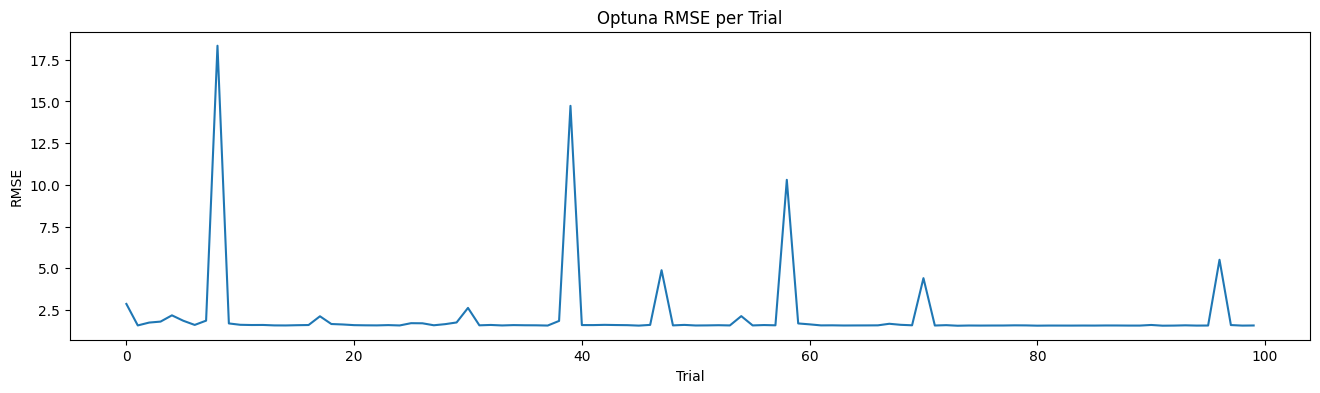

In [14]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(16, 4))
plt.plot([t.value for t in temp_study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(temp_study.trials)
)

plt.show()

plt.close(fig3)

In [15]:
vis.plot_parallel_coordinate(temp_study)

In [16]:
vis.plot_param_importances(study=temp_study)

In [17]:
completed_trials = studies_per_target['temp_next_2'].get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
temp_study = studies_per_target['temp_next_2']

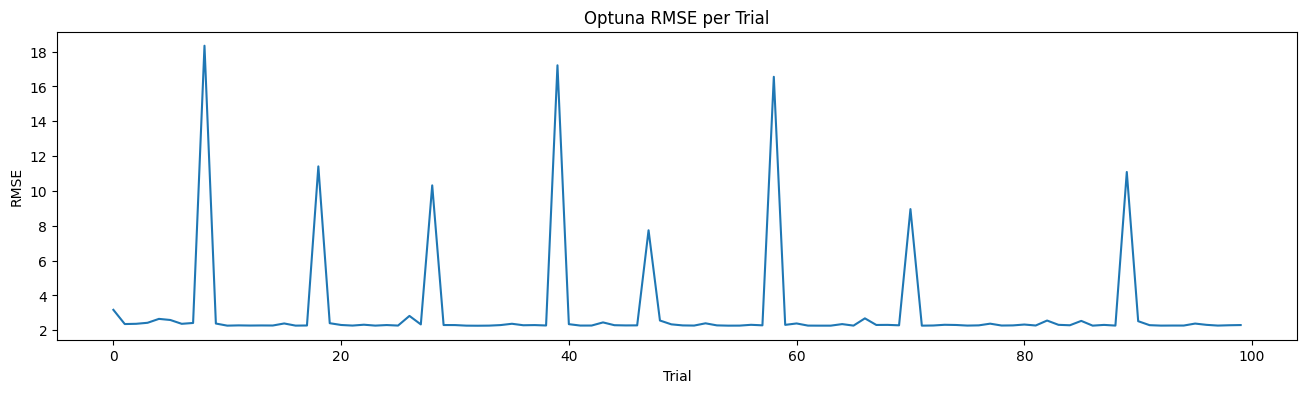

In [18]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(16, 4))
plt.plot([t.value for t in temp_study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(temp_study.trials)
)

plt.show()

plt.close(fig3)

In [19]:
vis.plot_parallel_coordinate(temp_study)

In [20]:
vis.plot_param_importances(study=temp_study)

In [21]:
completed_trials = studies_per_target['temp_next_3'].get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
temp_study = studies_per_target['temp_next_3']

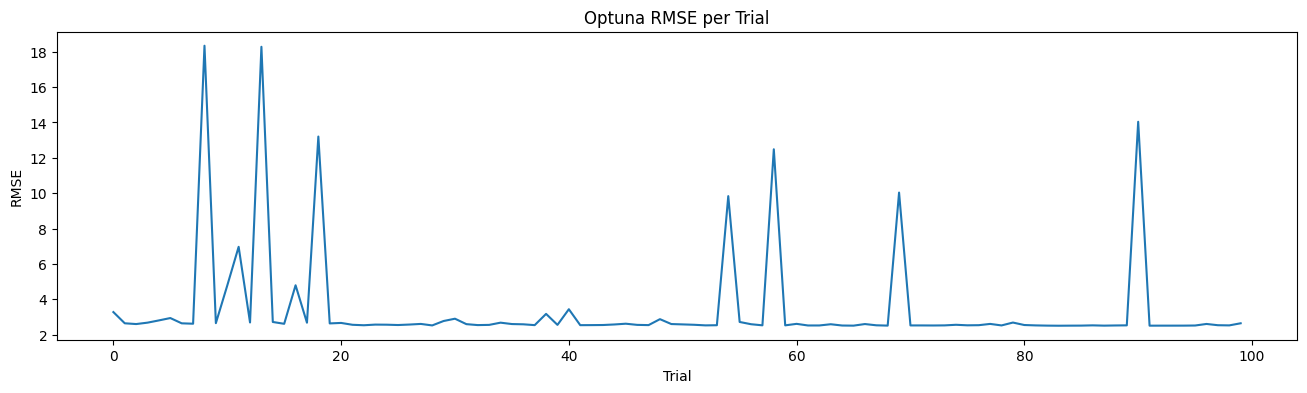

In [22]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(16, 4))
plt.plot([t.value for t in temp_study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(temp_study.trials)
)

plt.show()

plt.close(fig3)

In [23]:
vis.plot_parallel_coordinate(temp_study)

In [24]:
vis.plot_param_importances(study=temp_study)

In [25]:
completed_trials = studies_per_target['temp_next_4'].get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
temp_study = studies_per_target['temp_next_4']

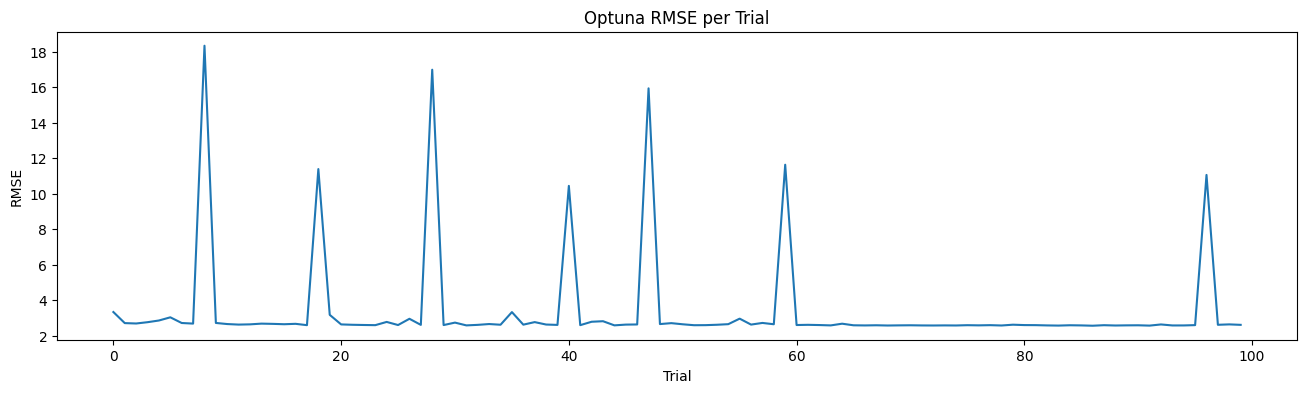

In [26]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(16, 4))
plt.plot([t.value for t in temp_study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(temp_study.trials)
)

plt.show()

plt.close(fig3)

In [27]:
vis.plot_parallel_coordinate(temp_study)

In [28]:
vis.plot_param_importances(study=temp_study)

In [29]:
completed_trials = studies_per_target['temp_next_5'].get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
temp_study = studies_per_target['temp_next_5']

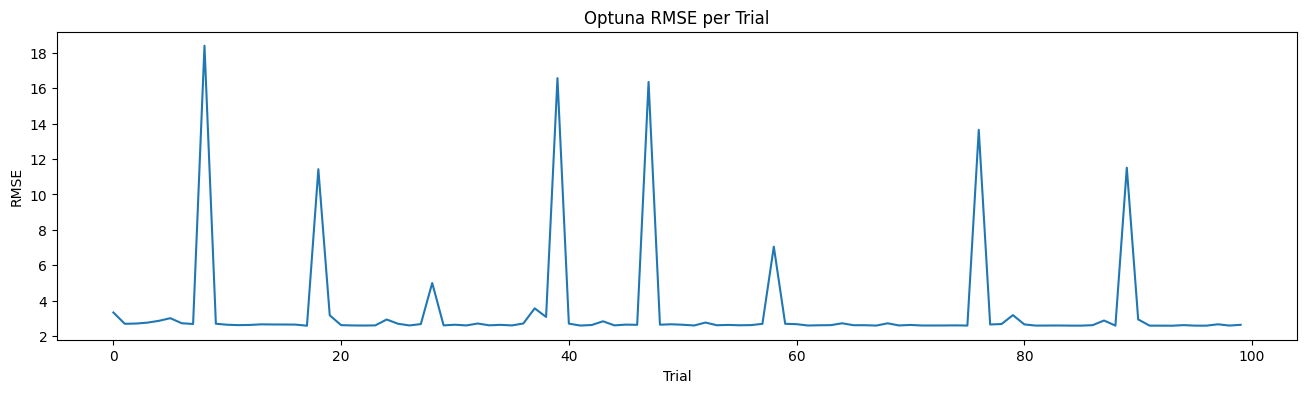

In [43]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(16, 4))
plt.plot([t.value for t in temp_study.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(temp_study.trials)
)

plt.show()

plt.close(fig3)

In [31]:
vis.plot_parallel_coordinate(temp_study)

In [32]:
vis.plot_param_importances(study=temp_study)

### **2.3. Training Final Model with Tuned Hyperparameters on Test Set**

In [ ]:
## === D. Tạo MultiOutput wrapper từ các model riêng ===
class CustomMultiOutputRegressor:
    def __init__(self, models_per_target, complete_pipelines_per_target):
        self.models_per_target = models_per_target
        self.complete_pipelines_per_target = complete_pipelines_per_target
        self.target_names = list(models_per_target.keys())
    
    def predict(self, X):
        predictions = {}
        for target_name, model_info in self.models_per_target.items():
            # Sử dụng complete pipeline của target đó
            pipeline = self.complete_pipelines_per_target[target_name]
            X_processed = pipeline.transform(X)
            X_final = X_processed.iloc[30:]
            
            pred = model_info['model'].predict(X_final)
            predictions[target_name] = pred
        
        return pd.DataFrame(predictions)
    
    def get_params(self, deep=True):
        return {
            "models_per_target": self.models_per_target,
            "complete_pipelines_per_target": self.complete_pipelines_per_target
        }

# Tạo final model với complete pipelines
final_multi_model = CustomMultiOutputRegressor(best_complete_models_per_target, complete_pipelines_per_target)

## === E. Đánh giá final model trên cả TRAIN và TEST ===
print("🔍 EVALUATING FINAL MODEL...")

# Dự đoán trên train và test set
y_pred_train = final_multi_model.predict(X_train)
y_pred_test = final_multi_model.predict(X_test)

# Cutoff y để khớp với predictions (đã bị cutoff 30 dòng trong pipeline)
y_train_cutoff = y_train.iloc[30:]
y_test_cutoff = y_test.iloc[30:]

# Đánh giá
final_train_metrics = evaluate_multi_output(y_train_cutoff, y_pred_train)
final_test_metrics = evaluate_multi_output(y_test_cutoff, y_pred_test)

# Hiển thị kết quả
print("\nFINAL MODEL PERFORMANCE")
print("=" * 60)

print("\nTRAIN SET PERFORMANCE:")
print(f"Samples: {len(y_train_cutoff)}")
print("Average metrics:")
for metric, value in final_train_metrics["average"].items():
    print(f"  {metric}: {value:.4f}")
print('Perday Train Metrics', final_train_metrics['per_day'])

print("\nTEST SET PERFORMANCE:")
print(f"Samples: {len(y_test_cutoff)}") 
print("Average metrics:")
for metric, value in final_test_metrics["average"].items():
    print(f"  {metric}: {value:.4f}")
print('Perday Test Metrics', final_test_metrics['per_day'])


🔍 EVALUATING FINAL MODEL...

FINAL MODEL PERFORMANCE

TRAIN SET PERFORMANCE:
Samples: 2893
Average metrics:
  RMSE: 1.7358
  MAE: 1.3682
  R2: 0.8826
Perday Train Metrics {'RMSE_day_1': 1.205668367797, 'MAE_day_1': 0.928752597548974, 'R2_day_1': 0.9448588883233549, 'RMSE_day_2': 1.7770230755849719, 'MAE_day_2': 1.38578462746527, 'R2_day_2': 0.8802582267056237, 'RMSE_day_3': 1.7865884031437893, 'MAE_day_3': 1.4086779067328485, 'R2_day_3': 0.8790021992657069, 'RMSE_day_4': 2.101383015276103, 'MAE_day_4': 1.6860303842750823, 'R2_day_4': 0.832645293239734, 'RMSE_day_5': 1.8082105790151768, 'MAE_day_5': 1.4318034575549823, 'R2_day_5': 0.8761021843458927}

TEST SET PERFORMANCE:
Samples: 697
Average metrics:
  RMSE: 2.1866
  MAE: 1.7246
  R2: 0.8149
Perday Test Metrics {'RMSE_day_1': 1.4682185601433222, 'MAE_day_1': 1.1247366613091387, 'R2_day_1': 0.9189411237986862, 'RMSE_day_2': 2.110153820829944, 'MAE_day_2': 1.6509722805412397, 'R2_day_2': 0.832659905862051, 'RMSE_day_3': 2.36447855621608

In [ ]:

## === F. LOG TẤT CẢ KẾT QUẢ LÊN CLEARML ===
print("\n UPLOADING ALL ARTIFACTS TO CLEARML...")

# 1. Best Parameters cho từng target
task_lgbm.upload_artifact("Best Parameters Per Target", best_complete_params_per_target)
print("Uploaded: Best Parameters Per Target")

# 2. Complete Pipelines cho từng target  
task_lgbm.upload_artifact("Complete Pipelines Per Target", complete_pipelines_per_target)
print("Uploaded: Complete Pipelines Per Target")

# 3. Final Models info
models_info = {}
for target_name, model_info in best_complete_models_per_target.items():
    models_info[target_name] = {
        'model_type': type(model_info['model']).__name__,
        'model_params': model_info['model'].get_params(),
        'features_count': X_train.shape[1],
        'pipeline_steps': list(model_info['complete_pipeline'].named_steps.keys()),
        'best_encoding_method': best_complete_params_per_target[target_name].get('encoding_method_condition', 'N/A'),
        'best_n_seasons': best_complete_params_per_target[target_name].get('n_seasons', 'N/A')
    }
task_lgbm.upload_artifact("Final Models Info", models_info)
print("Uploaded: Final Models Info")

# 4. Train Metrics
task_lgbm.upload_artifact("Final Model - Train Metrics", final_train_metrics)
print("Uploaded: Final Model - Train Metrics")

# 5. Test Metrics
task_lgbm.upload_artifact("Final Model - Test Metrics", final_test_metrics)  
print("Uploaded: Final Model - Test Metrics")

# 6. Log multioutput model
task_lgbm.upload_artifact("Final MultiOutput Model", final_multi_model)
print(" Uploaded: Final MultiOutput Model")


## === G. Lưu tất cả models ===
print("\n SAVING ALL MODELS...")

lgbm_models_path = r"models/Complete_Pipeline_LGBM_models.pkl"
joblib.dump({
    'models': best_complete_models_per_target,
    'params': best_complete_params_per_target,
    'pipelines': complete_pipelines_per_target,
    'final_multi_model': final_multi_model,
    'train_metrics': final_train_metrics,
    'test_metrics': final_test_metrics
}, lgbm_models_path)

print(f"✅ Models saved to: {lgbm_models_path}")

## === H. Summary Report ===
print(f" MODEL PERFORMANCE SUMMARY:")
print(f"   Train RMSE: {final_train_metrics['average']['RMSE']:.4f}")
print(f"   Test RMSE:  {final_test_metrics['average']['RMSE']:.4f}")

print(f"ARTIFACTS UPLOADED TO CLEARML:")
artifacts_list = [
    "Best Parameters Per Target",
    "Complete Pipelines Per Target", 
    "Final Models Info",
    "Final Model - Train Metrics",
    "Final Model - Test Metrics",
    "Final MultiOutput Model"
]

for artifact in artifacts_list:
    print(f"   ✅ {artifact}")

print(f"Training completed at: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")



 UPLOADING ALL ARTIFACTS TO CLEARML...
Uploaded: Best Parameters Per Target
2025-11-13 14:02:47,558 - clearml - WARNING - JSON serialization of artifact 'Complete Pipelines Per Target' failed, reverting to pickle
Uploaded: Complete Pipelines Per Target
Uploaded: Final Models Info
Uploaded: Final Model - Train Metrics
Uploaded: Final Model - Test Metrics
 Uploaded: Final MultiOutput Model

 SAVING ALL MODELS...
✅ Models saved to: models/Complete_Pipeline_LGBM_models.pkl
 MODEL PERFORMANCE SUMMARY:
   Train RMSE: 1.7358
   Test RMSE:  2.1866
ARTIFACTS UPLOADED TO CLEARML:
   ✅ Best Parameters Per Target
   ✅ Complete Pipelines Per Target
   ✅ Final Models Info
   ✅ Final Model - Train Metrics
   ✅ Final Model - Test Metrics
   ✅ Final MultiOutput Model
Training completed at: 2025-11-13 14:02:57


In [ ]:
task_lgbm.close()

## **3. Experiments & Results**

### **3.1. Experiment Summary Table**

| Experiment | RMSE | R² | MAE | Notes |
| :--- | :--- | :--- | :--- | :--- |
| Base Model | 2.399 | 0.756 | 1.874 | |
| Tuning #1 | 2.188 | 0.815 | 1.728 | 50 trials without pruner |
| Tuning #2 | 2.214 | 0.810 | 1.752 | 50 trials with pruner |
| Tuning #3 | 2.185 | 0.815 | 1.736 | 50 trials with pruner + fix objective |
| Tuning #4 | 2.206 | 0.812 | 1.752 | 100 trials with pruner |
| **Tuning #5 (Best model)** | **2.182** | **0.816** | **1.726** | 100 trials without pruner |
| Tuning #6 | 2.190 | 0.814 | 1.730 | 100 trials without pruner + fix objective |

### **3.2. Best model performance**

In [12]:
## === D. Tạo MultiOutput wrapper từ các model riêng ===
class CustomMultiOutputRegressor:
    def __init__(self, models_per_target, complete_pipelines_per_target):
        self.models_per_target = models_per_target
        self.complete_pipelines_per_target = complete_pipelines_per_target
        self.target_names = list(models_per_target.keys())
    
    def predict(self, X):
        predictions = {}
        for target_name, model_info in self.models_per_target.items():
            # Sử dụng complete pipeline của target đó
            pipeline = self.complete_pipelines_per_target[target_name]
            X_processed = pipeline.transform(X)
            X_final = X_processed.iloc[30:]
            
            pred = model_info['model'].predict(X_final)
            predictions[target_name] = pred
        
        return pd.DataFrame(predictions)
    
    def get_params(self, deep=True):
        return {
            "models_per_target": self.models_per_target,
            "complete_pipelines_per_target": self.complete_pipelines_per_target
        }



In [13]:
df, train_df, test_df, X_train, y_train, X_test, y_test = dp.prepare_data()

Step 1: Load Raw Data
→ Initial data shape: (3660, 33)

Dropped column: 'description'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'
Step 2: Basic Preprocessing
→ Data shape after removing redundant columns: (3660, 28)

Step 3: Split Train/Test Sets (80/20)
→ Train shape: (2928, 28)
→ Test  shape: (732, 28)

Step 4: Create Multi-Target Variables
→ Created targets: ['temp_next_1', 'temp_next_2', 'temp_next_3', 'temp_next_4', 'temp_next_5']
→ Multi-target creation completed successfully.

Step 5: Split Features (X) and Targets (y)
→ X_train shape: (2923, 28)
→ y_train shape: (2923, 5)
→ X_test  shape: (727, 28)
→ y_test  shape: (727, 5)


In [14]:
# Load model
lgbm_models_path = r"models/Complete_Pipeline_LGBM_models.pkl" 
saved_data = joblib.load(lgbm_models_path)

# Lấy final_multi_model
final_multi_model = saved_data['final_multi_model']

# Dự đoán
y_pred_test = final_multi_model.predict(X_test)
y_pred_train = final_multi_model.predict(X_train)

# Cutoff y để khớp với predictions 
y_test_cutoff = y_test.iloc[30:]
y_train_cutoff = y_train.iloc[30:]

# Đánh giá
final_test_metrics = evaluate_multi_output(y_test_cutoff, y_pred_test)
final_train_metrics = evaluate_multi_output(y_train_cutoff, y_pred_train)

print("LGBM Final Model - Test metrics (average):", final_test_metrics["average"])
print("LGBM Final Model - Test metrics (perday):", final_test_metrics["per_day"])
print()
print("LGBM Final Model - Train metrics (average):", final_train_metrics["average"])
print("LGBM Final Model - Train metrics (perday):", final_train_metrics["per_day"])

LGBM Final Model - Test metrics (average): {'RMSE': 2.186568467264542, 'MAE': 1.7246358437040967, 'R2': 0.8149084226787393}
LGBM Final Model - Test metrics (perday): {'RMSE_day_1': 1.4682185601433222, 'MAE_day_1': 1.1247366613091387, 'R2_day_1': 0.9189411237986862, 'RMSE_day_2': 2.110153820829944, 'MAE_day_2': 1.6509722805412397, 'R2_day_2': 0.832659905862051, 'RMSE_day_3': 2.3644785562160857, 'MAE_day_3': 1.8770041263526607, 'R2_day_3': 0.7901835609784756, 'RMSE_day_4': 2.4761170389007154, 'MAE_day_4': 1.9823129999028262, 'R2_day_4': 0.769912979605994, 'RMSE_day_5': 2.5138743602326437, 'MAE_day_5': 1.9881531504146175, 'R2_day_5': 0.7628445431484895}

LGBM Final Model - Train metrics (average): {'RMSE': 1.7357746881634082, 'MAE': 1.3682097947154315, 'R2': 0.8825733583760623}
LGBM Final Model - Train metrics (perday): {'RMSE_day_1': 1.205668367797, 'MAE_day_1': 0.928752597548974, 'R2_day_1': 0.9448588883233549, 'RMSE_day_2': 1.7770230755849719, 'MAE_day_2': 1.38578462746527, 'R2_day_2':

### **3.3. Result Analysis** (generated by Gemini:>)

*   `The hyperparameter tuning process significantly improved performance compared to the baseline model. The best model (Tuning #5) achieved an average test RMSE of 2.182 (more precisely 2.1816), a substantial reduction from the baseline's RMSE of 2.399. This improvement is also reflected in the R² score, which increased from 0.756 (Baseline) to 0.816 (Tuning #5) (more precisely 0.8158). This indicates the tuned model explains a significantly larger portion of the data's variance.`

*   `Based on the Optuna plot_param_importances charts generated for each target (e.g., for temp_next_1, temp_next_3, temp_next_4, etc.), the most critical hyperparameters were consistently boosting_type and learning_rate. num_leaves and n_estimators also frequently showed a significant impact on performance. The feature encoding parameters, such as encoding_method_condition and the is_category flags, generally had a lower importance ranking, though they were still relevant.`

*   `An interesting finding from the experiment summary (Table 3.1) is that running 100 trials without a pruner (Tuning #5, RMSE 2.182) outperformed 100 trials with a pruner (Tuning #4, RMSE 2.206). This suggests the pruner may have prematurely terminated some promising trials. Furthermore, the optimization process confirmed the value of tuning models independently for each target, as it selected different optimal boosting_type values (gbdt and goss) for different forecast horizons (e.g., temp_next_1 vs temp_next_3).`

## **4. Conclusion** (again still generated by Gemini:>)

*   **Conclusion:** `Successfully developed a LightGBM model for temperature forecasting. The process involved comprehensive data preparation, feature engineering (creating lag and rolling features), and categorical encoding. A baseline model using default LGBM parameters established an initial test RMSE of 2.399. By employing Bayesian optimization with Optuna's TPESampler over 100 trials, we independently tuned models for each of the 5 forecast days. This tuning process led to the selection of "Tuning #5," which significantly improved performance, achieving a final average test RMSE of 2.182 and an R² of 0.816.`